In [1]:
# from dask.distributed import Client, LocalCluster
# cluster = LocalCluster()
# client = Client(cluster)

In [2]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=1,processes=1,memory="47GB")
client = Client(cluster)
cluster.scale(cores=3)

/g/data/fu5/deg581/miniconda3/envs/devel3.9/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
client

<Client: 'tcp://10.0.128.141:34409' processes=0 threads=0, memory=0 B>

In [4]:
print(client)

<Client: 'tcp://10.0.128.141:34409' processes=0 threads=0, memory=0 B>


In [5]:
cd /g/data/fu5/deg581/OSSE_analysis/notebooks/

/g/data1a/fu5/deg581/OSSE_analysis/notebooks


In [6]:
### run my startup script
exec(open("../src/functions/fun_loadStartup.py").read())
### load my functions
exec(open("../src/functions/fun_loadMyFunctions.py").read())

%config InlineBackend.figure_format='png'

### Load grid
grdFile = '../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc'
grid = loadRomsGrid(grdFile)


loaded my modules
loaded my own functions
loading ROMS grid from ../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc


In [7]:
### new loads
import numpy.matlib
from xgcm import Grid
import matplotlib.ticker as mticker


### Load functions

In [8]:
### Other local functions

def loadOSSE(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = glob.glob(hisFilePath+prefix+filestring)

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

#     for files in filelist: 
#         print(files)
    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

### function to load overlapping OSSE data
def loadOverlappedNetcdf(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = sorted(glob.glob(hisFilePath+prefix+filestring))

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def dropDuplicateTimes(inputData):
    _, index = np.unique(inputData['ocean_time'], return_index=True)
    out = inputData.isel(ocean_time=index)
    return out

def calc_rmseSpatial(input1,input2,etaRange,xiRange):
    err2 = (input1-input2)**2
    # err=err2**(1/2)
    mse = indexMeanMetric(err2,etaRange,xiRange) #mean square error MSE
    output = mse**(1/2)
    return mse,output

# define function for calculating spatial mean
def indexMeanMetric(input,etaRange,xiRange):
    ''' iRange and jRange are converted to slices, so they are the start/end values of the range '''
    output = input.isel(eta_rho=slice(etaRange[0],etaRange[1]), xi_rho=slice(xiRange[0],xiRange[1])).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
    return output

def simple_TimeSeries(inputDataX, inputDataY, plt_kwargs={}, ax=None):
    #Plotting
    if ax is None:
        ax = plt.gca()   
    hOut = ax.plot(inputDataX, inputDataY, **plt_kwargs)
    ax.grid(color='black', alpha=0.2, linestyle='--')
    return(hOut)

def plot_spatialMapSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def plot_spatialMapGSSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def calc_boxSpatial(grid,etaRange,xiRange):
    pt00lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    pt00la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    boxLo = np.array([pt00lo, pt01lo, pt11lo, pt10lo, pt00lo])
    boxLa = np.array([pt00la, pt01la, pt11la, pt10la, pt00la])
    return boxLo,boxLa

def datestring_to_serial_day(datestring,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import pandas as pd
    import datetime
    serial_day_timedelta = pd.to_datetime(datestring) - datetime.datetime(epochY,epochm,epochd,epochH,epochM)
    corrected_serial_day_number = serial_day_timedelta.days + serial_day_timedelta.seconds/86400
    return corrected_serial_day_number


def serial_day_to_datestring(day,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import datetime
    corrected_date = datetime.datetime(epochY,epochm,epochd,epochH,epochM) + datetime.timedelta(day)
    return corrected_date.strftime("%Y-%m-%d %H:%M")


def spatialMap_addGSSubplot(toPlotData, gs, nrow,ncol, labelText, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.xlocator = mticker.FixedLocator(np.arange(150,160))
    gl.ylocator = mticker.FixedLocator(np.arange(-45,45))

    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=12, fontweight='bold', va='top')
    ax.set_title('')
    return ax

In [9]:
### Functions for calculating metrics

def loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates):
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    return sshForecast, sshAnalysis, sstForecast, sstAnalysis

def loadTruthdata(hisTruthFilePath,prefixTruth,dates):
    filenameTruth   =hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'
    sshTruth   =xr.open_dataset(filenameTruth).zeta.load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()
    return sshTruth, sstTruth

def compileOSSETimeMetricSSH(hisOSSEFilePath,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshForecast,sshAnalysis,sstForecast,sstAnalysis = loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates)       
        if dates == datelist[0]:
            ssh_metricForecast = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricAnalysis = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricForecast = xr.merge([ssh_metricForecast, temp])
            temp = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricAnalysis = xr.merge([ssh_metricAnalysis, temp])
    return ssh_metricForecast,ssh_metricAnalysis

def compileOSSETimeMetricSST(hisOSSEFilePath,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshForecast,sshAnalysis,sstForecast,sstAnalysis = loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates)       
        if dates == datelist[0]:
            sst_metricForecast = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricAnalysis = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricForecast = xr.merge([sst_metricForecast, temp])
            temp = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricAnalysis = xr.merge([sst_metricAnalysis, temp])
    return sst_metricForecast,sst_metricAnalysis

def compileTruthTimeMetric(hisTruthFilePath,prefixTruth,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshTruth,sstTruth = loadTruthdata(hisTruthFilePath,prefixTruth,dates)
        if dates == datelist[0]:
            ssh_metricTruth = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricTruth = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricTruth = xr.merge([ssh_metricTruth, temp])
            temp = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricTruth = xr.merge([sst_metricTruth, temp])
    return ssh_metricTruth, sst_metricTruth

In [10]:
### Functions for loading and processing ROMS data nicely... ROMS FUNCTIONS

from xgcm import Grid

def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    # Other Option is to transpose arrays and fill NaNs with a minimal depth
    # ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),transpose_coords=False).fillna(hmin)
    # ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),transpose_coords=False).fillna(hmin)
    ds.coords['z_rho0'] = z_rho.mean(dim='ocean_time')

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds

def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    periodic=False)
    return gridOut

def horizontalSectionROMS(grid,inputVal,targetDepth):
    # v2
    output = grid.transform(inputVal, 'Z', targetDepth,
                                    target_data=inputVal['z_rho'],
                                    method='linear').squeeze()
    return output

In [11]:

def loadOSSEFileList(hisFilePath,prefix,filelist,overlapDays=7):
    chunks = {'ocean_time':1}
    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def loadOverlappedNetcdfFileList(hisFilePath,prefix,filelist,overlapDays=7):
    chunks = {'ocean_time':1}
    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def loadNetcdfFileListAverages(hisFilePath,prefix,filelist):

    outName = xr.open_mfdataset(filelist, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def generateFileList(hisFilePath,prefix,datelist):
    filelist=[hisFilePath+prefix+'0'+str(datelist[0])+'.nc']
    for dates in datelist[1:]:
        filenameToAppend=hisFilePath+prefix+'0'+str(dates)+'.nc'
        filelist.append(filenameToAppend)

#         print(filelist)
    return filelist

# downsample data to daily.
def calc_dailyDownsample(ds):
    ds_withtime = ds.drop([ var for var in ds.variables if not 'ocean_time' in ds[var].dims ])
    ds_timeless = ds.drop([ var for var in ds.variables if     'ocean_time' in ds[var].dims ])
    ds_workaround = xr.merge([ds_timeless, ds_withtime.resample(ocean_time='5D').mean('ocean_time')])
    return ds_workaround

# calculate EKE metrics
def calc_timeMeanEKE(input):
    u_eastward_top = input.u_eastward.isel(s_rho=-1)
    v_northward_top = input.v_northward.isel(s_rho=-1)

    u_bar = u_eastward_top.mean("ocean_time")
    v_bar = v_northward_top.mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward_top - u_bar
    v_prime = v_northward_top - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)

    eketimemean = (eke*input.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)/(input.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)
    return eketimemean

def calc_MKEandEKElevel(input,level):
    u_eastward = input.u_eastward
    v_northward = input.v_northward

    u_bar = u_eastward.isel(s_rho=level).mean("ocean_time")
    v_bar = v_northward.isel(s_rho=level).mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward.isel(s_rho=level) - u_bar
    v_prime = v_northward.isel(s_rho=level) - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)
    
    input['mke']=mke
    input['eke']=eke
    return input

def calc_MKEandEKEall(input):
    u_eastward = input.u_eastward
    v_northward = input.v_northward

    u_bar = u_eastward.mean("ocean_time")
    v_bar = v_northward.mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward - u_bar
    v_prime = v_northward - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)
    
    input['mke']=mke
    input['eke']=eke
    return input

def horizontalSectionROMS(grid,inputVal,targetDepth):
    # v2
    output = grid.transform(inputVal, 'Z', targetDepth,
                                    target_data=inputVal['z_rho0'],
                                    method='linear').squeeze()
    return output

def calc_areaAverageROMS(input,grid):
    output = (input*grid.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)/(grid.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)
    return output

def calc_areaMedianROMS(input,grid):
    output = input*(grid.dA/grid.dA.sum(dim=['eta_rho','xi_rho'],skipna=True))
    output = np.median(output.values.flatten())
    return output

def process_trimVarsROMS(input,varsKeep):
    output_backup = input
    output = input[varsKeep]
    return output,output_backup

def calc_volTrans(input,etaLocation,velCutoff,depthCutoff,lonCutoff):
    input_nw = input.v_northward
    input_masked = input_nw.where(input_nw<=velCutoff).where(input.z_rho>depthCutoff).where(input_nw.lon_rho<lonCutoff)
    output = (input_masked.isel(eta_rho=transectEta)*input.dz.isel(eta_rho=transectEta)*input.dx.isel(eta_rho=transectEta)).sum(dim='s_rho').sum(dim='xi_rho')
    return output

def calc_volTransSlice(input,velCutoff,depthCutoff,lonCutoff):
    input_nw = input.v_northward
    input_masked = input_nw.where(input_nw<=velCutoff).where(input.z_rho>depthCutoff).where(input_nw.lon_rho<lonCutoff)
    output = (input_masked*input.dz*input.dx).sum(dim='s_rho').sum(dim='xi_rho')
    return output

def calc_volTransSliceNorth(input,velCutoff,depthCutoff,lonCutoff):
    input_nw = input.v_northward
    input_masked = input_nw.where(input_nw>=velCutoff).where(input.z_rho>depthCutoff).where(input_nw.lon_rho<lonCutoff)
    output = (input_masked*input.dz*input.dx).sum(dim='s_rho').sum(dim='xi_rho')
    return output

def calc_depthAverageROMS(input,grid,etaTransect):
    dz = grid.dz.mean(dim='ocean_time').isel(eta_rho=etaTransect)
    dx = grid.dx.isel(eta_rho=etaTransect)
    output = ((input*dz*dx).sum(dim=['xi_rho','s_rho'],skipna=True))/(dz*dx).sum(dim=['xi_rho','s_rho'],skipna=True)
    return output

def calc_depthAverageROMS2(input,dx,dz0,etaTransect):
    input = input.isel(eta_rho=etaTransect)
    dz = dz0.isel(eta_rho=etaTransect)
    dx = dx.isel(eta_rho=etaTransect)
    output = ((input*dz*dx).sum(dim=['xi_rho','s_rho'],skipna=True))/(dz*dx).sum(dim=['xi_rho','s_rho'],skipna=True)
    return output

In [12]:
hisTruthFilePath='/g/data/fu5/deg581/EAC_2yr_truthRun_obsVerification/output/' # Truth file settings

hisOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'
modOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'
obsOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'

hisOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'
modOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'
obsOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'

hisOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'
modOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'
obsOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'

hisOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'
modOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'
obsOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'

prefixForecast='roms_fwd_outer0_'
prefixAnalysis='roms_fwd_outer1_'
prefixAverage='roms_avg_outer1_'
prefixTruth='outer_his_'
prefixTruthAverage='outer_avg_'

prefixObs='obs_0'
prefixMod='eac_mod_'
prefixPert='outer_his_'

outFigurePath='../cache/out/'

In [13]:
timeRange = [8005, 8401]
datelist = np.array(range(timeRange[0],timeRange[1],4))

# time_range_to_load_S = slice('2012-01-01','2012-06-01')
# time_range_to_load_N = slice('2012-06-01','2012-11-01')

time_range_to_load_S = slice('2012-03-01','2012-05-01')
time_range_to_load_N = slice('2012-09-01','2012-11-01')

range_S = (str(time_range_to_load_S.start)+' - '+str(time_range_to_load_S.stop))
range_N = (str(time_range_to_load_N.start)+' - '+str(time_range_to_load_N.stop))

In [14]:
# Load zeta data
VarToKeep = ['u_eastward','v_northward','z_rho0','temp','zeta']#,'dA','dx','dy','dz']

outputPath = '/g/data/fu5/deg581/OSSE_analysis/data/proc/'
outputPrefix = 'output_'
expNames=['truth','OSSE_SSHSST','OSSE_SSHSST_XBT','OSSE_SSHSST_XBT_N','OSSE_SSHSST_XBT_S']
outputSuffix = '_'+str(timeRange[0])+'_'+str(timeRange[1])+'.nc'
filelistTruth = outputPath+outputPrefix+expNames[0]+outputSuffix
filelist_SSHSST=outputPath+outputPrefix+expNames[1]+outputSuffix
filelist_SSHSST_XBT=outputPath+outputPrefix+expNames[2]+outputSuffix
filelist_SSHSST_XBT_N=outputPath+outputPrefix+expNames[3]+outputSuffix
filelist_SSHSST_XBT_S=outputPath+outputPrefix+expNames[4]+outputSuffix

truth = xr.open_dataset(filelistTruth)
truth,truth_bu = process_trimVarsROMS(truth,VarToKeep)
truth = truth.drop('z_rho')
truth["dz0"] = truth_bu.dz.mean(dim='ocean_time')
truth["dx"] = truth_bu.dx
truth["z_rho0"] = truth.z_rho0.fillna(0)

truth["dV0"] = (truth_bu.dx*truth_bu.dy*truth_bu.dz).mean(dim='ocean_time')


truth_S = truth.sel(ocean_time=time_range_to_load_S)
truth_N = truth.sel(ocean_time=time_range_to_load_N)
truth_S.load(), print('done, loaded ~'+str(truth_S.nbytes/1024/1024/1024)+'G')
truth_N.load(), print('done, loaded ~'+str(truth_N.nbytes/1024/1024/1024)+'G')


VarToKeep = ['u_eastward','v_northward','z_rho0','temp']#,'dA','dx','dy','dz']

OSSE_SSHSST= xr.open_dataset(filelist_SSHSST)
OSSE_SSHSST_XBT= xr.open_dataset(filelist_SSHSST_XBT)
OSSE_SSHSST_XBT_N= xr.open_dataset(filelist_SSHSST_XBT_N)
OSSE_SSHSST_XBT_S= xr.open_dataset(filelist_SSHSST_XBT_S)

#load grid file
grid = makeROMSGridObject(OSSE_SSHSST)

OSSE_SSHSST,OSSE_SSHSST_bu = process_trimVarsROMS(OSSE_SSHSST,VarToKeep)
OSSE_SSHSST_XBT_S,OSSE_SSHSST_XBT_S_bu = process_trimVarsROMS(OSSE_SSHSST_XBT_S,VarToKeep)
OSSE_SSHSST_XBT_N,OSSE_SSHSST_XBT_N_bu = process_trimVarsROMS(OSSE_SSHSST_XBT_N,VarToKeep)
OSSE_SSHSST_XBT,OSSE_SSHSST_XBT_bu = process_trimVarsROMS(OSSE_SSHSST_XBT,VarToKeep)

OSSE_SSHSST = OSSE_SSHSST.drop('z_rho')
OSSE_SSHSST_XBT = OSSE_SSHSST_XBT.drop('z_rho')
OSSE_SSHSST_XBT_N = OSSE_SSHSST_XBT_N.drop('z_rho')
OSSE_SSHSST_XBT_S = OSSE_SSHSST_XBT_S.drop('z_rho')

OSSE_SSHSST["z_rho0"] = OSSE_SSHSST.z_rho0.fillna(0)
OSSE_SSHSST_XBT["z_rho0"] = OSSE_SSHSST_XBT.z_rho0.fillna(0)
OSSE_SSHSST_XBT_N["z_rho0"] = OSSE_SSHSST_XBT_N.z_rho0.fillna(0)
OSSE_SSHSST_XBT_S["z_rho0"] = OSSE_SSHSST_XBT_S.z_rho0.fillna(0)

OSSE_SSHSST["dx"] = OSSE_SSHSST_bu.dx
OSSE_SSHSST_XBT["dx"] = OSSE_SSHSST_XBT_bu.dx
OSSE_SSHSST_XBT_N["dx"] = OSSE_SSHSST_XBT_N_bu.dx
OSSE_SSHSST_XBT_S["dx"] = OSSE_SSHSST_XBT_S_bu.dx

OSSE_SSHSST["dz0"] = OSSE_SSHSST_bu.dz.mean(dim='ocean_time')
OSSE_SSHSST_XBT["dz0"] = OSSE_SSHSST_XBT_bu.dz.mean(dim='ocean_time')
OSSE_SSHSST_XBT_N["dz0"] = OSSE_SSHSST_XBT_N_bu.dz.mean(dim='ocean_time')
OSSE_SSHSST_XBT_S["dz0"] = OSSE_SSHSST_XBT_S_bu.dz.mean(dim='ocean_time')


SSHSST_S = OSSE_SSHSST.sel(ocean_time=time_range_to_load_S)
SSHSST_XBT_S1 = OSSE_SSHSST_XBT.sel(ocean_time=time_range_to_load_S)
SSHSST_XBT_N_S = OSSE_SSHSST_XBT_N.sel(ocean_time=time_range_to_load_S)
SSHSST_XBT_S_S = OSSE_SSHSST_XBT_S.sel(ocean_time=time_range_to_load_S)

SSHSST_N = OSSE_SSHSST.sel(ocean_time=time_range_to_load_N)
SSHSST_XBT_N1 = OSSE_SSHSST_XBT.sel(ocean_time=time_range_to_load_N)
SSHSST_XBT_N_N = OSSE_SSHSST_XBT_N.sel(ocean_time=time_range_to_load_N)
SSHSST_XBT_S_N = OSSE_SSHSST_XBT_S.sel(ocean_time=time_range_to_load_N)

SSHSST_S.load(), print('done, loaded ~'+str(SSHSST_S.nbytes/1024/1024/1024)+'G')
SSHSST_N.load(), print('done, loaded ~'+str(SSHSST_N.nbytes/1024/1024/1024)+'G')

SSHSST_XBT_S1.load(), print('done, loaded ~'+str(SSHSST_XBT_S1.nbytes/1024/1024/1024)+'G')
SSHSST_XBT_N1.load(), print('done, loaded ~'+str(SSHSST_XBT_N1.nbytes/1024/1024/1024)+'G')

SSHSST_XBT_N_S.load(), print('done, loaded ~'+str(SSHSST_XBT_N_S.nbytes/1024/1024/1024)+'G')
SSHSST_XBT_N_N.load(), print('done, loaded ~'+str(SSHSST_XBT_N_N.nbytes/1024/1024/1024)+'G')

SSHSST_XBT_S_S.load(), print('done, loaded ~'+str(SSHSST_XBT_S_S.nbytes/1024/1024/1024)+'G')
SSHSST_XBT_S_N.load(), print('done, loaded ~'+str(SSHSST_XBT_S_N.nbytes/1024/1024/1024)+'G')

done, loaded ~0.819726787507534G
done, loaded ~0.819726787507534G
done, loaded ~0.7921027764678001G
done, loaded ~0.7921027764678001G
done, loaded ~0.7921027764678001G
done, loaded ~0.7921027764678001G
done, loaded ~0.7921027764678001G
done, loaded ~0.7921027764678001G
done, loaded ~0.7921027764678001G
done, loaded ~0.7921027764678001G


(<xarray.Dataset>
 Dimensions:      (ocean_time: 13, s_rho: 30, eta_rho: 317, xi_rho: 272)
 Coordinates:
     z_rho0       (eta_rho, xi_rho, s_rho) float64 0.0 0.0 0.0 ... -4.485 -1.037
   * s_rho        (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
     lon_rho      (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.2 162.2
     lat_rho      (eta_rho, xi_rho) float64 -38.5 -38.51 -38.52 ... -28.15 -28.16
   * ocean_time   (ocean_time) datetime64[ns] 2012-09-02 ... 2012-11-01
 Dimensions without coordinates: eta_rho, xi_rho
 Data variables:
     u_eastward   (ocean_time, s_rho, eta_rho, xi_rho) float64 nan nan ... 0.0
     v_northward  (ocean_time, s_rho, eta_rho, xi_rho) float64 nan nan ... 0.0
     temp         (ocean_time, s_rho, eta_rho, xi_rho) float64 nan nan ... 20.59
     dx           (eta_rho, xi_rho) float64 2.996e+03 2.996e+03 ... 6e+03 6e+03
     dz0          (s_rho, eta_rho, xi_rho) float64 0.0 0.0 0.0 ... 3.178 3.178
 Attributes: (12/39)
     file:       

In [15]:
print('done, loaded ~'+str(truth_N.nbytes/1024/1024/1024)+'G')

done, loaded ~0.819726787507534G


In [16]:
## Load processed history data
outputPath = '/g/data/fu5/deg581/OSSE_analysis/data/proc/'
outputPrefix = 'output_EKE_MKE_'
expNames=['truth','OSSE_SSHSST','OSSE_SSHSST_XBT','OSSE_SSHSST_XBT_N','OSSE_SSHSST_XBT_S']
outputSuffix = '_'+str(timeRange[0])+'_'+str(timeRange[1])+'.nc'

filelistTruth = outputPath+outputPrefix+expNames[0]+outputSuffix
filelistSSHSST=outputPath+outputPrefix+expNames[1]+outputSuffix
filelistSSHSST_XBT=outputPath+outputPrefix+expNames[2]+outputSuffix
filelistSSHSST_XBT_N=outputPath+outputPrefix+expNames[3]+outputSuffix
filelistSSHSST_XBT_S=outputPath+outputPrefix+expNames[4]+outputSuffix

truth_energetics = xr.open_dataset(filelistTruth)
truth_energetics = truth_energetics.drop('mke')
truth_energetics = truth_energetics.drop('mke_0')
truth_energetics = truth_energetics.drop('mke_500')
truth_energetics = truth_energetics.drop('z_rho')
truth["z_rho0"] = truth.z_rho0.fillna(0)
truth_energetics_S = truth_energetics.sel(ocean_time=time_range_to_load_S)
truth_energetics_N = truth_energetics.sel(ocean_time=time_range_to_load_N)
truth_energetics_S.load(), print('done, loaded ~'+str(truth_energetics_S.nbytes/1024/1024/1024)+'G')
truth_energetics_N.load(), print('done, loaded ~'+str(truth_energetics_N.nbytes/1024/1024/1024)+'G')


SSHSST_energetics = xr.open_dataset(filelistSSHSST)
SSHSST_XBT_energetics = xr.open_dataset(filelistSSHSST_XBT)
SSHSST_XBT_N_energetics = xr.open_dataset(filelistSSHSST_XBT_N)
SSHSST_XBT_S_energetics = xr.open_dataset(filelistSSHSST_XBT_S)

SSHSST_energetics = SSHSST_energetics.drop('mke')
SSHSST_energetics = SSHSST_energetics.drop('mke_0')
SSHSST_energetics = SSHSST_energetics.drop('mke_500')
SSHSST_energetics = SSHSST_energetics.drop('z_rho')
SSHSST_XBT_N_energetics = SSHSST_XBT_N_energetics.drop('mke')
SSHSST_XBT_N_energetics = SSHSST_XBT_N_energetics.drop('mke_0')
SSHSST_XBT_N_energetics = SSHSST_XBT_N_energetics.drop('mke_500')
SSHSST_XBT_N_energetics = SSHSST_XBT_N_energetics.drop('z_rho')
SSHSST_XBT_S_energetics = SSHSST_XBT_S_energetics.drop('mke')
SSHSST_XBT_S_energetics = SSHSST_XBT_S_energetics.drop('mke_0')
SSHSST_XBT_S_energetics = SSHSST_XBT_S_energetics.drop('mke_500')
SSHSST_XBT_S_energetics = SSHSST_XBT_S_energetics.drop('z_rho')
SSHSST_XBT_energetics = SSHSST_XBT_energetics.drop('mke')
SSHSST_XBT_energetics = SSHSST_XBT_energetics.drop('mke_0')
SSHSST_XBT_energetics = SSHSST_XBT_energetics.drop('mke_500')
SSHSST_XBT_energetics = SSHSST_XBT_energetics.drop('z_rho')

SSHSST_energetics["z_rho0"] = SSHSST_energetics.z_rho0.fillna(0)
SSHSST_XBT_energetics["z_rho0"] = SSHSST_XBT_energetics.z_rho0.fillna(0)
SSHSST_XBT_N_energetics["z_rho0"] = SSHSST_XBT_N_energetics.z_rho0.fillna(0)
SSHSST_XBT_S_energetics["z_rho0"] = SSHSST_XBT_S_energetics.z_rho0.fillna(0)


SSHSST_energetics_S = SSHSST_energetics.sel(ocean_time=time_range_to_load_S)
SSHSST_energetics_N = SSHSST_energetics.sel(ocean_time=time_range_to_load_N)
SSHSST_XBT_energetics_S = SSHSST_XBT_energetics.sel(ocean_time=time_range_to_load_S)
SSHSST_XBT_energetics_N = SSHSST_XBT_energetics.sel(ocean_time=time_range_to_load_N)
SSHSST_XBT_N_energetics_S = SSHSST_XBT_N_energetics.sel(ocean_time=time_range_to_load_S)
SSHSST_XBT_N_energetics_N = SSHSST_XBT_N_energetics.sel(ocean_time=time_range_to_load_N)
SSHSST_XBT_S_energetics_S = SSHSST_XBT_S_energetics.sel(ocean_time=time_range_to_load_S)
SSHSST_XBT_S_energetics_N = SSHSST_XBT_S_energetics.sel(ocean_time=time_range_to_load_N)

SSHSST_energetics_S.load(), print('done, loaded ~'+str(SSHSST_energetics_S.nbytes/1024/1024/1024)+'G')
SSHSST_energetics_N.load(), print('done, loaded ~'+str(SSHSST_energetics_N.nbytes/1024/1024/1024)+'G')
SSHSST_XBT_energetics_S.load(), print('done, loaded ~'+str(SSHSST_XBT_energetics_S.nbytes/1024/1024/1024)+'G')
SSHSST_XBT_energetics_N.load(), print('done, loaded ~'+str(SSHSST_XBT_energetics_N.nbytes/1024/1024/1024)+'G')
SSHSST_XBT_N_energetics_S.load(), print('done, loaded ~'+str(SSHSST_XBT_N_energetics_S.nbytes/1024/1024/1024)+'G')
SSHSST_XBT_N_energetics_N.load(), print('done, loaded ~'+str(SSHSST_XBT_N_energetics_N.nbytes/1024/1024/1024)+'G')
SSHSST_XBT_S_energetics_S.load(), print('done, loaded ~'+str(SSHSST_XBT_S_energetics_S.nbytes/1024/1024/1024)+'G')
SSHSST_XBT_S_energetics_N.load(), print('done, loaded ~'+str(SSHSST_XBT_S_energetics_N.nbytes/1024/1024/1024)+'G')

done, loaded ~0.2878039702773094G
done, loaded ~0.2878039702773094G
done, loaded ~0.2878039702773094G
done, loaded ~0.2878039702773094G
done, loaded ~0.2878039702773094G
done, loaded ~0.2878039702773094G
done, loaded ~0.2878039702773094G
done, loaded ~0.2878039702773094G
done, loaded ~0.2878039702773094G
done, loaded ~0.2878039702773094G


(<xarray.Dataset>
 Dimensions:     (s_rho: 30, eta_rho: 317, xi_rho: 272, ocean_time: 13)
 Coordinates:
   * s_rho       (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
     lon_rho     (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.2 162.2
     lat_rho     (eta_rho, xi_rho) float64 -38.5 -38.51 -38.52 ... -28.15 -28.16
   * ocean_time  (ocean_time) datetime64[ns] 2012-09-02 2012-09-07 ... 2012-11-01
     z_rho0      (eta_rho, xi_rho, s_rho) float64 0.0 0.0 0.0 ... -4.485 -1.037
 Dimensions without coordinates: eta_rho, xi_rho
 Data variables:
     eke         (ocean_time, s_rho, eta_rho, xi_rho) float64 nan nan ... 0.0 0.0
     eke_0       (ocean_time, eta_rho, xi_rho) float64 nan nan nan ... 0.0 0.0
     eke_500     (ocean_time, eta_rho, xi_rho) float64 nan nan nan ... 0.0 0.0
 Attributes: (12/39)
     file:              roms_fwd_outer1.nc
     format:            netCDF-3 64bit offset file
     Conventions:       CF-1.4, SGRID-0.3
     type:              ROMS/TOMS 

In [17]:
# truth_energetics_S

In [18]:
u_bar = truth_S.u_eastward.mean("ocean_time")
v_bar = truth_S.v_northward.mean("ocean_time")
truth_energetics_S["mke"] = 0.5*(u_bar**2 + v_bar**2)
truth_energetics_S["mke500"] = horizontalSectionROMS(grid, truth_energetics_S.mke, np.array([-500]))
u_bar = truth_N.u_eastward.mean("ocean_time")
v_bar = truth_N.v_northward.mean("ocean_time")
truth_energetics_N["mke"] = 0.5*(u_bar**2 + v_bar**2)
truth_energetics_N["mke500"] = horizontalSectionROMS(grid, truth_energetics_N.mke, np.array([-500]))

u_bar = SSHSST_S.u_eastward.mean("ocean_time")
v_bar = SSHSST_S.v_northward.mean("ocean_time")
SSHSST_energetics_S["mke"] = 0.5*(u_bar**2 + v_bar**2)
SSHSST_energetics_S["mke500"] = horizontalSectionROMS(grid, SSHSST_energetics_S.mke, np.array([-500]))

u_bar = SSHSST_N.u_eastward.mean("ocean_time")
v_bar = SSHSST_N.v_northward.mean("ocean_time")
SSHSST_energetics_N["mke"] = 0.5*(u_bar**2 + v_bar**2)
SSHSST_energetics_N["mke500"] = horizontalSectionROMS(grid, SSHSST_energetics_N.mke, np.array([-500]))

u_bar = SSHSST_XBT_N_S.u_eastward.mean("ocean_time")
v_bar = SSHSST_XBT_N_S.v_northward.mean("ocean_time")
SSHSST_XBT_N_energetics_S["mke"] = 0.5*(u_bar**2 + v_bar**2)
SSHSST_XBT_N_energetics_S["mke500"] = horizontalSectionROMS(grid, SSHSST_XBT_N_energetics_S.mke, np.array([-500]))

u_bar = SSHSST_XBT_N_N.u_eastward.mean("ocean_time")
v_bar = SSHSST_XBT_N_N.v_northward.mean("ocean_time")
SSHSST_XBT_N_energetics_N["mke"] = 0.5*(u_bar**2 + v_bar**2)
SSHSST_XBT_N_energetics_N["mke500"] = horizontalSectionROMS(grid, SSHSST_XBT_N_energetics_N.mke, np.array([-500]))

u_bar = SSHSST_XBT_S_S.u_eastward.mean("ocean_time")
v_bar = SSHSST_XBT_S_S.v_northward.mean("ocean_time")
SSHSST_XBT_S_energetics_S["mke"] = 0.5*(u_bar**2 + v_bar**2)
SSHSST_XBT_S_energetics_S["mke500"] = horizontalSectionROMS(grid, SSHSST_XBT_S_energetics_S.mke, np.array([-500]))

u_bar = SSHSST_XBT_S_N.u_eastward.mean("ocean_time")
v_bar = SSHSST_XBT_S_N.v_northward.mean("ocean_time")
SSHSST_XBT_S_energetics_N["mke"] = 0.5*(u_bar**2 + v_bar**2)
SSHSST_XBT_S_energetics_N["mke500"] = horizontalSectionROMS(grid, SSHSST_XBT_S_energetics_N.mke, np.array([-500]))

u_bar = SSHSST_XBT_S1.u_eastward.mean("ocean_time")
v_bar = SSHSST_XBT_S1.v_northward.mean("ocean_time")
SSHSST_XBT_energetics_S["mke"] = 0.5*(u_bar**2 + v_bar**2)
SSHSST_XBT_energetics_S["mke500"] = horizontalSectionROMS(grid, SSHSST_XBT_energetics_S.mke, np.array([-500]))

u_bar = SSHSST_XBT_N1.u_eastward.mean("ocean_time")
v_bar = SSHSST_XBT_N1.v_northward.mean("ocean_time")
SSHSST_XBT_energetics_N["mke"] = 0.5*(u_bar**2 + v_bar**2)
SSHSST_XBT_energetics_N["mke500"] = horizontalSectionROMS(grid, SSHSST_XBT_energetics_N.mke, np.array([-500]))



/g/data/fu5/deg581/miniconda3/envs/devel3.9/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:146: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/g/data/fu5/deg581/miniconda3/envs/devel3.9/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:146: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


In [19]:
truth_S["temp250"] = horizontalSectionROMS(grid, truth_S.temp, np.array([-250]))
truth_S["v250"] = horizontalSectionROMS(grid, truth_S.v_northward, np.array([-250]))
truth_S["u250"] = horizontalSectionROMS(grid, truth_S.u_eastward, np.array([-250]))
print('done')
truth_N["temp250"] = horizontalSectionROMS(grid, truth_N.temp, np.array([-250]))
truth_N["v250"] = horizontalSectionROMS(grid, truth_N.v_northward, np.array([-250]))
truth_N["u250"] = horizontalSectionROMS(grid, truth_N.u_eastward, np.array([-250]))
print('done')
SSHSST_S["temp250"] = horizontalSectionROMS(grid, SSHSST_S.temp, np.array([-250]))
SSHSST_S["v250"] = horizontalSectionROMS(grid, SSHSST_S.v_northward, np.array([-250]))
SSHSST_S["u250"] = horizontalSectionROMS(grid, SSHSST_S.u_eastward, np.array([-250]))
print('done')
SSHSST_XBT_N_S["temp250"] = horizontalSectionROMS(grid, SSHSST_XBT_N_S.temp, np.array([-250]))
SSHSST_XBT_N_S["v250"] = horizontalSectionROMS(grid, SSHSST_XBT_N_S.v_northward, np.array([-250]))
SSHSST_XBT_N_S["u250"] = horizontalSectionROMS(grid, SSHSST_XBT_N_S.u_eastward, np.array([-250]))
print('done')
SSHSST_XBT_S_S["temp250"] = horizontalSectionROMS(grid, SSHSST_XBT_S_S.temp, np.array([-250]))
SSHSST_XBT_S_S["v250"] = horizontalSectionROMS(grid, SSHSST_XBT_S_S.v_northward, np.array([-250]))
SSHSST_XBT_S_S["u250"] = horizontalSectionROMS(grid, SSHSST_XBT_S_S.u_eastward, np.array([-250]))
print('done')
SSHSST_XBT_S1["temp250"] = horizontalSectionROMS(grid, SSHSST_XBT_S1.temp, np.array([-250]))
SSHSST_XBT_S1["v250"] = horizontalSectionROMS(grid, SSHSST_XBT_S1.v_northward, np.array([-250]))
SSHSST_XBT_S1["u250"] = horizontalSectionROMS(grid, SSHSST_XBT_S1.u_eastward, np.array([-250]))
print('done')
SSHSST_N["temp250"] = horizontalSectionROMS(grid, SSHSST_N.temp, np.array([-250]))
SSHSST_N["v250"] = horizontalSectionROMS(grid, SSHSST_N.v_northward, np.array([-250]))
SSHSST_N["u250"] = horizontalSectionROMS(grid, SSHSST_N.u_eastward, np.array([-250]))
print('done')
SSHSST_XBT_N_N["temp250"] = horizontalSectionROMS(grid, SSHSST_XBT_N_N.temp, np.array([-250]))
SSHSST_XBT_N_N["v250"] = horizontalSectionROMS(grid, SSHSST_XBT_N_N.v_northward, np.array([-250]))
SSHSST_XBT_N_N["u250"] = horizontalSectionROMS(grid, SSHSST_XBT_N_N.u_eastward, np.array([-250]))
print('done')
SSHSST_XBT_S_N["temp250"] = horizontalSectionROMS(grid, SSHSST_XBT_S_N.temp, np.array([-250]))
SSHSST_XBT_S_N["v250"] = horizontalSectionROMS(grid, SSHSST_XBT_S_N.v_northward, np.array([-250]))
SSHSST_XBT_S_N["u250"] = horizontalSectionROMS(grid, SSHSST_XBT_S_N.u_eastward, np.array([-250]))
print('done')
SSHSST_XBT_N1["temp250"] = horizontalSectionROMS(grid, SSHSST_XBT_N1.temp, np.array([-250]))
SSHSST_XBT_N1["v250"] = horizontalSectionROMS(grid, SSHSST_XBT_N1.v_northward, np.array([-250]))
SSHSST_XBT_N1["u250"] = horizontalSectionROMS(grid, SSHSST_XBT_N1.u_eastward, np.array([-250]))
print('done')

done
done
done
done
done
done
done
done
done
done


In [20]:
truth

<xarray.Dataset>
Dimensions:      (ocean_time: 80, s_rho: 30, eta_rho: 317, xi_rho: 272)
Coordinates:
    z_rho0       (eta_rho, xi_rho, s_rho) float64 0.0 0.0 0.0 ... -4.483 -1.035
  * s_rho        (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
    lon_rho      (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.2 162.2
    lat_rho      (eta_rho, xi_rho) float64 -38.5 -38.51 -38.52 ... -28.15 -28.16
  * ocean_time   (ocean_time) datetime64[ns] 2011-12-02 ... 2012-12-31
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    u_eastward   (ocean_time, s_rho, eta_rho, xi_rho) float64 ...
    v_northward  (ocean_time, s_rho, eta_rho, xi_rho) float64 ...
    temp         (ocean_time, s_rho, eta_rho, xi_rho) float64 ...
    zeta         (ocean_time, eta_rho, xi_rho) float64 ...
    dz0          (s_rho, eta_rho, xi_rho) float64 0.0 0.0 0.0 ... 3.178 3.178
    dx           (eta_rho, xi_rho) float64 2.996e+03 2.996e+03 ... 6e+03 6e+03
    dV0          (eta_rho, xi_rho, s_rho) float64 0.0 0.0 ... 1.09e+08 9.308e+07
Attributes: (12/31)
    file:              outer_his.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             EAC OUTER GRID
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /apps/openmpi/4.0.3/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 3.9, Thursday - October 14, 2021 - ...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       EAC, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE, AVERAGES, ...

In [21]:
# truth_v_270_N = truth_N.v_northward.isel(eta_rho=270)
# OSSE_SSHSST_v_270_N = OSSE_SSHSST_N_N.v_northward.isel(eta_rho=270)
# OSSE_SSHSST_XBT_v_270_N = OSSE_SSHSST_XBT_N1.v_northward.isel(eta_rho=270)
# OSSE_SSHSST_XBT_N_v_270_N = OSSE_SSHSST_XBT_N_N.v_northward.isel(eta_rho=270)
# OSSE_SSHSST_XBT_S_v_270_N = OSSE_SSHSST_XBT_S_N.v_northward.isel(eta_rho=270)

# truth_v_270_S = truth_S.v_northward.isel(eta_rho=270)
# OSSE_SSHSST_v_270_S = OSSE_SSHSST_N_S.v_northward.isel(eta_rho=270)
# OSSE_SSHSST_XBT_v_270_S = OSSE_SSHSST_XBT_S1.v_northward.isel(eta_rho=270)
# OSSE_SSHSST_XBT_N_v_270_S = OSSE_SSHSST_XBT_N_S.v_northward.isel(eta_rho=270)
# OSSE_SSHSST_XBT_S_v_270_S = OSSE_SSHSST_XBT_S_S.v_northward.isel(eta_rho=270)

# truth_v_170_S = truth_S.v_northward.isel(eta_rho=170)
# OSSE_SSHSST_v_170_S = OSSE_SSHSST_S.v_northward.isel(eta_rho=170)
# OSSE_SSHSST_XBT_v_170_S = OSSE_SSHSST_XBT_S1.v_northward.isel(eta_rho=170)
# OSSE_SSHSST_XBT_N_v_170_S = OSSE_SSHSST_XBT_N_S.v_northward.isel(eta_rho=170)
# OSSE_SSHSST_XBT_S_v_170_S = OSSE_SSHSST_XBT_S_S.v_northward.isel(eta_rho=170)

# truth_v_80_S = truth_S.v_northward.isel(eta_rho=80)
# OSSE_SSHSST_v_80_S = OSSE_SSHSST_S.v_northward.isel(eta_rho=80)
# OSSE_SSHSST_XBT_v_80_S = OSSE_SSHSST_XBT_S1.v_northward.isel(eta_rho=80)
# OSSE_SSHSST_XBT_N_v_80_S = OSSE_SSHSST_XBT_N_S.v_northward.isel(eta_rho=80)
# OSSE_SSHSST_XBT_S_v_80_S = OSSE_SSHSST_XBT_S_S.v_northward.isel(eta_rho=80)

# truth_v_170_S = truth_S.v_northward.isel(eta_rho=170)
# OSSE_SSHSST_v_170_S = OSSE_SSHSST_S.v_northward.isel(eta_rho=170)
# OSSE_SSHSST_XBT_v_170_S = OSSE_SSHSST_XBT_S1.v_northward.isel(eta_rho=170)
# OSSE_SSHSST_XBT_N_v_170_S = OSSE_SSHSST_XBT_N_S.v_northward.isel(eta_rho=170)
# OSSE_SSHSST_XBT_S_v_170_S = OSSE_SSHSST_XBT_S_S.v_northward.isel(eta_rho=170)

# truth_v_80_S = truth_S.v_northward.isel(eta_rho=80)
# OSSE_SSHSST_v_80_S = OSSE_SSHSST_S.v_northward.isel(eta_rho=80)
# OSSE_SSHSST_XBT_v_80_S = OSSE_SSHSST_XBT_S1.v_northward.isel(eta_rho=80)
# OSSE_SSHSST_XBT_N_v_80_S = OSSE_SSHSST_XBT_N_S.v_northward.isel(eta_rho=80)
# OSSE_SSHSST_XBT_S_v_80_S = OSSE_SSHSST_XBT_S_S.v_northward.isel(eta_rho=80)


# RMSD_SSHSST_270=((( OSSE_SSHSST_v_270-truth_v_270 )**2).mean(dim='ocean_time'))**(1/2)
# RMSD_SSHSST_XBT_N_270=((( OSSE_SSHSST_XBT_N_v_270-truth_v_270 )**2).mean(dim='ocean_time'))**(1/2)
# RMSD_SSHSST_XBT_S_270=((( OSSE_SSHSST_XBT_S_v_270-truth_v_270 )**2).mean(dim='ocean_time'))**(1/2)
# RMSD_SSHSST_XBT_270=((( OSSE_SSHSST_XBT_v_270-truth_v_270 )**2).mean(dim='ocean_time'))**(1/2)

# RMSD_SSHSST_170=((( OSSE_SSHSST_v_170-truth_v_170 )**2).mean(dim='ocean_time'))**(1/2)
# RMSD_SSHSST_XBT_N_170=((( OSSE_SSHSST_XBT_N_v_170-truth_v_170 )**2).mean(dim='ocean_time'))**(1/2)
# RMSD_SSHSST_XBT_S_170=((( OSSE_SSHSST_XBT_S_v_170-truth_v_170 )**2).mean(dim='ocean_time'))**(1/2)
# RMSD_SSHSST_XBT_170=((( OSSE_SSHSST_XBT_v_170-truth_v_170 )**2).mean(dim='ocean_time'))**(1/2)

# RMSD_SSHSST_80=((( OSSE_SSHSST_v_80-truth_v_80 )**2).mean(dim='ocean_time'))**(1/2)
# RMSD_SSHSST_XBT_N_80=((( OSSE_SSHSST_XBT_N_v_80-truth_v_80 )**2).mean(dim='ocean_time'))**(1/2)
# RMSD_SSHSST_XBT_S_80=((( OSSE_SSHSST_XBT_S_v_80-truth_v_80 )**2).mean(dim='ocean_time'))**(1/2)
# RMSD_SSHSST_XBT_80=((( OSSE_SSHSST_XBT_v_80-truth_v_80 )**2).mean(dim='ocean_time'))**(1/2)


etaTransect=270
xx_270=np.matlib.repmat(truth.lon_rho.isel(eta_rho=etaTransect),30,1)
zz_270=truth.z_rho0.isel(eta_rho=etaTransect).fillna(0).transpose()
zz_270.load(),print('done')
etaTransect=170
xx_170=np.matlib.repmat(truth.lon_rho.isel(eta_rho=etaTransect),30,1)
zz_170=truth.z_rho0.isel(eta_rho=etaTransect).fillna(0).transpose()
zz_170.load(),print('done')
etaTransect=80
xx_80=np.matlib.repmat(truth.lon_rho.isel(eta_rho=etaTransect),30,1)
zz_80=truth.z_rho0.isel(eta_rho=etaTransect).fillna(0).transpose()
zz_80.load(),print('done')


done
done
done


(<xarray.DataArray 'z_rho0' (s_rho: 30, xi_rho: 272)>
 array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -4.46448896e+03, -4.45985353e+03, -4.45985353e+03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -4.19335555e+03, -4.18900288e+03, -4.18900288e+03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -3.69590413e+03, -3.69208865e+03, -3.69208865e+03],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.04953230e+01, -1.04952512e+01, -1.04952516e+01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -5.68812289e+00, -5.68871128e+00, -5.68871171e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.61789340e+00, -1.61892878e+00, -1.61892921e+00]])
 Coordinates:
     z_rho0   (s_rho, xi_rho) float64 0.0 0.0 0.0 0.0 ... -1.618 -1.619 -1.619
   * s_rho    (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
     lo

In [22]:
xx_270 = truth.lon_rho.isel(eta_rho=270)
zz_270 = truth.z_rho0.isel(eta_rho=270)
xx_270,dump = xr.broadcast(xx_270,zz_270)
xx_270 = xx_270.transpose()
zz_270 = zz_270.transpose()

xx_170 = truth.lon_rho.isel(eta_rho=170)
zz_170 = truth.z_rho0.isel(eta_rho=170)
xx_170,dump = xr.broadcast(xx_170,zz_170)
xx_170 = xx_170.transpose()
zz_170 = zz_170.transpose()

xx_80 = truth.lon_rho.isel(eta_rho=80)
zz_80 = truth.z_rho0.isel(eta_rho=80)
xx_80,dump = xr.broadcast(xx_80,zz_80)
xx_80 = xx_80.transpose()
zz_80 = zz_80.transpose()

[Text(0, -2000.0, ''),
 Text(0, -1750.0, ''),
 Text(0, -1500.0, ''),
 Text(0, -1250.0, ''),
 Text(0, -1000.0, ''),
 Text(0, -750.0, ''),
 Text(0, -500.0, ''),
 Text(0, -250.0, ''),
 Text(0, 0.0, '')]

<Figure size 432x288 with 0 Axes>

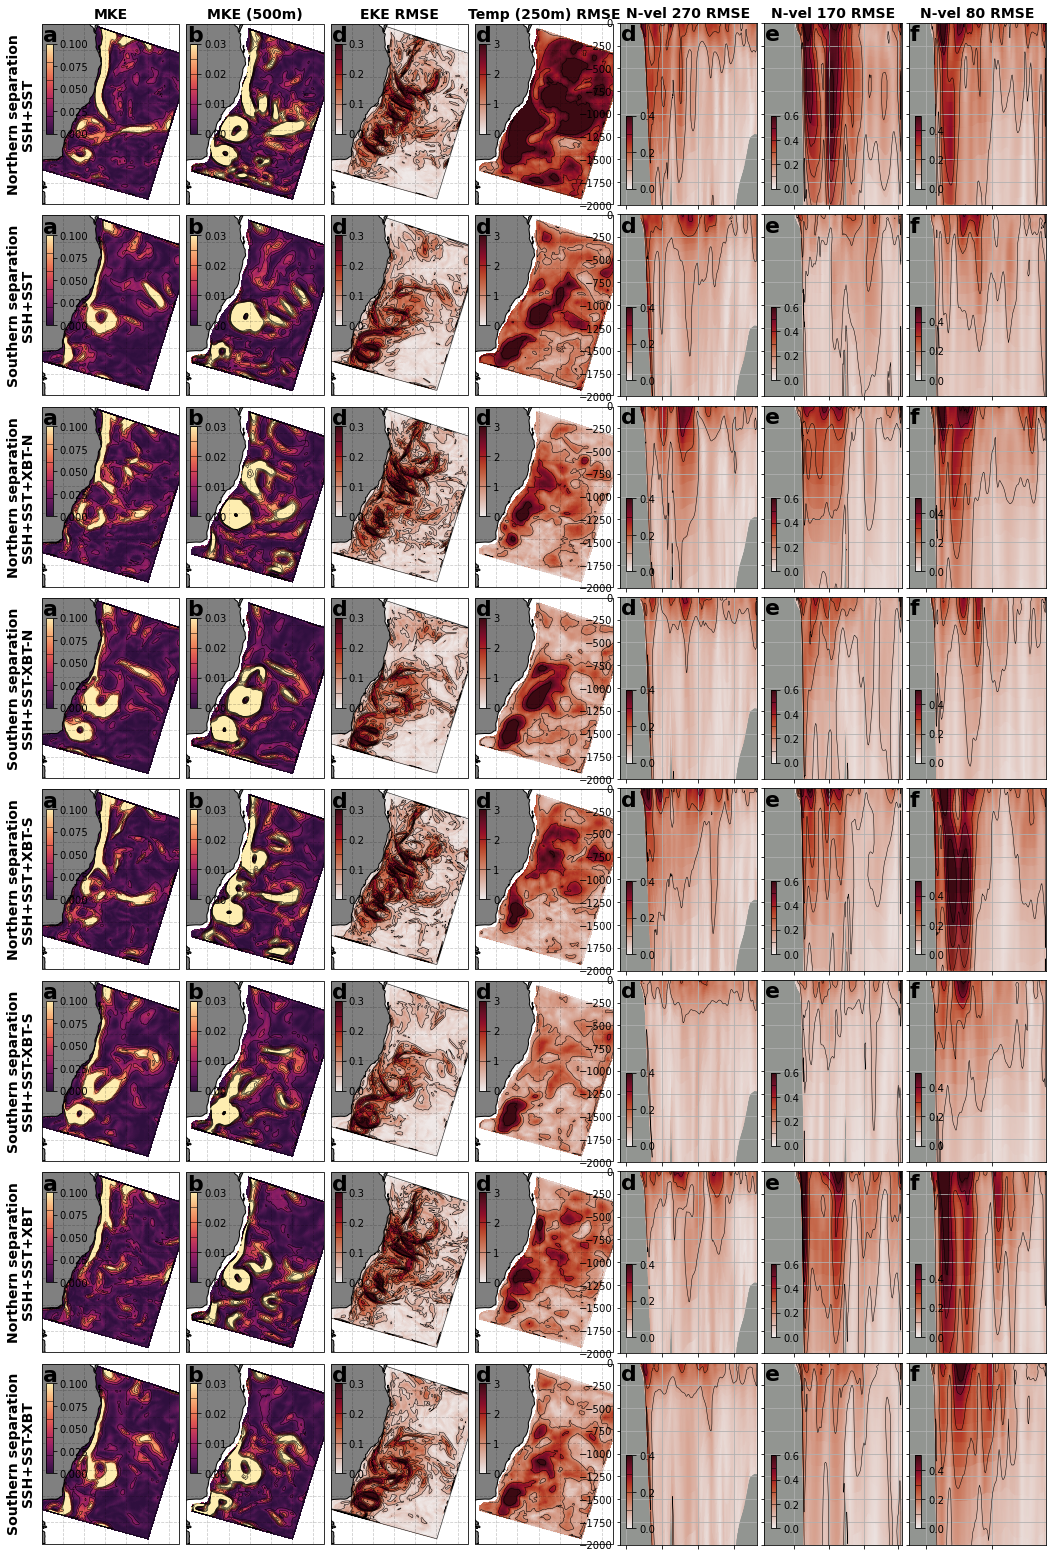

In [23]:
def addSubplot_VerticalTransect(X,Y,input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol])
    ax.set_facecolor('xkcd:grey')
    im = ax.pcolormesh(X,Y,input,shading='gouraud', **pcol_kwargs)
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.05,.09, .8, .8),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    ax.set_ylim([-2000,0])
    cbar = fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.grid()
    return ax, cbar

def addSubplot_spatialMap_pcolor(input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(input.lon_rho,input.lat_rho,input,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
#     cax = inset_axes(ax,
#                  width="5%",  # width = 10% of parent_bbox width
#                  height="50%",  # height : 50%
#                  loc='lower left',
#                  bbox_to_anchor=(.07,.39, 1, 1),
#                  bbox_transform=ax.transAxes,
#                  borderpad=0,
#                  )
#     fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.set_title('')
    return ax

def addSubplot_spatialMap_pcolor_colorbar(input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(input.lon_rho,input.lat_rho,input,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.03,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    cbar = fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.set_title('')
    return ax,cbar

gs = gridspec.GridSpec(nrows=8,ncols=7,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[18,28])
ax = None



skipRes = 10
skip = dict(eta_rho=slice(None,None,skipRes),xi_rho=slice(None,None,skipRes))


# top row
# ax,cbar = addSubplot_spatialMap_pcolor_colorbar(truth_N.temp.isel(s_rho=-1).mean(dim='ocean_time')   ,gs,0,0,'a',pcol_kwargs={'cmap':'cmo.thermal','vmin':15,'vmax':25})
# qu = ax.quiver(truth_N.lon_rho.isel(skip),truth_N.lat_rho.isel(skip),truth_N.u_eastward.isel(skip).isel(s_rho=-1).mean(dim='ocean_time'),truth_N.v_northward.isel(skip).isel(s_rho=-1).mean(dim='ocean_time'),width=0.005,scale=15)
# ax.text(-.2, .5, 'Northern separation',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
# ax.text(-.1, .5, range_N,fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)

# ax.text(0.5, 1.05, 'SST',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)

# ax,cbar = addSubplot_spatialMap_pcolor_colorbar(truth_N["temp500"].mean(dim='ocean_time')   ,gs,0,1,'f',pcol_kwargs={'cmap':'cmo.thermal','vmin':8,'vmax':13})
# qu = ax.quiver(truth_N.lon_rho.isel(skip),truth_N.lat_rho.isel(skip),truth_N["u500"].isel(skip).mean(dim='ocean_time'),truth_N["v500"].isel(skip).mean(dim='ocean_time'),width=0.005,scale=7.5)
# ax.text(0.5, 1.05, 'Temp (500m)',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)

# SSH+SST - NORTHERN SEPARATION

ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_energetics_N.mke.isel(s_rho=-1)  ,gs,0,0,'a',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.1})
co = SSHSST_energetics_N.mke.isel(s_rho=-1).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.1,0.02),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.text(0.5, 1.05, 'MKE',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.set_title('')
ax.text(-.2, .5, 'Northern separation',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
ax.text(-.1, .5, 'SSH+SST',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_energetics_N.mke500  ,gs,0,1,'b',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.03})
co = SSHSST_energetics_N.mke500.plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.04,0.005),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.text(0.5, 1.05, 'MKE (500m)',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_energetics_N.eke_0-truth_energetics_N.eke_0)**2).mean(dim='ocean_time'))**.5)  ,gs,0,2,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':0.3})
co = ((((SSHSST_energetics_N.eke_0-truth_energetics_N.eke_0)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.4,0.05),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.text(0.5, 1.05, 'EKE RMSE',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_N.temp250-truth_N.temp250)**2).mean(dim='ocean_time'))**.5)  ,gs,0,3,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':3})
co = ((((SSHSST_N.temp250-truth_N.temp250)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,4,1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.text(0.5, 1.05, 'Temp (250m) RMSE',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)


ax,cbar = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_N.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs,0,4,'d',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_270,zz_270,(((( SSHSST_N.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.text(0.5, 1.05, 'N-vel 270 RMSE',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.set_xticklabels([])

ax,cbar = addSubplot_VerticalTransect(xx_170,zz_170,((( SSHSST_N.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2),gs,0,5,'e',pcol_kwargs={'vmin':0,'vmax':0.6,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_170,zz_170,((((SSHSST_N.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.7,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.text(0.5, 1.05, 'N-vel 170 RMSE',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax,cbar = addSubplot_VerticalTransect(xx_80,zz_80,((( SSHSST_N.v_northward.isel(eta_rho=80)-truth_N.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2),gs,0,6,'f',pcol_kwargs={'vmin':0,'vmax':0.5,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_80,zz_80,(((( SSHSST_N.v_northward.isel(eta_rho=80)-truth_N.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.text(0.5, 1.05, 'N-vel 80 RMSE',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.set_xticklabels([])
ax.set_yticklabels([])

# SSH+SST - SOUTHERN SEPARATION


ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_energetics_S.mke.isel(s_rho=-1)  ,gs,1,0,'a',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.1})
co = SSHSST_energetics_S.mke.isel(s_rho=-1).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.1,0.02),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_title('')
ax.text(-.2, .5, 'Southern separation',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
ax.text(-.1, .5, 'SSH+SST',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_energetics_S.mke500  ,gs,1,1,'b',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.03})
co = SSHSST_energetics_S.mke500.plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.04,0.005),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_energetics_S.eke_0-truth_energetics_S.eke_0)**2).mean(dim='ocean_time'))**.5)  ,gs,1,2,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':0.3})
co = ((((SSHSST_energetics_S.eke_0-truth_energetics_S.eke_0)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.4,0.05),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_S.temp250-truth_S.temp250)**2).mean(dim='ocean_time'))**.5)  ,gs,1,3,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':3})
co = ((((SSHSST_S.temp250-truth_S.temp250)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,4,1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)


ax,cbar = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_S.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs,1,4,'d',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_270,zz_270,(((( SSHSST_S.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])

ax,cbar = addSubplot_VerticalTransect(xx_170,zz_170,((( SSHSST_S.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2),gs,1,5,'e',pcol_kwargs={'vmin':0,'vmax':0.6,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_170,zz_170,((((SSHSST_S.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.7,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax,cbar = addSubplot_VerticalTransect(xx_80,zz_80,((( SSHSST_S.v_northward.isel(eta_rho=80)-truth_S.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2),gs,1,6,'f',pcol_kwargs={'vmin':0,'vmax':0.5,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_80,zz_80,(((( SSHSST_S.v_northward.isel(eta_rho=80)-truth_S.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.set_yticklabels([])

# XBT-N - NORTHERN SEPARATION

ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_XBT_N_energetics_N.mke.isel(s_rho=-1)  ,gs,2,0,'a',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.1})
co = SSHSST_XBT_N_energetics_N.mke.isel(s_rho=-1).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.1,0.02),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_title('')
ax.text(-.2, .5, 'Northern separation',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
ax.text(-.1, .5, 'SSH+SST+XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_XBT_N_energetics_N.mke500  ,gs,2,1,'b',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.03})
co = SSHSST_XBT_N_energetics_N.mke500.plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.04,0.005),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_XBT_N_energetics_N.eke_0-truth_energetics_N.eke_0)**2).mean(dim='ocean_time'))**.5)  ,gs,2,2,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':0.3})
co = ((((SSHSST_XBT_N_energetics_N.eke_0-truth_energetics_N.eke_0)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.4,0.05),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_XBT_N_N.temp250-truth_N.temp250)**2).mean(dim='ocean_time'))**.5)  ,gs,2,3,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':3})
co = ((((SSHSST_XBT_N_N.temp250-truth_N.temp250)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,4,1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)


ax,cbar = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_XBT_N_N.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs,2,4,'d',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_270,zz_270,(((( SSHSST_XBT_N_N.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])

ax,cbar = addSubplot_VerticalTransect(xx_170,zz_170,((( SSHSST_XBT_N_N.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2),gs,2,5,'e',pcol_kwargs={'vmin':0,'vmax':0.6,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_170,zz_170,((((SSHSST_XBT_N_N.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.7,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax,cbar = addSubplot_VerticalTransect(xx_80,zz_80,((( SSHSST_XBT_N_N.v_northward.isel(eta_rho=80)-truth_N.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2),gs,2,6,'f',pcol_kwargs={'vmin':0,'vmax':0.5,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_80,zz_80,(((( SSHSST_XBT_N_N.v_northward.isel(eta_rho=80)-truth_N.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.set_yticklabels([])

# XBT-N - SOUTHERN SEPARATION


ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_XBT_N_energetics_S.mke.isel(s_rho=-1)  ,gs,3,0,'a',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.1})
co = SSHSST_XBT_N_energetics_S.mke.isel(s_rho=-1).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.1,0.02),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_title('')
ax.text(-.2, .5, 'Southern separation',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
ax.text(-.1, .5, 'SSH+SST-XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_XBT_N_energetics_S.mke500  ,gs,3,1,'b',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.03})
co = SSHSST_XBT_N_energetics_S.mke500.plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.04,0.005),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_XBT_N_energetics_S.eke_0-truth_energetics_S.eke_0)**2).mean(dim='ocean_time'))**.5)  ,gs,3,2,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':0.3})
co = ((((SSHSST_XBT_N_energetics_S.eke_0-truth_energetics_S.eke_0)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.4,0.05),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_XBT_N_S.temp250-truth_S.temp250)**2).mean(dim='ocean_time'))**.5)  ,gs,3,3,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':3})
co = ((((SSHSST_XBT_N_S.temp250-truth_S.temp250)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,4,1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)


ax,cbar = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_XBT_N_S.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs,3,4,'d',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_270,zz_270,(((( SSHSST_XBT_N_S.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])

ax,cbar = addSubplot_VerticalTransect(xx_170,zz_170,((( SSHSST_XBT_N_S.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2),gs,3,5,'e',pcol_kwargs={'vmin':0,'vmax':0.6,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_170,zz_170,((((SSHSST_XBT_N_S.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.7,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax,cbar = addSubplot_VerticalTransect(xx_80,zz_80,((( SSHSST_XBT_N_S.v_northward.isel(eta_rho=80)-truth_S.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2),gs,3,6,'f',pcol_kwargs={'vmin':0,'vmax':0.5,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_80,zz_80,(((( SSHSST_XBT_N_S.v_northward.isel(eta_rho=80)-truth_S.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.set_yticklabels([])


# XBT-S - NORTHERN SEPARATION

ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_XBT_S_energetics_N.mke.isel(s_rho=-1)  ,gs,4,0,'a',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.1})
co = SSHSST_XBT_S_energetics_N.mke.isel(s_rho=-1).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.1,0.02),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_title('')
ax.text(-.2, .5, 'Northern separation',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
ax.text(-.1, .5, 'SSH+SST+XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_XBT_S_energetics_N.mke500  ,gs,4,1,'b',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.03})
co = SSHSST_XBT_S_energetics_N.mke500.plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.04,0.005),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_XBT_S_energetics_N.eke_0-truth_energetics_N.eke_0)**2).mean(dim='ocean_time'))**.5)  ,gs,4,2,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':0.3})
co = ((((SSHSST_XBT_S_energetics_N.eke_0-truth_energetics_N.eke_0)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.4,0.05),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_XBT_S_N.temp250-truth_N.temp250)**2).mean(dim='ocean_time'))**.5)  ,gs,4,3,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':3})
co = ((((SSHSST_XBT_S_N.temp250-truth_N.temp250)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,4,1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)


ax,cbar = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_XBT_S_N.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs,4,4,'d',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_270,zz_270,(((( SSHSST_XBT_S_N.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])

ax,cbar = addSubplot_VerticalTransect(xx_170,zz_170,((( SSHSST_XBT_S_N.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2),gs,4,5,'e',pcol_kwargs={'vmin':0,'vmax':0.6,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_170,zz_170,((((SSHSST_XBT_S_N.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.7,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax,cbar = addSubplot_VerticalTransect(xx_80,zz_80,((( SSHSST_XBT_S_N.v_northward.isel(eta_rho=80)-truth_N.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2),gs,4,6,'f',pcol_kwargs={'vmin':0,'vmax':0.5,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_80,zz_80,(((( SSHSST_XBT_S_N.v_northward.isel(eta_rho=80)-truth_N.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.set_yticklabels([])

# XBT-S - SOUTHERN SEPARATION


ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_XBT_S_energetics_S.mke.isel(s_rho=-1)  ,gs,5,0,'a',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.1})
co = SSHSST_XBT_S_energetics_S.mke.isel(s_rho=-1).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.1,0.02),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_title('')
ax.text(-.2, .5, 'Southern separation',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
ax.text(-.1, .5, 'SSH+SST-XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_XBT_S_energetics_S.mke500  ,gs,5,1,'b',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.03})
co = SSHSST_XBT_S_energetics_S.mke500.plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.04,0.005),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_XBT_S_energetics_S.eke_0-truth_energetics_S.eke_0)**2).mean(dim='ocean_time'))**.5)  ,gs,5,2,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':0.3})
co = ((((SSHSST_XBT_S_energetics_S.eke_0-truth_energetics_S.eke_0)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.4,0.05),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_XBT_S_S.temp250-truth_S.temp250)**2).mean(dim='ocean_time'))**.5)  ,gs,5,3,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':3})
co = ((((SSHSST_XBT_S_S.temp250-truth_S.temp250)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,4,1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)


ax,cbar = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_XBT_S_S.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs,5,4,'d',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_270,zz_270,(((( SSHSST_XBT_S_S.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])

ax,cbar = addSubplot_VerticalTransect(xx_170,zz_170,((( SSHSST_XBT_S_S.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2),gs,5,5,'e',pcol_kwargs={'vmin':0,'vmax':0.6,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_170,zz_170,((((SSHSST_XBT_S_S.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.7,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax,cbar = addSubplot_VerticalTransect(xx_80,zz_80,((( SSHSST_XBT_S_S.v_northward.isel(eta_rho=80)-truth_S.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2),gs,5,6,'f',pcol_kwargs={'vmin':0,'vmax':0.5,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_80,zz_80,(((( SSHSST_XBT_S_S.v_northward.isel(eta_rho=80)-truth_S.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.set_yticklabels([])


# XBT - NORTHERN SEPARATION

ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_XBT_energetics_N.mke.isel(s_rho=-1)  ,gs,6,0,'a',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.1})
co = SSHSST_XBT_energetics_N.mke.isel(s_rho=-1).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.1,0.02),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_title('')
ax.text(-.2, .5, 'Northern separation',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
ax.text(-.1, .5, 'SSH+SST+XBT',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_XBT_energetics_N.mke500  ,gs,6,1,'b',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.03})
co = SSHSST_XBT_energetics_N.mke500.plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.04,0.005),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_XBT_energetics_N.eke_0-truth_energetics_N.eke_0)**2).mean(dim='ocean_time'))**.5)  ,gs,6,2,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':0.3})
co = ((((SSHSST_XBT_energetics_N.eke_0-truth_energetics_N.eke_0)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.4,0.05),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_XBT_N1.temp250-truth_N.temp250)**2).mean(dim='ocean_time'))**.5)  ,gs,6,3,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':3})
co = ((((SSHSST_XBT_N1.temp250-truth_N.temp250)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,4,1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)


ax,cbar = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_XBT_N1.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs,6,4,'d',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_270,zz_270,(((( SSHSST_XBT_N1.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])

ax,cbar = addSubplot_VerticalTransect(xx_170,zz_170,((( SSHSST_XBT_N1.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2),gs,6,5,'e',pcol_kwargs={'vmin':0,'vmax':0.6,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_170,zz_170,((((SSHSST_XBT_N1.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.7,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax,cbar = addSubplot_VerticalTransect(xx_80,zz_80,((( SSHSST_XBT_N1.v_northward.isel(eta_rho=80)-truth_N.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2),gs,6,6,'f',pcol_kwargs={'vmin':0,'vmax':0.5,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_80,zz_80,(((( SSHSST_XBT_N1.v_northward.isel(eta_rho=80)-truth_N.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.set_yticklabels([])

# XBT - SOUTHERN SEPARATION


ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_XBT_energetics_S.mke.isel(s_rho=-1)  ,gs,7,0,'a',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.1})
co = SSHSST_XBT_energetics_S.mke.isel(s_rho=-1).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.1,0.02),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_title('')
ax.text(-.2, .5, 'Southern separation',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
ax.text(-.1, .5, 'SSH+SST-XBT',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_XBT_energetics_S.mke500  ,gs,7,1,'b',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.03})
co = SSHSST_XBT_energetics_S.mke500.plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.04,0.005),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_XBT_energetics_S.eke_0-truth_energetics_S.eke_0)**2).mean(dim='ocean_time'))**.5)  ,gs,7,2,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':0.3})
co = ((((SSHSST_XBT_energetics_S.eke_0-truth_energetics_S.eke_0)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.4,0.05),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_XBT_S1.temp250-truth_S.temp250)**2).mean(dim='ocean_time'))**.5)  ,gs,7,3,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':3})
co = ((((SSHSST_XBT_S1.temp250-truth_S.temp250)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,4,1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)

ax,cbar = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_XBT_S1.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs,7,4,'d',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_270,zz_270,(((( SSHSST_XBT_S1.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])

ax,cbar = addSubplot_VerticalTransect(xx_170,zz_170,((( SSHSST_XBT_S1.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2),gs,7,5,'e',pcol_kwargs={'vmin':0,'vmax':0.6,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_170,zz_170,((((SSHSST_XBT_S1.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.7,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax,cbar = addSubplot_VerticalTransect(xx_80,zz_80,((( SSHSST_XBT_S1.v_northward.isel(eta_rho=80)-truth_S.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2),gs,7,6,'f',pcol_kwargs={'vmin':0,'vmax':0.5,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_80,zz_80,(((( SSHSST_XBT_S1.v_northward.isel(eta_rho=80)-truth_S.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.set_yticklabels([])







Text(0.05, 0.05, '0.052 $m/s$')

<Figure size 432x288 with 0 Axes>

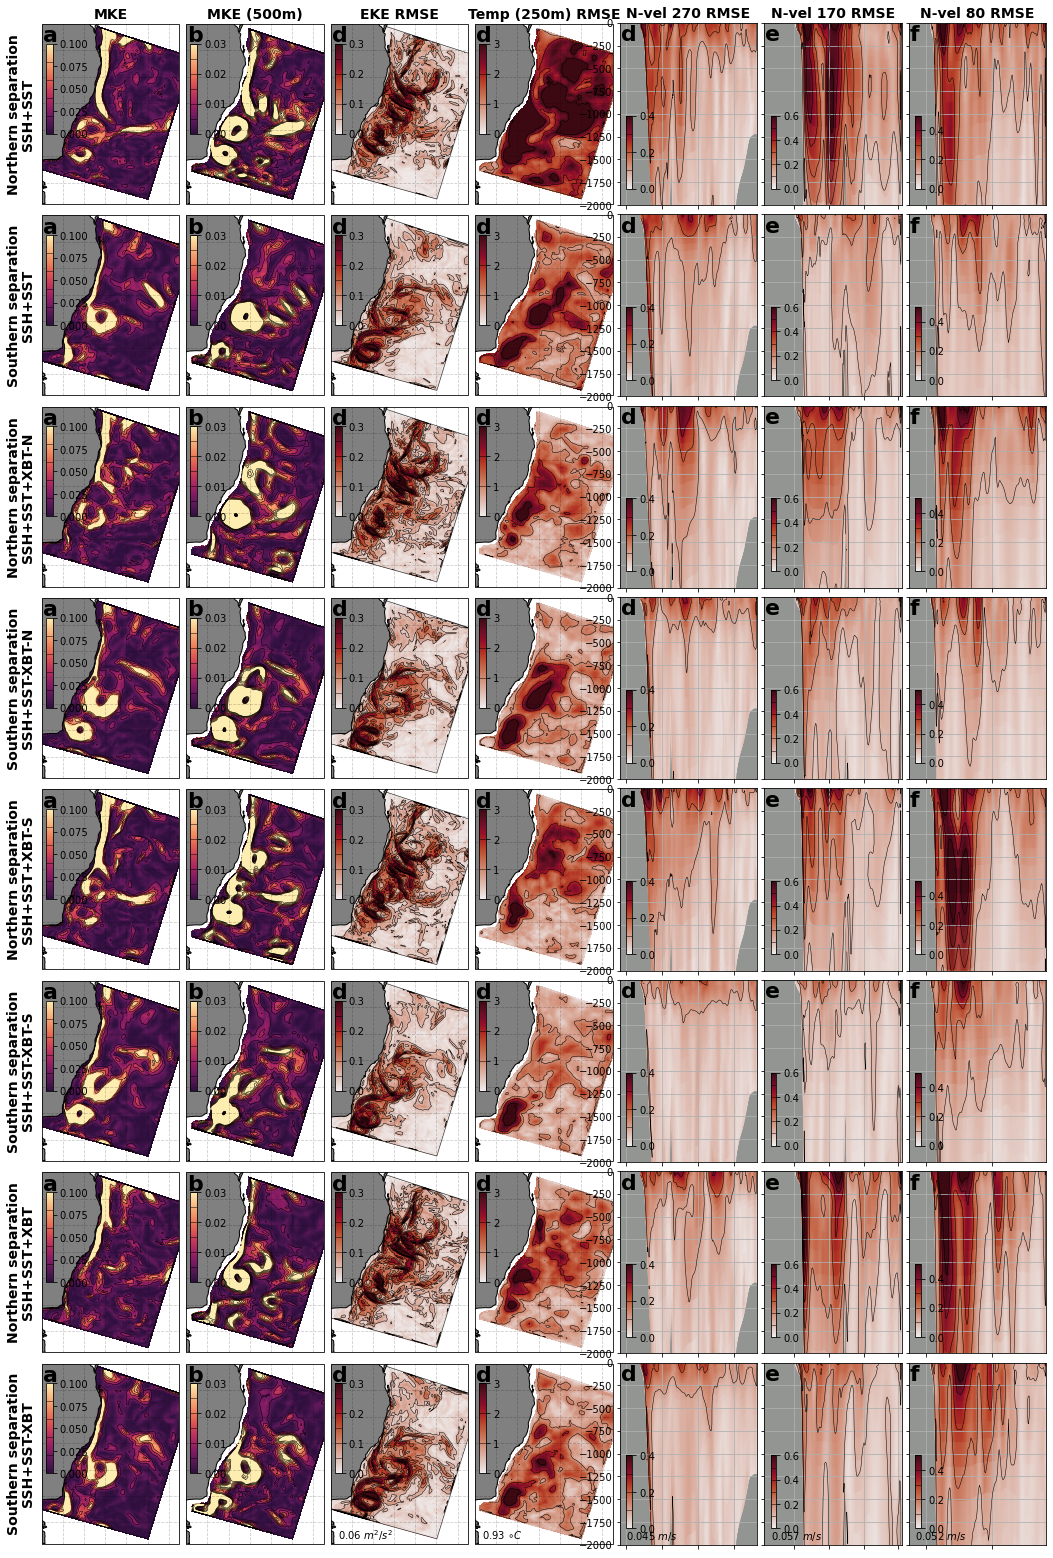

In [24]:
def addSubplot_VerticalTransect(X,Y,input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol])
    ax.set_facecolor('xkcd:grey')
    im = ax.pcolormesh(X,Y,input,shading='gouraud', **pcol_kwargs)
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.05,.09, .8, .8),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    ax.set_ylim([-2000,0])
    cbar = fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.grid()
    return ax, cbar

def addSubplot_spatialMap_pcolor(input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(input.lon_rho,input.lat_rho,input,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
#     cax = inset_axes(ax,
#                  width="5%",  # width = 10% of parent_bbox width
#                  height="50%",  # height : 50%
#                  loc='lower left',
#                  bbox_to_anchor=(.07,.39, 1, 1),
#                  bbox_transform=ax.transAxes,
#                  borderpad=0,
#                  )
#     fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.set_title('')
    return ax

def addSubplot_spatialMap_pcolor_colorbar(input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(input.lon_rho,input.lat_rho,input,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.03,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    cbar = fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.set_title('')
    return ax,cbar

gs = gridspec.GridSpec(nrows=8,ncols=7,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[18,28])
ax = None



skipRes = 10
skip = dict(eta_rho=slice(None,None,skipRes),xi_rho=slice(None,None,skipRes))


# top row
# ax,cbar = addSubplot_spatialMap_pcolor_colorbar(truth_N.temp.isel(s_rho=-1).mean(dim='ocean_time')   ,gs,0,0,'a',pcol_kwargs={'cmap':'cmo.thermal','vmin':15,'vmax':25})
# qu = ax.quiver(truth_N.lon_rho.isel(skip),truth_N.lat_rho.isel(skip),truth_N.u_eastward.isel(skip).isel(s_rho=-1).mean(dim='ocean_time'),truth_N.v_northward.isel(skip).isel(s_rho=-1).mean(dim='ocean_time'),width=0.005,scale=15)
# ax.text(-.2, .5, 'Northern separation',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
# ax.text(-.1, .5, range_N,fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)

# ax.text(0.5, 1.05, 'SST',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)

# ax,cbar = addSubplot_spatialMap_pcolor_colorbar(truth_N["temp500"].mean(dim='ocean_time')   ,gs,0,1,'f',pcol_kwargs={'cmap':'cmo.thermal','vmin':8,'vmax':13})
# qu = ax.quiver(truth_N.lon_rho.isel(skip),truth_N.lat_rho.isel(skip),truth_N["u500"].isel(skip).mean(dim='ocean_time'),truth_N["v500"].isel(skip).mean(dim='ocean_time'),width=0.005,scale=7.5)
# ax.text(0.5, 1.05, 'Temp (500m)',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)

# SSH+SST - NORTHERN SEPARATION

ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_energetics_N.mke.isel(s_rho=-1)  ,gs,0,0,'a',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.1})
co = SSHSST_energetics_N.mke.isel(s_rho=-1).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.1,0.02),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.text(0.5, 1.05, 'MKE',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.set_title('')
ax.text(-.2, .5, 'Northern separation',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
ax.text(-.1, .5, 'SSH+SST',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_energetics_N.mke500  ,gs,0,1,'b',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.03})
co = SSHSST_energetics_N.mke500.plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.04,0.005),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.text(0.5, 1.05, 'MKE (500m)',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_energetics_N.eke_0-truth_energetics_N.eke_0)**2).mean(dim='ocean_time'))**.5)  ,gs,0,2,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':0.3})
co = ((((SSHSST_energetics_N.eke_0-truth_energetics_N.eke_0)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.4,0.05),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.text(0.5, 1.05, 'EKE RMSE',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_N.temp250-truth_N.temp250)**2).mean(dim='ocean_time'))**.5)  ,gs,0,3,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':3})
co = ((((SSHSST_N.temp250-truth_N.temp250)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,4,1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.text(0.5, 1.05, 'Temp (250m) RMSE',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)


ax,cbar = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_N.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs,0,4,'d',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_270,zz_270,(((( SSHSST_N.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.text(0.5, 1.05, 'N-vel 270 RMSE',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.set_xticklabels([])

ax,cbar = addSubplot_VerticalTransect(xx_170,zz_170,((( SSHSST_N.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2),gs,0,5,'e',pcol_kwargs={'vmin':0,'vmax':0.6,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_170,zz_170,((((SSHSST_N.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.7,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.text(0.5, 1.05, 'N-vel 170 RMSE',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax,cbar = addSubplot_VerticalTransect(xx_80,zz_80,((( SSHSST_N.v_northward.isel(eta_rho=80)-truth_N.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2),gs,0,6,'f',pcol_kwargs={'vmin':0,'vmax':0.5,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_80,zz_80,(((( SSHSST_N.v_northward.isel(eta_rho=80)-truth_N.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.text(0.5, 1.05, 'N-vel 80 RMSE',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.set_xticklabels([])
ax.set_yticklabels([])

# SSH+SST - SOUTHERN SEPARATION


ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_energetics_S.mke.isel(s_rho=-1)  ,gs,1,0,'a',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.1})
co = SSHSST_energetics_S.mke.isel(s_rho=-1).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.1,0.02),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_title('')
ax.text(-.2, .5, 'Southern separation',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
ax.text(-.1, .5, 'SSH+SST',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_energetics_S.mke500  ,gs,1,1,'b',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.03})
co = SSHSST_energetics_S.mke500.plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.04,0.005),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_energetics_S.eke_0-truth_energetics_S.eke_0)**2).mean(dim='ocean_time'))**.5)  ,gs,1,2,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':0.3})
co = ((((SSHSST_energetics_S.eke_0-truth_energetics_S.eke_0)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.4,0.05),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_S.temp250-truth_S.temp250)**2).mean(dim='ocean_time'))**.5)  ,gs,1,3,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':3})
co = ((((SSHSST_S.temp250-truth_S.temp250)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,4,1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)


ax,cbar = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_S.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs,1,4,'d',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_270,zz_270,(((( SSHSST_S.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])

ax,cbar = addSubplot_VerticalTransect(xx_170,zz_170,((( SSHSST_S.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2),gs,1,5,'e',pcol_kwargs={'vmin':0,'vmax':0.6,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_170,zz_170,((((SSHSST_S.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.7,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax,cbar = addSubplot_VerticalTransect(xx_80,zz_80,((( SSHSST_S.v_northward.isel(eta_rho=80)-truth_S.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2),gs,1,6,'f',pcol_kwargs={'vmin':0,'vmax':0.5,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_80,zz_80,(((( SSHSST_S.v_northward.isel(eta_rho=80)-truth_S.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.set_yticklabels([])

# XBT-N - NORTHERN SEPARATION

ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_XBT_N_energetics_N.mke.isel(s_rho=-1)  ,gs,2,0,'a',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.1})
co = SSHSST_XBT_N_energetics_N.mke.isel(s_rho=-1).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.1,0.02),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_title('')
ax.text(-.2, .5, 'Northern separation',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
ax.text(-.1, .5, 'SSH+SST+XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_XBT_N_energetics_N.mke500  ,gs,2,1,'b',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.03})
co = SSHSST_XBT_N_energetics_N.mke500.plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.04,0.005),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_XBT_N_energetics_N.eke_0-truth_energetics_N.eke_0)**2).mean(dim='ocean_time'))**.5)  ,gs,2,2,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':0.3})
co = ((((SSHSST_XBT_N_energetics_N.eke_0-truth_energetics_N.eke_0)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.4,0.05),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_XBT_N_N.temp250-truth_N.temp250)**2).mean(dim='ocean_time'))**.5)  ,gs,2,3,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':3})
co = ((((SSHSST_XBT_N_N.temp250-truth_N.temp250)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,4,1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)


ax,cbar = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_XBT_N_N.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs,2,4,'d',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_270,zz_270,(((( SSHSST_XBT_N_N.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])

ax,cbar = addSubplot_VerticalTransect(xx_170,zz_170,((( SSHSST_XBT_N_N.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2),gs,2,5,'e',pcol_kwargs={'vmin':0,'vmax':0.6,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_170,zz_170,((((SSHSST_XBT_N_N.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.7,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax,cbar = addSubplot_VerticalTransect(xx_80,zz_80,((( SSHSST_XBT_N_N.v_northward.isel(eta_rho=80)-truth_N.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2),gs,2,6,'f',pcol_kwargs={'vmin':0,'vmax':0.5,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_80,zz_80,(((( SSHSST_XBT_N_N.v_northward.isel(eta_rho=80)-truth_N.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.set_yticklabels([])

# XBT-N - SOUTHERN SEPARATION


ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_XBT_N_energetics_S.mke.isel(s_rho=-1)  ,gs,3,0,'a',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.1})
co = SSHSST_XBT_N_energetics_S.mke.isel(s_rho=-1).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.1,0.02),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_title('')
ax.text(-.2, .5, 'Southern separation',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
ax.text(-.1, .5, 'SSH+SST-XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_XBT_N_energetics_S.mke500  ,gs,3,1,'b',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.03})
co = SSHSST_XBT_N_energetics_S.mke500.plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.04,0.005),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_XBT_N_energetics_S.eke_0-truth_energetics_S.eke_0)**2).mean(dim='ocean_time'))**.5)  ,gs,3,2,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':0.3})
co = ((((SSHSST_XBT_N_energetics_S.eke_0-truth_energetics_S.eke_0)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.4,0.05),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_XBT_N_S.temp250-truth_S.temp250)**2).mean(dim='ocean_time'))**.5)  ,gs,3,3,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':3})
co = ((((SSHSST_XBT_N_S.temp250-truth_S.temp250)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,4,1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)


ax,cbar = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_XBT_N_S.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs,3,4,'d',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_270,zz_270,(((( SSHSST_XBT_N_S.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])

ax,cbar = addSubplot_VerticalTransect(xx_170,zz_170,((( SSHSST_XBT_N_S.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2),gs,3,5,'e',pcol_kwargs={'vmin':0,'vmax':0.6,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_170,zz_170,((((SSHSST_XBT_N_S.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.7,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax,cbar = addSubplot_VerticalTransect(xx_80,zz_80,((( SSHSST_XBT_N_S.v_northward.isel(eta_rho=80)-truth_S.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2),gs,3,6,'f',pcol_kwargs={'vmin':0,'vmax':0.5,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_80,zz_80,(((( SSHSST_XBT_N_S.v_northward.isel(eta_rho=80)-truth_S.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.set_yticklabels([])


# XBT-S - NORTHERN SEPARATION

ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_XBT_S_energetics_N.mke.isel(s_rho=-1)  ,gs,4,0,'a',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.1})
co = SSHSST_XBT_S_energetics_N.mke.isel(s_rho=-1).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.1,0.02),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_title('')
ax.text(-.2, .5, 'Northern separation',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
ax.text(-.1, .5, 'SSH+SST+XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_XBT_S_energetics_N.mke500  ,gs,4,1,'b',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.03})
co = SSHSST_XBT_S_energetics_N.mke500.plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.04,0.005),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_XBT_S_energetics_N.eke_0-truth_energetics_N.eke_0)**2).mean(dim='ocean_time'))**.5)  ,gs,4,2,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':0.3})
co = ((((SSHSST_XBT_S_energetics_N.eke_0-truth_energetics_N.eke_0)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.4,0.05),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_XBT_S_N.temp250-truth_N.temp250)**2).mean(dim='ocean_time'))**.5)  ,gs,4,3,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':3})
co = ((((SSHSST_XBT_S_N.temp250-truth_N.temp250)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,4,1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)


ax,cbar = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_XBT_S_N.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs,4,4,'d',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_270,zz_270,(((( SSHSST_XBT_S_N.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])

ax,cbar = addSubplot_VerticalTransect(xx_170,zz_170,((( SSHSST_XBT_S_N.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2),gs,4,5,'e',pcol_kwargs={'vmin':0,'vmax':0.6,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_170,zz_170,((((SSHSST_XBT_S_N.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.7,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax,cbar = addSubplot_VerticalTransect(xx_80,zz_80,((( SSHSST_XBT_S_N.v_northward.isel(eta_rho=80)-truth_N.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2),gs,4,6,'f',pcol_kwargs={'vmin':0,'vmax':0.5,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_80,zz_80,(((( SSHSST_XBT_S_N.v_northward.isel(eta_rho=80)-truth_N.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.set_yticklabels([])

# XBT-S - SOUTHERN SEPARATION


ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_XBT_S_energetics_S.mke.isel(s_rho=-1)  ,gs,5,0,'a',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.1})
co = SSHSST_XBT_S_energetics_S.mke.isel(s_rho=-1).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.1,0.02),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_title('')
ax.text(-.2, .5, 'Southern separation',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
ax.text(-.1, .5, 'SSH+SST-XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_XBT_S_energetics_S.mke500  ,gs,5,1,'b',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.03})
co = SSHSST_XBT_S_energetics_S.mke500.plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.04,0.005),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_XBT_S_energetics_S.eke_0-truth_energetics_S.eke_0)**2).mean(dim='ocean_time'))**.5)  ,gs,5,2,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':0.3})
co = ((((SSHSST_XBT_S_energetics_S.eke_0-truth_energetics_S.eke_0)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.4,0.05),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_XBT_S_S.temp250-truth_S.temp250)**2).mean(dim='ocean_time'))**.5)  ,gs,5,3,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':3})
co = ((((SSHSST_XBT_S_S.temp250-truth_S.temp250)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,4,1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)


ax,cbar = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_XBT_S_S.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs,5,4,'d',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_270,zz_270,(((( SSHSST_XBT_S_S.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])

ax,cbar = addSubplot_VerticalTransect(xx_170,zz_170,((( SSHSST_XBT_S_S.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2),gs,5,5,'e',pcol_kwargs={'vmin':0,'vmax':0.6,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_170,zz_170,((((SSHSST_XBT_S_S.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.7,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax,cbar = addSubplot_VerticalTransect(xx_80,zz_80,((( SSHSST_XBT_S_S.v_northward.isel(eta_rho=80)-truth_S.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2),gs,5,6,'f',pcol_kwargs={'vmin':0,'vmax':0.5,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_80,zz_80,(((( SSHSST_XBT_S_S.v_northward.isel(eta_rho=80)-truth_S.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.set_yticklabels([])


# XBT - NORTHERN SEPARATION

ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_XBT_energetics_N.mke.isel(s_rho=-1)  ,gs,6,0,'a',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.1})
co = SSHSST_XBT_energetics_N.mke.isel(s_rho=-1).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.1,0.02),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_title('')
ax.text(-.2, .5, 'Northern separation',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
ax.text(-.1, .5, 'SSH+SST+XBT',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_XBT_energetics_N.mke500  ,gs,6,1,'b',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.03})
co = SSHSST_XBT_energetics_N.mke500.plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.04,0.005),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_XBT_energetics_N.eke_0-truth_energetics_N.eke_0)**2).mean(dim='ocean_time'))**.5)  ,gs,6,2,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':0.3})
co = ((((SSHSST_XBT_energetics_N.eke_0-truth_energetics_N.eke_0)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.4,0.05),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_XBT_N1.temp250-truth_N.temp250)**2).mean(dim='ocean_time'))**.5)  ,gs,6,3,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':3})
co = ((((SSHSST_XBT_N1.temp250-truth_N.temp250)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,4,1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)


ax,cbar = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_XBT_N1.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs,6,4,'d',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_270,zz_270,(((( SSHSST_XBT_N1.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])

ax,cbar = addSubplot_VerticalTransect(xx_170,zz_170,((( SSHSST_XBT_N1.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2),gs,6,5,'e',pcol_kwargs={'vmin':0,'vmax':0.6,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_170,zz_170,((((SSHSST_XBT_N1.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.7,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax,cbar = addSubplot_VerticalTransect(xx_80,zz_80,((( SSHSST_XBT_N1.v_northward.isel(eta_rho=80)-truth_N.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2),gs,6,6,'f',pcol_kwargs={'vmin':0,'vmax':0.5,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_80,zz_80,(((( SSHSST_XBT_N1.v_northward.isel(eta_rho=80)-truth_N.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.set_yticklabels([])

# XBT - SOUTHERN SEPARATION


ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_XBT_energetics_S.mke.isel(s_rho=-1)  ,gs,7,0,'a',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.1})
co = SSHSST_XBT_energetics_S.mke.isel(s_rho=-1).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.1,0.02),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_title('')
ax.text(-.2, .5, 'Southern separation',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
ax.text(-.1, .5, 'SSH+SST-XBT',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_XBT_energetics_S.mke500  ,gs,7,1,'b',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.03})
co = SSHSST_XBT_energetics_S.mke500.plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.04,0.005),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_XBT_energetics_S.eke_0-truth_energetics_S.eke_0)**2).mean(dim='ocean_time'))**.5)  ,gs,7,2,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':0.3})
co = ((((SSHSST_XBT_energetics_S.eke_0-truth_energetics_S.eke_0)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.4,0.05),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.text(.05, .05, str(np.round(calc_areaAverageROMS((((((SSHSST_XBT_energetics_S.eke_0-truth_energetics_S.eke_0)**2).mean(dim='ocean_time'))**.5)),truth_bu).values,2))+' $m^2/s^2$' ,fontsize=10, va='center', ha='left', transform=ax.transAxes)


ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_XBT_S1.temp250-truth_S.temp250)**2).mean(dim='ocean_time'))**.5)  ,gs,7,3,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':3})
co = ((((SSHSST_XBT_S1.temp250-truth_S.temp250)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,4,1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.text(.05, .05, str(np.round(calc_areaAverageROMS((((((SSHSST_XBT_S1.temp250-truth_S.temp250)**2).mean(dim='ocean_time'))**.5)),truth_bu).values,2))+' $\circ C$' ,fontsize=10, va='center', ha='left', transform=ax.transAxes)


ax,cbar = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_XBT_S1.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs,7,4,'d',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_270,zz_270,(((( SSHSST_XBT_S1.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.text(.05, .05, str(np.round(calc_depthAverageROMS2((((SSHSST_XBT_S1.v_northward.where(zz_270>-2000)-truth_S.v_northward.where(zz_270>-2000)**2).mean(dim='ocean_time'))**.5),SSHSST_XBT_S1.dx,SSHSST_XBT_S1.dz0,270).values,3))+' $m/s$' ,fontsize=10, va='center', ha='left', transform=ax.transAxes)
        
ax,cbar = addSubplot_VerticalTransect(xx_170,zz_170,((( SSHSST_XBT_S1.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2),gs,7,5,'e',pcol_kwargs={'vmin':0,'vmax':0.6,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_170,zz_170,((((SSHSST_XBT_S1.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.7,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(.05, .05, str(np.round(calc_depthAverageROMS2((((SSHSST_XBT_S1.v_northward.where(zz_170>-2000)-truth_S.v_northward.where(zz_170>-2000)**2).mean(dim='ocean_time'))**.5),SSHSST_XBT_S1.dx,SSHSST_XBT_S1.dz0,170).values,3))+' $m/s$' ,fontsize=10, va='center', ha='left', transform=ax.transAxes)

ax,cbar = addSubplot_VerticalTransect(xx_80,zz_80,((( SSHSST_XBT_S1.v_northward.isel(eta_rho=80)-truth_S.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2),gs,7,6,'f',pcol_kwargs={'vmin':0,'vmax':0.5,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_80,zz_80,(((( SSHSST_XBT_S1.v_northward.isel(eta_rho=80)-truth_S.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(.05, .05, str(np.round(calc_depthAverageROMS2((((SSHSST_XBT_S1.v_northward.where(zz_80>-2000)-truth_S.v_northward.where(zz_80>-2000)**2).mean(dim='ocean_time'))**.5),SSHSST_XBT_S1.dx,SSHSST_XBT_S1.dz0,80).values,3))+' $m/s$' ,fontsize=10, va='center', ha='left', transform=ax.transAxes)







In [25]:
print('SSHSST Nth v 80 RMS',str(np.round(calc_depthAverageROMS2(((((SSHSST_N.v_northward.where(zz_80>-2000)-truth_N.v_northward.where(zz_80>-2000))**2).mean(dim='ocean_time'))**.5),SSHSST_N.dx,SSHSST_N.dz0,80).values,3))+' $m/s$')
print('SSHSST Nth v 170 RMS',str(np.round(calc_depthAverageROMS2(((((SSHSST_N.v_northward.where(zz_170>-2000)-truth_N.v_northward.where(zz_170>-2000))**2).mean(dim='ocean_time'))**.5),SSHSST_N.dx,SSHSST_N.dz0,170).values,3))+' $m/s$')
print('SSHSST Nth v 270 RMS',str(np.round(calc_depthAverageROMS2(((((SSHSST_N.v_northward.where(zz_270>-2000)-truth_N.v_northward.where(zz_270>-2000))**2).mean(dim='ocean_time'))**.5),SSHSST_N.dx,SSHSST_N.dz0,270).values,3))+' $m/s$')
print('SSHSST Sth v 80 RMS',str(np.round(calc_depthAverageROMS2(((((SSHSST_S.v_northward.where(zz_80>-2000)-truth_S.v_northward.where(zz_80>-2000))**2).mean(dim='ocean_time'))**.5),SSHSST_S.dx,SSHSST_S.dz0,80).values,3))+' $m/s$')
print('SSHSST Sth v 170 RMS',str(np.round(calc_depthAverageROMS2(((((SSHSST_S.v_northward.where(zz_170>-2000)-truth_S.v_northward.where(zz_170>-2000))**2).mean(dim='ocean_time'))**.5),SSHSST_S.dx,SSHSST_S.dz0,170).values,3))+' $m/s$')
print('SSHSST Sth v 270 RMS',str(np.round(calc_depthAverageROMS2(((((SSHSST_S.v_northward.where(zz_270>-2000)-truth_S.v_northward.where(zz_270>-2000))**2).mean(dim='ocean_time'))**.5),SSHSST_S.dx,SSHSST_S.dz0,270).values,3))+' $m/s$')
print('')
print('SSHSST_XBT_N Nth v 80 RMS',str(np.round(calc_depthAverageROMS2(((((SSHSST_XBT_N_N.v_northward.where(zz_80>-2000)-truth_N.v_northward.where(zz_80>-2000))**2).mean(dim='ocean_time'))**.5),SSHSST_XBT_N_N.dx,SSHSST_XBT_N_N.dz0,80).values,3))+' $m/s$')
print('SSHSST_XBT_N Nth v 170 RMS',str(np.round(calc_depthAverageROMS2(((((SSHSST_XBT_N_N.v_northward.where(zz_170>-2000)-truth_N.v_northward.where(zz_170>-2000))**2).mean(dim='ocean_time'))**.5),SSHSST_XBT_N_N.dx,SSHSST_XBT_N_N.dz0,170).values,3))+' $m/s$')
print('SSHSST_XBT_N Nth v 270 RMS',str(np.round(calc_depthAverageROMS2(((((SSHSST_XBT_N_N.v_northward.where(zz_270>-2000)-truth_N.v_northward.where(zz_270>-2000))**2).mean(dim='ocean_time'))**.5),SSHSST_XBT_N_N.dx,SSHSST_XBT_N_N.dz0,270).values,3))+' $m/s$')
print('SSHSST_XBT_N Sth v 80 RMS',str(np.round(calc_depthAverageROMS2(((((SSHSST_XBT_N_S.v_northward.where(zz_80>-2000)-truth_S.v_northward.where(zz_80>-2000))**2).mean(dim='ocean_time'))**.5),SSHSST_XBT_N_S.dx,SSHSST_XBT_N_S.dz0,80).values,3))+' $m/s$')
print('SSHSST_XBT_N Sth v 170 RMS',str(np.round(calc_depthAverageROMS2(((((SSHSST_XBT_N_S.v_northward.where(zz_170>-2000)-truth_S.v_northward.where(zz_170>-2000))**2).mean(dim='ocean_time'))**.5),SSHSST_XBT_N_S.dx,SSHSST_XBT_N_S.dz0,170).values,3))+' $m/s$')
print('SSHSST_XBT_N Sth v 270 RMS',str(np.round(calc_depthAverageROMS2(((((SSHSST_XBT_N_S.v_northward.where(zz_270>-2000)-truth_S.v_northward.where(zz_270>-2000))**2).mean(dim='ocean_time'))**.5),SSHSST_XBT_N_S.dx,SSHSST_XBT_N_S.dz0,270).values,3))+' $m/s$')
print('')
print('SSHSST_XBT_S Nth v 80 RMS',str(np.round(calc_depthAverageROMS2(((((SSHSST_XBT_S_N.v_northward.where(zz_80>-2000)-truth_N.v_northward.where(zz_80>-2000))**2).mean(dim='ocean_time'))**.5),SSHSST_XBT_S_N.dx,SSHSST_XBT_S_N.dz0,80).values,3))+' $m/s$')
print('SSHSST_XBT_S Nth v 170 RMS',str(np.round(calc_depthAverageROMS2(((((SSHSST_XBT_S_N.v_northward.where(zz_170>-2000)-truth_N.v_northward.where(zz_170>-2000))**2).mean(dim='ocean_time'))**.5),SSHSST_XBT_S_N.dx,SSHSST_XBT_S_N.dz0,170).values,3))+' $m/s$')
print('SSHSST_XBT_S Nth v 270 RMS',str(np.round(calc_depthAverageROMS2(((((SSHSST_XBT_S_N.v_northward.where(zz_270>-2000)-truth_N.v_northward.where(zz_270>-2000))**2).mean(dim='ocean_time'))**.5),SSHSST_XBT_S_N.dx,SSHSST_XBT_S_N.dz0,270).values,3))+' $m/s$')
print('SSHSST_XBT_S Sth v 80 RMS',str(np.round(calc_depthAverageROMS2(((((SSHSST_XBT_S_S.v_northward.where(zz_80>-2000)-truth_S.v_northward.where(zz_80>-2000))**2).mean(dim='ocean_time'))**.5),SSHSST_XBT_S_S.dx,SSHSST_XBT_S_S.dz0,80).values,3))+' $m/s$')
print('SSHSST_XBT_S Sth v 170 RMS',str(np.round(calc_depthAverageROMS2(((((SSHSST_XBT_S_S.v_northward.where(zz_170>-2000)-truth_S.v_northward.where(zz_170>-2000))**2).mean(dim='ocean_time'))**.5),SSHSST_XBT_S_S.dx,SSHSST_XBT_S_S.dz0,170).values,3))+' $m/s$')
print('SSHSST_XBT_S Sth v 270 RMS',str(np.round(calc_depthAverageROMS2(((((SSHSST_XBT_S_S.v_northward.where(zz_270>-2000)-truth_S.v_northward.where(zz_270>-2000))**2).mean(dim='ocean_time'))**.5),SSHSST_XBT_S_S.dx,SSHSST_XBT_S_S.dz0,270).values,3))+' $m/s$')
print('')
print('SSHSST_XBT Nth v 80 RMS',str(np.round(calc_depthAverageROMS2(((((SSHSST_XBT_N1.v_northward.where(zz_80>-2000)-truth_N.v_northward.where(zz_80>-2000))**2).mean(dim='ocean_time'))**.5),SSHSST_XBT_N1.dx,SSHSST_XBT_N1.dz0,80).values,3))+' $m/s$')
print('SSHSST_XBT Nth v 170 RMS',str(np.round(calc_depthAverageROMS2(((((SSHSST_XBT_N1.v_northward.where(zz_170>-2000)-truth_N.v_northward.where(zz_170>-2000))**2).mean(dim='ocean_time'))**.5),SSHSST_XBT_N1.dx,SSHSST_XBT_N1.dz0,170).values,3))+' $m/s$')
print('SSHSST_XBT Nth v 270 RMS',str(np.round(calc_depthAverageROMS2(((((SSHSST_XBT_N1.v_northward.where(zz_270>-2000)-truth_N.v_northward.where(zz_270>-2000))**2).mean(dim='ocean_time'))**.5),SSHSST_XBT_N1.dx,SSHSST_XBT_N1.dz0,270).values,3))+' $m/s$')
print('SSHSST_XBT Sth v 80 RMS',str(np.round(calc_depthAverageROMS2(((((SSHSST_XBT_S1.v_northward.where(zz_80>-2000)-truth_S.v_northward.where(zz_80>-2000))**2).mean(dim='ocean_time'))**.5),SSHSST_XBT_S1.dx,SSHSST_XBT_S1.dz0,80).values,3))+' $m/s$')
print('SSHSST_XBT Sth v 170 RMS',str(np.round(calc_depthAverageROMS2(((((SSHSST_XBT_S1.v_northward.where(zz_170>-2000)-truth_S.v_northward.where(zz_170>-2000))**2).mean(dim='ocean_time'))**.5),SSHSST_XBT_S1.dx,SSHSST_XBT_S1.dz0,170).values,3))+' $m/s$')
print('SSHSST_XBT Sth v 270 RMS',str(np.round(calc_depthAverageROMS2(((((SSHSST_XBT_S1.v_northward.where(zz_270>-2000)-truth_S.v_northward.where(zz_270>-2000))**2).mean(dim='ocean_time'))**.5),SSHSST_XBT_S1.dx,SSHSST_XBT_S1.dz0,270).values,3))+' $m/s$')
print('')


SSHSST Nth v 80 RMS 0.072 $m/s$
SSHSST Nth v 170 RMS 0.126 $m/s$
SSHSST Nth v 270 RMS 0.067 $m/s$
SSHSST Sth v 80 RMS 0.048 $m/s$
SSHSST Sth v 170 RMS 0.056 $m/s$
SSHSST Sth v 270 RMS 0.059 $m/s$

SSHSST_XBT_N Nth v 80 RMS 0.066 $m/s$
SSHSST_XBT_N Nth v 170 RMS 0.073 $m/s$
SSHSST_XBT_N Nth v 270 RMS 0.06 $m/s$
SSHSST_XBT_N Sth v 80 RMS 0.043 $m/s$
SSHSST_XBT_N Sth v 170 RMS 0.064 $m/s$
SSHSST_XBT_N Sth v 270 RMS 0.047 $m/s$

SSHSST_XBT_S Nth v 80 RMS 0.089 $m/s$
SSHSST_XBT_S Nth v 170 RMS 0.072 $m/s$
SSHSST_XBT_S Nth v 270 RMS 0.062 $m/s$
SSHSST_XBT_S Sth v 80 RMS 0.051 $m/s$
SSHSST_XBT_S Sth v 170 RMS 0.041 $m/s$
SSHSST_XBT_S Sth v 270 RMS 0.041 $m/s$

SSHSST_XBT Nth v 80 RMS 0.09 $m/s$
SSHSST_XBT Nth v 170 RMS 0.096 $m/s$
SSHSST_XBT Nth v 270 RMS 0.052 $m/s$
SSHSST_XBT Sth v 80 RMS 0.068 $m/s$
SSHSST_XBT Sth v 170 RMS 0.061 $m/s$
SSHSST_XBT Sth v 270 RMS 0.049 $m/s$



In [26]:
print('SSHSST Nth v 80 RMS',str(np.round(numpy.nanmean(((((SSHSST_N.v_northward.where(zz_80>-2000)-truth_N.v_northward.where(zz_80>-2000))**2).mean(dim='ocean_time'))**.5).values),3))+' $m/s$')
print('SSHSST Nth v 170 RMS',str(np.round(numpy.nanmean(((((SSHSST_N.v_northward.where(zz_170>-2000)-truth_N.v_northward.where(zz_170>-2000))**2).mean(dim='ocean_time'))**.5).values),3))+' $m/s$')
print('SSHSST Nth v 270 RMS',str(np.round(numpy.nanmean(((((SSHSST_N.v_northward.where(zz_270>-2000)-truth_N.v_northward.where(zz_270>-2000))**2).mean(dim='ocean_time'))**.5).values),3))+' $m/s$')
print('SSHSST Sth v 80 RMS',str(np.round(numpy.nanmean(((((SSHSST_S.v_northward.where(zz_80>-2000)-truth_S.v_northward.where(zz_80>-2000))**2).mean(dim='ocean_time'))**.5).values),3))+' $m/s$')
print('SSHSST Sth v 170 RMS',str(np.round(numpy.nanmean(((((SSHSST_S.v_northward.where(zz_170>-2000)-truth_S.v_northward.where(zz_170>-2000))**2).mean(dim='ocean_time'))**.5).values),3))+' $m/s$')
print('SSHSST Sth v 270 RMS',str(np.round(numpy.nanmean(((((SSHSST_S.v_northward.where(zz_270>-2000)-truth_S.v_northward.where(zz_270>-2000))**2).mean(dim='ocean_time'))**.5).values),3))+' $m/s$')
print('')
print('SSHSST_XBT_N Nth v 80 RMS',str(np.round(numpy.nanmean(((((SSHSST_XBT_N_N.v_northward.where(zz_80>-2000)-truth_N.v_northward.where(zz_80>-2000))**2).mean(dim='ocean_time'))**.5).values),3))+' $m/s$')
print('SSHSST_XBT_N Nth v 170 RMS',str(np.round(numpy.nanmean(((((SSHSST_XBT_N_N.v_northward.where(zz_170>-2000)-truth_N.v_northward.where(zz_170>-2000))**2).mean(dim='ocean_time'))**.5).values),3))+' $m/s$')
print('SSHSST_XBT_N Nth v 270 RMS',str(np.round(numpy.nanmean(((((SSHSST_XBT_N_N.v_northward.where(zz_270>-2000)-truth_N.v_northward.where(zz_270>-2000))**2).mean(dim='ocean_time'))**.5).values),3))+' $m/s$')
print('SSHSST_XBT_N Sth v 80 RMS',str(np.round(numpy.nanmean(((((SSHSST_XBT_N_S.v_northward.where(zz_80>-2000)-truth_S.v_northward.where(zz_80>-2000))**2).mean(dim='ocean_time'))**.5).values),3))+' $m/s$')
print('SSHSST_XBT_N Sth v 170 RMS',str(np.round(numpy.nanmean(((((SSHSST_XBT_N_S.v_northward.where(zz_170>-2000)-truth_S.v_northward.where(zz_170>-2000))**2).mean(dim='ocean_time'))**.5).values),3))+' $m/s$')
print('SSHSST_XBT_N Sth v 270 RMS',str(np.round(numpy.nanmean(((((SSHSST_XBT_N_S.v_northward.where(zz_270>-2000)-truth_S.v_northward.where(zz_270>-2000))**2).mean(dim='ocean_time'))**.5).values),3))+' $m/s$')
print('')
print('SSHSST_XBT_S Nth v 80 RMS',str(np.round(numpy.nanmean(((((SSHSST_XBT_S_N.v_northward.where(zz_80>-2000)-truth_N.v_northward.where(zz_80>-2000))**2).mean(dim='ocean_time'))**.5).values),3))+' $m/s$')
print('SSHSST_XBT_S Nth v 170 RMS',str(np.round(numpy.nanmean(((((SSHSST_XBT_S_N.v_northward.where(zz_170>-2000)-truth_N.v_northward.where(zz_170>-2000))**2).mean(dim='ocean_time'))**.5).values),3))+' $m/s$')
print('SSHSST_XBT_S Nth v 270 RMS',str(np.round(numpy.nanmean(((((SSHSST_XBT_S_N.v_northward.where(zz_270>-2000)-truth_N.v_northward.where(zz_270>-2000))**2).mean(dim='ocean_time'))**.5).values),3))+' $m/s$')
print('SSHSST_XBT_S Sth v 80 RMS',str(np.round(numpy.nanmean(((((SSHSST_XBT_S_S.v_northward.where(zz_80>-2000)-truth_S.v_northward.where(zz_80>-2000))**2).mean(dim='ocean_time'))**.5).values),3))+' $m/s$')
print('SSHSST_XBT_S Sth v 170 RMS',str(np.round(numpy.nanmean(((((SSHSST_XBT_S_S.v_northward.where(zz_170>-2000)-truth_S.v_northward.where(zz_170>-2000))**2).mean(dim='ocean_time'))**.5).values),3))+' $m/s$')
print('SSHSST_XBT_S Sth v 270 RMS',str(np.round(numpy.nanmean(((((SSHSST_XBT_S_S.v_northward.where(zz_270>-2000)-truth_S.v_northward.where(zz_270>-2000))**2).mean(dim='ocean_time'))**.5).values),3))+' $m/s$')
print('')
print('SSHSST_XBT Nth v 80 RMS',str(np.round(numpy.nanmean(((((SSHSST_XBT_N1.v_northward.where(zz_80>-2000)-truth_N.v_northward.where(zz_80>-2000))**2).mean(dim='ocean_time'))**.5).values),3))+' $m/s$')
print('SSHSST_XBT Nth v 170 RMS',str(np.round(numpy.nanmean(((((SSHSST_XBT_N1.v_northward.where(zz_170>-2000)-truth_N.v_northward.where(zz_170>-2000))**2).mean(dim='ocean_time'))**.5).values),3))+' $m/s$')
print('SSHSST_XBT Nth v 270 RMS',str(np.round(numpy.nanmean(((((SSHSST_XBT_N1.v_northward.where(zz_270>-2000)-truth_N.v_northward.where(zz_270>-2000))**2).mean(dim='ocean_time'))**.5).values),3))+' $m/s$')
print('SSHSST_XBT Sth v 80 RMS',str(np.round(numpy.nanmean(((((SSHSST_XBT_S1.v_northward.where(zz_80>-2000)-truth_S.v_northward.where(zz_80>-2000))**2).mean(dim='ocean_time'))**.5).values),3))+' $m/s$')
print('SSHSST_XBT Sth v 170 RMS',str(np.round(numpy.nanmean(((((SSHSST_XBT_S1.v_northward.where(zz_170>-2000)-truth_S.v_northward.where(zz_170>-2000))**2).mean(dim='ocean_time'))**.5).values),3))+' $m/s$')
print('SSHSST_XBT Sth v 270 RMS',str(np.round(numpy.nanmean(((((SSHSST_XBT_S1.v_northward.where(zz_270>-2000)-truth_S.v_northward.where(zz_270>-2000))**2).mean(dim='ocean_time'))**.5).values),3))+' $m/s$')
print('')


SSHSST Nth v 80 RMS 0.214 $m/s$
SSHSST Nth v 170 RMS 0.21 $m/s$
SSHSST Nth v 270 RMS 0.205 $m/s$
SSHSST Sth v 80 RMS 0.174 $m/s$
SSHSST Sth v 170 RMS 0.17 $m/s$
SSHSST Sth v 270 RMS 0.167 $m/s$

SSHSST_XBT_N Nth v 80 RMS 0.213 $m/s$
SSHSST_XBT_N Nth v 170 RMS 0.208 $m/s$
SSHSST_XBT_N Nth v 270 RMS 0.203 $m/s$
SSHSST_XBT_N Sth v 80 RMS 0.166 $m/s$
SSHSST_XBT_N Sth v 170 RMS 0.163 $m/s$
SSHSST_XBT_N Sth v 270 RMS 0.159 $m/s$

SSHSST_XBT_S Nth v 80 RMS 0.219 $m/s$
SSHSST_XBT_S Nth v 170 RMS 0.215 $m/s$
SSHSST_XBT_S Nth v 270 RMS 0.21 $m/s$
SSHSST_XBT_S Sth v 80 RMS 0.152 $m/s$
SSHSST_XBT_S Sth v 170 RMS 0.149 $m/s$
SSHSST_XBT_S Sth v 270 RMS 0.145 $m/s$

SSHSST_XBT Nth v 80 RMS 0.234 $m/s$
SSHSST_XBT Nth v 170 RMS 0.23 $m/s$
SSHSST_XBT Nth v 270 RMS 0.224 $m/s$
SSHSST_XBT Sth v 80 RMS 0.186 $m/s$
SSHSST_XBT Sth v 170 RMS 0.182 $m/s$
SSHSST_XBT Sth v 270 RMS 0.178 $m/s$



<Figure size 432x288 with 0 Axes>

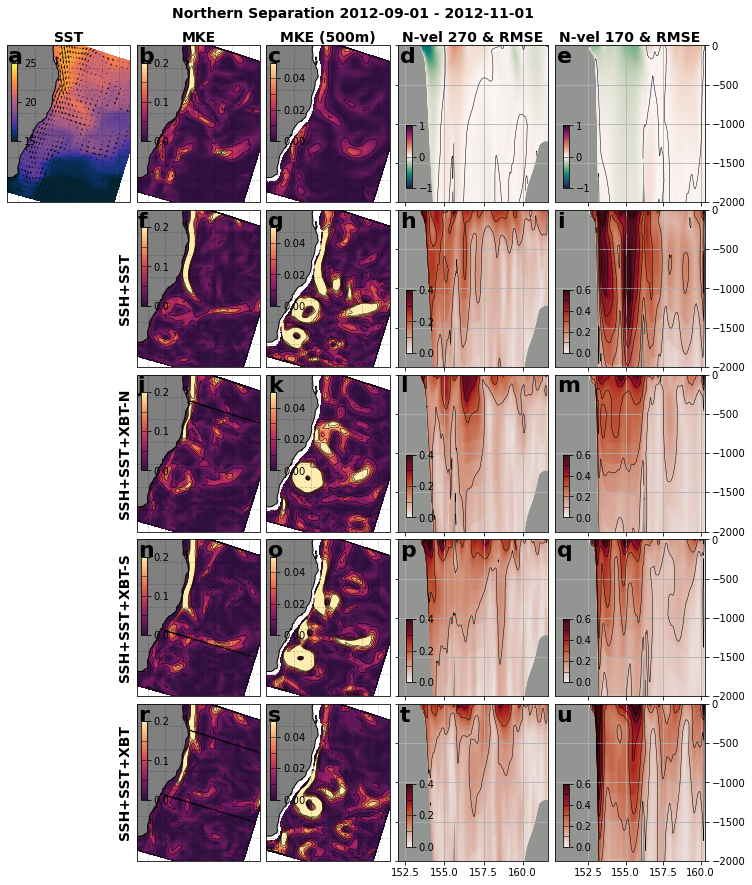

In [27]:
def addSubplot_VerticalTransect(X,Y,input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol])
    ax.set_facecolor('xkcd:grey')
    im = ax.pcolormesh(X,Y,input,shading='gouraud', **pcol_kwargs)
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.05,.09, .8, .8),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    ax.set_ylim([-2000,0])
    cbar = fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.grid()
    return ax, cbar

def addSubplot_spatialMap_pcolor(input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(input.lon_rho,input.lat_rho,input,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
#     cax = inset_axes(ax,
#                  width="5%",  # width = 10% of parent_bbox width
#                  height="50%",  # height : 50%
#                  loc='lower left',
#                  bbox_to_anchor=(.07,.39, 1, 1),
#                  bbox_transform=ax.transAxes,
#                  borderpad=0,
#                  )
#     fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.set_title('')
    return ax

def addSubplot_spatialMap_pcolor_colorbar(input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([149, 160, -40, -26])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(input.lon_rho,input.lat_rho,input,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.03,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    cbar = fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.set_title('')
    return ax,cbar

plt.cla()
plt.clf()
fig = plt.figure(figsize=[12.5,15])
gs0 = fig.add_gridspec(nrows=1,ncols=2,wspace=0.025, hspace=0.05,width_ratios=[1,0.8])
gs00 = gs0[0].subgridspec(5,3, wspace=0.05, hspace=0.05)
gs01 = gs0[1].subgridspec(5,2, wspace=0.05, hspace=0.05)
ax = None

skipRes = 10
skip = dict(eta_rho=slice(None,None,skipRes),xi_rho=slice(None,None,skipRes))


# TRUTH

ax,cbar = addSubplot_spatialMap_pcolor_colorbar(truth_N.temp.isel(s_rho=-1).mean(dim='ocean_time')   ,gs00,0,0,'a',pcol_kwargs={'cmap':'cmo.thermal','vmin':15,'vmax':25})
qu = ax.quiver(truth_N.lon_rho.isel(skip),truth_N.lat_rho.isel(skip),truth_N.u_eastward.isel(skip).isel(s_rho=-1).mean(dim='ocean_time'),truth_N.v_northward.isel(skip).isel(s_rho=-1).mean(dim='ocean_time'),width=0.005,scale=15)
# ax.text(-.2, .5, 'Northern separation',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
# ax.text(-.1, .5, range_N,fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
ax.text(0.5, 1.05, 'SST',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)


# ax,cbar = addSubplot_spatialMap_pcolor_colorbar(truth_N["temp500"].mean(dim='ocean_time')   ,gs,0,1,'f',pcol_kwargs={'cmap':'cmo.thermal','vmin':8,'vmax':13})
# qu = ax.quiver(truth_N.lon_rho.isel(skip),truth_N.lat_rho.isel(skip),truth_N["u500"].isel(skip).mean(dim='ocean_time'),truth_N["v500"].isel(skip).mean(dim='ocean_time'),width=0.005,scale=7.5)
# ax.text(0.5, 1.05, 'Temp (500m)',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)


ax,cbar = addSubplot_spatialMap_pcolor_colorbar(truth_energetics_N.mke.isel(s_rho=-1)  ,gs00,0,1,'b',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.2})
co = truth_energetics_N.mke.isel(s_rho=-1).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.3,0.05),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.text(0.5, 1.05, 'MKE',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.set_title('')

ax,cbar = addSubplot_spatialMap_pcolor_colorbar(truth_energetics_N.mke500  ,gs00,0,2,'c',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.05})
co = truth_energetics_N.mke500.plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.06,0.01),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.text(0.5, 1.05, 'MKE (500m)',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.7, 1.2, ('Northern Separation '+range_N),fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)

# ax,cbar = addSubplot_spatialMap_pcolor_colorbar(truth_energetics_N.eke_0.mean(dim='ocean_time')  ,gs,0,4,'d',pcol_kwargs={'cmap':'cmo.rain_r','vmin':0,'vmax':0.2})
# co = truth_energetics_N.eke_0.mean(dim='ocean_time').plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.4,0.05),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)
# ax.text(0.5, 1.05, 'mean EKE',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax,cbar = addSubplot_VerticalTransect(xx_270,zz_270, truth_N.v_northward.isel(eta_rho=270).mean(dim='ocean_time') ,gs01,0,0,'d',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.curl'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_270,zz_270,truth_N.v_northward.isel(eta_rho=270).mean(dim='ocean_time'),levels=np.arange(-1,.5,1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.text(0.5, 1.05, 'N-vel 270 & RMSE',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax,cbar = addSubplot_VerticalTransect(xx_170,zz_170, truth_N.v_northward.isel(eta_rho=170).mean(dim='ocean_time') ,gs01,0,1,'e',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.curl'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_170,zz_170,truth_N.v_northward.isel(eta_rho=170).mean(dim='ocean_time'),levels=np.arange(-1,.5,1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.text(0.5, 1.05, 'N-vel 170 & RMSE',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.set_xticklabels([])
ax.yaxis.set_ticks_position('right')

# SSH+SST - NORTHERN SEPARATION

ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_energetics_N.mke.isel(s_rho=-1)  ,gs00,1,1,'f',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.2})
co = SSHSST_energetics_N.mke.isel(s_rho=-1).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.25,0.05),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
# ax.text(0.5, 1.05, 'MKE',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.set_title('')
ax.text(-.1, .5, 'SSH+SST',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_energetics_N.mke500  ,gs00,1,2,'g',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.05})
co = SSHSST_energetics_N.mke500.plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.06,0.01),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
# ax.text(0.5, 1.05, 'MKE (500m)',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)

# ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_energetics_N.eke_0-truth_energetics_N.eke_0)**2).mean(dim='ocean_time'))**.5)  ,gs,0,2,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':0.3})
# co = ((((SSHSST_energetics_N.eke_0-truth_energetics_N.eke_0)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.4,0.05),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)
# ax.text(0.5, 1.05, 'EKE RMSE',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)

# ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_N.temp250-truth_N.temp250)**2).mean(dim='ocean_time'))**.5)  ,gs,0,3,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':3})
# co = ((((SSHSST_N.temp250-truth_N.temp250)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,4,1),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)
# ax.text(0.5, 1.05, 'Temp (250m) RMSE',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)


ax,cbar = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_N.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs01,1,0,'h',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_270,zz_270,(((( SSHSST_N.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
# ax.text(0.5, 1.05, 'N-vel 270 RMSE',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax,cbar = addSubplot_VerticalTransect(xx_170,zz_170,((( SSHSST_N.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2),gs01,1,1,'i',pcol_kwargs={'vmin':0,'vmax':0.6,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_170,zz_170,((((SSHSST_N.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.7,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
# ax.text(0.5, 1.05, 'N-vel 170 RMSE',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.set_xticklabels([])
ax.yaxis.set_ticks_position('right')

# ax,cbar = addSubplot_VerticalTransect(xx_80,zz_80,((( SSHSST_N.v_northward.isel(eta_rho=80)-truth_N.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2),gs,0,6,'f',pcol_kwargs={'vmin':0,'vmax':0.5,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
# co = ax.contour(xx_80,zz_80,(((( SSHSST_N.v_northward.isel(eta_rho=80)-truth_N.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)
# ax.text(0.5, 1.05, 'N-vel 80 RMSE',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.set_xticklabels([])
# ax.set_yticklabels([])

# # SSH+SST - SOUTHERN SEPARATION


# ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_energetics_S.mke.isel(s_rho=-1)  ,gs,1,0,'a',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.1})
# co = SSHSST_energetics_S.mke.isel(s_rho=-1).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.1,0.02),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)
# ax.set_title('')
# ax.text(-.2, .5, 'Southern separation',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
# ax.text(-.1, .5, 'SSH+SST',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)

# ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_energetics_S.mke500  ,gs,1,1,'b',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.03})
# co = SSHSST_energetics_S.mke500.plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.04,0.005),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)

# ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_energetics_S.eke_0-truth_energetics_S.eke_0)**2).mean(dim='ocean_time'))**.5)  ,gs,1,2,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':0.3})
# co = ((((SSHSST_energetics_S.eke_0-truth_energetics_S.eke_0)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.4,0.05),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)

# ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_S.temp250-truth_S.temp250)**2).mean(dim='ocean_time'))**.5)  ,gs,1,3,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':3})
# co = ((((SSHSST_S.temp250-truth_S.temp250)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,4,1),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)


# ax,cbar = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_S.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs,1,4,'d',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
# co = ax.contour(xx_270,zz_270,(((( SSHSST_S.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)
# ax.set_xticklabels([])

# ax,cbar = addSubplot_VerticalTransect(xx_170,zz_170,((( SSHSST_S.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2),gs,1,5,'e',pcol_kwargs={'vmin':0,'vmax':0.6,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
# co = ax.contour(xx_170,zz_170,((((SSHSST_S.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.7,.1),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)
# ax.set_xticklabels([])
# ax.set_yticklabels([])

# ax,cbar = addSubplot_VerticalTransect(xx_80,zz_80,((( SSHSST_S.v_northward.isel(eta_rho=80)-truth_S.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2),gs,1,6,'f',pcol_kwargs={'vmin':0,'vmax':0.5,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
# co = ax.contour(xx_80,zz_80,(((( SSHSST_S.v_northward.isel(eta_rho=80)-truth_S.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)
# ax.set_xticklabels([])
# ax.set_yticklabels([])

# XBT-N - NORTHERN SEPARATION

ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_XBT_N_energetics_N.mke.isel(s_rho=-1)  ,gs00,2,1,'j',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.2})
co = SSHSST_XBT_N_energetics_N.mke.isel(s_rho=-1).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.25,0.05),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_title('')
ax.text(-.1, .5, 'SSH+SST+XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
transectEta=255
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
# transectEta=119
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_XBT_N_energetics_N.mke500  ,gs00,2,2,'k',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.05})
co = SSHSST_XBT_N_energetics_N.mke500.plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.06,0.01),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)

# ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_XBT_N_energetics_N.eke_0-truth_energetics_N.eke_0)**2).mean(dim='ocean_time'))**.5)  ,gs,2,2,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':0.3})
# co = ((((SSHSST_XBT_N_energetics_N.eke_0-truth_energetics_N.eke_0)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.4,0.05),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)

# ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_XBT_N_N.temp250-truth_N.temp250)**2).mean(dim='ocean_time'))**.5)  ,gs,2,3,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':3})
# co = ((((SSHSST_XBT_N_N.temp250-truth_N.temp250)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,4,1),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)


ax,cbar = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_XBT_N_N.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs01,2,0,'l',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_270,zz_270,(((( SSHSST_XBT_N_N.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax,cbar = addSubplot_VerticalTransect(xx_170,zz_170,((( SSHSST_XBT_N_N.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2),gs01,2,1,'m',pcol_kwargs={'vmin':0,'vmax':0.6,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_170,zz_170,((((SSHSST_XBT_N_N.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.7,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.yaxis.set_ticks_position('right')

# ax,cbar = addSubplot_VerticalTransect(xx_80,zz_80,((( SSHSST_XBT_N_N.v_northward.isel(eta_rho=80)-truth_N.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2),gs,2,6,'f',pcol_kwargs={'vmin':0,'vmax':0.5,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
# co = ax.contour(xx_80,zz_80,(((( SSHSST_XBT_N_N.v_northward.isel(eta_rho=80)-truth_N.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)
# ax.set_xticklabels([])
# ax.set_yticklabels([])

# # XBT-N - SOUTHERN SEPARATION


# ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_XBT_N_energetics_S.mke.isel(s_rho=-1)  ,gs,3,0,'a',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.1})
# co = SSHSST_XBT_N_energetics_S.mke.isel(s_rho=-1).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.1,0.02),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)
# ax.set_title('')
# ax.text(-.2, .5, 'Southern separation',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
# ax.text(-.1, .5, 'SSH+SST-XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)

# ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_XBT_N_energetics_S.mke500  ,gs,3,1,'b',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.03})
# co = SSHSST_XBT_N_energetics_S.mke500.plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.04,0.005),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)

# ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_XBT_N_energetics_S.eke_0-truth_energetics_S.eke_0)**2).mean(dim='ocean_time'))**.5)  ,gs,3,2,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':0.3})
# co = ((((SSHSST_XBT_N_energetics_S.eke_0-truth_energetics_S.eke_0)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.4,0.05),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)

# ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_XBT_N_S.temp250-truth_S.temp250)**2).mean(dim='ocean_time'))**.5)  ,gs,3,3,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':3})
# co = ((((SSHSST_XBT_N_S.temp250-truth_S.temp250)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,4,1),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)


# ax,cbar = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_XBT_N_S.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs,3,4,'d',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
# co = ax.contour(xx_270,zz_270,(((( SSHSST_XBT_N_S.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)
# ax.set_xticklabels([])

# ax,cbar = addSubplot_VerticalTransect(xx_170,zz_170,((( SSHSST_XBT_N_S.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2),gs,3,5,'e',pcol_kwargs={'vmin':0,'vmax':0.6,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
# co = ax.contour(xx_170,zz_170,((((SSHSST_XBT_N_S.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.7,.1),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)
# ax.set_xticklabels([])
# ax.set_yticklabels([])

# ax,cbar = addSubplot_VerticalTransect(xx_80,zz_80,((( SSHSST_XBT_N_S.v_northward.isel(eta_rho=80)-truth_S.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2),gs,3,6,'f',pcol_kwargs={'vmin':0,'vmax':0.5,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
# co = ax.contour(xx_80,zz_80,(((( SSHSST_XBT_N_S.v_northward.isel(eta_rho=80)-truth_S.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)
# ax.set_xticklabels([])
# ax.set_yticklabels([])


# XBT-S - NORTHERN SEPARATION

ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_XBT_S_energetics_N.mke.isel(s_rho=-1)  ,gs00,3,1,'n',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.2})
co = SSHSST_XBT_S_energetics_N.mke.isel(s_rho=-1).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.25,0.05),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_title('')
ax.text(-.1, .5, 'SSH+SST+XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
# transectEta=255
# xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
# ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
transectEta=119
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_XBT_S_energetics_N.mke500  ,gs00,3,2,'o',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.05})
co = SSHSST_XBT_S_energetics_N.mke500.plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.06,0.01),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)

# ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_XBT_S_energetics_N.eke_0-truth_energetics_N.eke_0)**2).mean(dim='ocean_time'))**.5)  ,gs,4,2,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':0.3})
# co = ((((SSHSST_XBT_S_energetics_N.eke_0-truth_energetics_N.eke_0)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.4,0.05),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)

# ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_XBT_S_N.temp250-truth_N.temp250)**2).mean(dim='ocean_time'))**.5)  ,gs,4,3,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':3})
# co = ((((SSHSST_XBT_S_N.temp250-truth_N.temp250)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,4,1),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)


ax,cbar = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_XBT_S_N.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs01,3,0,'p',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_270,zz_270,(((( SSHSST_XBT_S_N.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax,cbar = addSubplot_VerticalTransect(xx_170,zz_170,((( SSHSST_XBT_S_N.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2),gs01,3,1,'q',pcol_kwargs={'vmin':0,'vmax':0.6,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_170,zz_170,((((SSHSST_XBT_S_N.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.7,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.yaxis.set_ticks_position('right')

# ax,cbar = addSubplot_VerticalTransect(xx_80,zz_80,((( SSHSST_XBT_S_N.v_northward.isel(eta_rho=80)-truth_N.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2),gs,4,6,'f',pcol_kwargs={'vmin':0,'vmax':0.5,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
# co = ax.contour(xx_80,zz_80,(((( SSHSST_XBT_S_N.v_northward.isel(eta_rho=80)-truth_N.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)
# ax.set_xticklabels([])
# ax.set_yticklabels([])

# # XBT-S - SOUTHERN SEPARATION


# ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_XBT_S_energetics_S.mke.isel(s_rho=-1)  ,gs,5,0,'a',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.1})
# co = SSHSST_XBT_S_energetics_S.mke.isel(s_rho=-1).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.1,0.02),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)
# ax.set_title('')
# ax.text(-.2, .5, 'Southern separation',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
# ax.text(-.1, .5, 'SSH+SST-XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)

# ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_XBT_S_energetics_S.mke500  ,gs,5,1,'b',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.03})
# co = SSHSST_XBT_S_energetics_S.mke500.plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.04,0.005),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)

# ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_XBT_S_energetics_S.eke_0-truth_energetics_S.eke_0)**2).mean(dim='ocean_time'))**.5)  ,gs,5,2,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':0.3})
# co = ((((SSHSST_XBT_S_energetics_S.eke_0-truth_energetics_S.eke_0)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.4,0.05),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)

# ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_XBT_S_S.temp250-truth_S.temp250)**2).mean(dim='ocean_time'))**.5)  ,gs,5,3,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':3})
# co = ((((SSHSST_XBT_S_S.temp250-truth_S.temp250)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,4,1),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)


# ax,cbar = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_XBT_S_S.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs,5,4,'d',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
# co = ax.contour(xx_270,zz_270,(((( SSHSST_XBT_S_S.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)
# ax.set_xticklabels([])

# ax,cbar = addSubplot_VerticalTransect(xx_170,zz_170,((( SSHSST_XBT_S_S.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2),gs,5,5,'e',pcol_kwargs={'vmin':0,'vmax':0.6,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
# co = ax.contour(xx_170,zz_170,((((SSHSST_XBT_S_S.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.7,.1),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)
# ax.set_xticklabels([])
# ax.set_yticklabels([])

# ax,cbar = addSubplot_VerticalTransect(xx_80,zz_80,((( SSHSST_XBT_S_S.v_northward.isel(eta_rho=80)-truth_S.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2),gs,5,6,'f',pcol_kwargs={'vmin':0,'vmax':0.5,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
# co = ax.contour(xx_80,zz_80,(((( SSHSST_XBT_S_S.v_northward.isel(eta_rho=80)-truth_S.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)
# ax.set_xticklabels([])
# ax.set_yticklabels([])


# XBT - NORTHERN SEPARATION

ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_XBT_energetics_N.mke.isel(s_rho=-1)  ,gs00,4,1,'r',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.2})
co = SSHSST_XBT_energetics_N.mke.isel(s_rho=-1).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.25,0.05),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_title('')
ax.text(-.1, .5, 'SSH+SST+XBT',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
transectEta=255
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
transectEta=119
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)

ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_XBT_energetics_N.mke500  ,gs00,4,2,'s',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.05})
co = SSHSST_XBT_energetics_N.mke500.plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.06,0.01),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)

# ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_XBT_energetics_N.eke_0-truth_energetics_N.eke_0)**2).mean(dim='ocean_time'))**.5)  ,gs,6,2,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':0.3})
# co = ((((SSHSST_XBT_energetics_N.eke_0-truth_energetics_N.eke_0)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.4,0.05),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)

# ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_XBT_N1.temp250-truth_N.temp250)**2).mean(dim='ocean_time'))**.5)  ,gs,6,3,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':3})
# co = ((((SSHSST_XBT_N1.temp250-truth_N.temp250)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,4,1),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)


ax,cbar = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_XBT_N1.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs01,4,0,'t',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_270,zz_270,(((( SSHSST_XBT_N1.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
# ax.set_xticklabels([])
ax.set_yticklabels([])

ax,cbar = addSubplot_VerticalTransect(xx_170,zz_170,((( SSHSST_XBT_N1.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2),gs01,4,1,'u',pcol_kwargs={'vmin':0,'vmax':0.6,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_170,zz_170,((((SSHSST_XBT_N1.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.7,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
# ax.set_xticklabels([])
ax.yaxis.set_ticks_position('right')

# ax,cbar = addSubplot_VerticalTransect(xx_80,zz_80,((( SSHSST_XBT_N1.v_northward.isel(eta_rho=80)-truth_N.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2),gs,6,6,'f',pcol_kwargs={'vmin':0,'vmax':0.5,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
# co = ax.contour(xx_80,zz_80,(((( SSHSST_XBT_N1.v_northward.isel(eta_rho=80)-truth_N.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)
# ax.set_xticklabels([])
# ax.set_yticklabels([])

# # XBT - SOUTHERN SEPARATION


# ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_XBT_energetics_S.mke.isel(s_rho=-1)  ,gs,7,0,'a',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.1})
# co = SSHSST_XBT_energetics_S.mke.isel(s_rho=-1).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.1,0.02),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)
# ax.set_title('')
# ax.text(-.2, .5, 'Southern separation',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
# ax.text(-.1, .5, 'SSH+SST-XBT',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)

# ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_XBT_energetics_S.mke500  ,gs,7,1,'b',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.03})
# co = SSHSST_XBT_energetics_S.mke500.plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.04,0.005),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)

# ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_XBT_energetics_S.eke_0-truth_energetics_S.eke_0)**2).mean(dim='ocean_time'))**.5)  ,gs,7,2,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':0.3})
# co = ((((SSHSST_XBT_energetics_S.eke_0-truth_energetics_S.eke_0)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.4,0.05),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)
# ax.text(.05, .05, str(np.round(calc_areaAverageROMS((((((SSHSST_XBT_energetics_S.eke_0-truth_energetics_S.eke_0)**2).mean(dim='ocean_time'))**.5)),truth_bu).values,2))+' $m^2/s^2$' ,fontsize=10, va='center', ha='left', transform=ax.transAxes)


# ax,cbar = addSubplot_spatialMap_pcolor_colorbar( ((((SSHSST_XBT_S1.temp250-truth_S.temp250)**2).mean(dim='ocean_time'))**.5)  ,gs,7,3,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':3})
# co = ((((SSHSST_XBT_S1.temp250-truth_S.temp250)**2).mean(dim='ocean_time'))**.5).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,4,1),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)
# ax.text(.05, .05, str(np.round(calc_areaAverageROMS((((((SSHSST_XBT_S1.temp250-truth_S.temp250)**2).mean(dim='ocean_time'))**.5)),truth_bu).values,2))+' $\circ C$' ,fontsize=10, va='center', ha='left', transform=ax.transAxes)


# ax,cbar = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_XBT_S1.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs,7,4,'d',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
# co = ax.contour(xx_270,zz_270,(((( SSHSST_XBT_S1.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)
# ax.set_xticklabels([])
# ax.text(.05, .05, str(np.round(calc_depthAverageROMS2((((SSHSST_XBT_S1.v_northward.where(zz_270>-2000)-truth_S.v_northward.where(zz_270>-2000)**2).mean(dim='ocean_time'))**.5),SSHSST_XBT_S1.dx,SSHSST_XBT_S1.dz0,270).values,3))+' $m/s$' ,fontsize=10, va='center', ha='left', transform=ax.transAxes)
        
# ax,cbar = addSubplot_VerticalTransect(xx_170,zz_170,((( SSHSST_XBT_S1.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2),gs,7,5,'e',pcol_kwargs={'vmin':0,'vmax':0.6,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
# co = ax.contour(xx_170,zz_170,((((SSHSST_XBT_S1.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.7,.1),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.text(.05, .05, str(np.round(calc_depthAverageROMS2((((SSHSST_XBT_S1.v_northward.where(zz_170>-2000)-truth_S.v_northward.where(zz_170>-2000)**2).mean(dim='ocean_time'))**.5),SSHSST_XBT_S1.dx,SSHSST_XBT_S1.dz0,170).values,3))+' $m/s$' ,fontsize=10, va='center', ha='left', transform=ax.transAxes)

# ax,cbar = addSubplot_VerticalTransect(xx_80,zz_80,((( SSHSST_XBT_S1.v_northward.isel(eta_rho=80)-truth_S.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2),gs,7,6,'f',pcol_kwargs={'vmin':0,'vmax':0.5,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
# co = ax.contour(xx_80,zz_80,(((( SSHSST_XBT_S1.v_northward.isel(eta_rho=80)-truth_S.v_northward.isel(eta_rho=80) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.text(.05, .05, str(np.round(calc_depthAverageROMS2((((SSHSST_XBT_S1.v_northward.where(zz_80>-2000)-truth_S.v_northward.where(zz_80>-2000)**2).mean(dim='ocean_time'))**.5),SSHSST_XBT_S1.dx,SSHSST_XBT_S1.dz0,80).values,3))+' $m/s$' ,fontsize=10, va='center', ha='left', transform=ax.transAxes)






[Text(152.5, 0, '152.5$^o$E'),
 Text(155.0, 0, '155$^o$E'),
 Text(157.5, 0, '157.5$^o$E'),
 Text(160.0, 0, '160$^o$E')]

<Figure size 432x288 with 0 Axes>

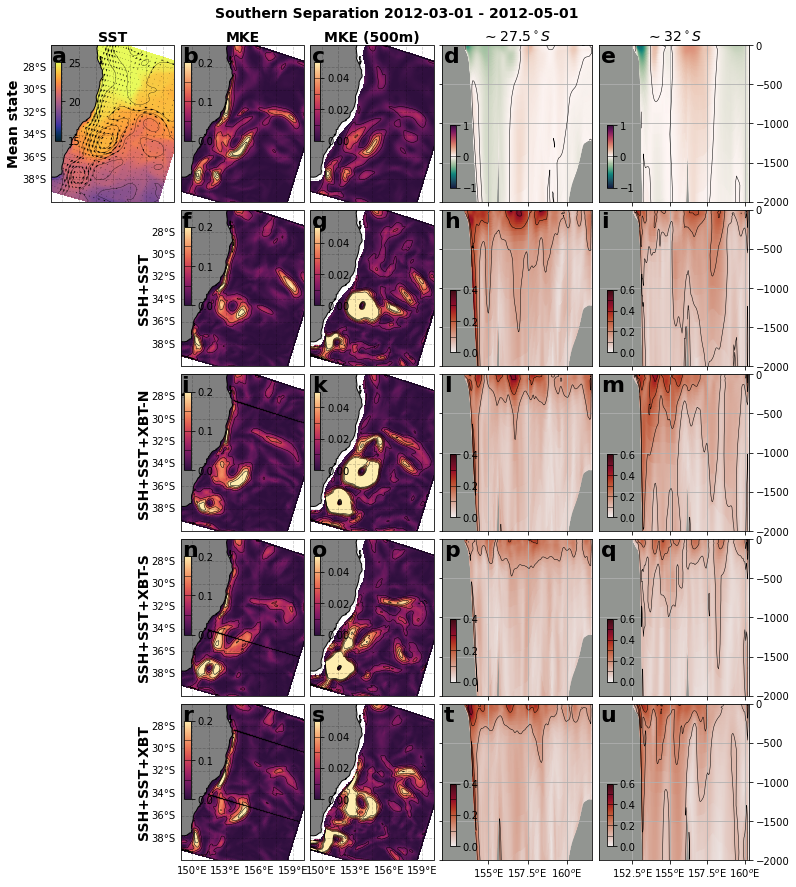

In [28]:
def addSubplot_VerticalTransect(X,Y,input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol])
    ax.set_facecolor('xkcd:grey')
    im = ax.pcolormesh(X,Y,input,shading='gouraud', **pcol_kwargs)
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.05,.09, .8, .8),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    ax.set_ylim([-2000,0])
    cbar = fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.grid()
    return ax, cbar

def addSubplot_spatialMap_pcolor(input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(input.lon_rho,input.lat_rho,input,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
#     cax = inset_axes(ax,
#                  width="5%",  # width = 10% of parent_bbox width
#                  height="50%",  # height : 50%
#                  loc='lower left',
#                  bbox_to_anchor=(.07,.39, 1, 1),
#                  bbox_transform=ax.transAxes,
#                  borderpad=0,
#                  )
#     fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.set_title('')
    return ax

def addSubplot_spatialMap_pcolor_colorbar(input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([149, 160, -40, -26])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(input.lon_rho,input.lat_rho,input,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.03,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    cbar = fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.set_title('')
    return ax,cbar

def addSubplot_spatialMap_pcolor_colorbar_label(input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([149, 160, -40, -26])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(input.lon_rho,input.lat_rho,input,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.03,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    cbar = fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.set_title('')
    return ax,cbar,gl

plt.cla()
plt.clf()
fig = plt.figure(figsize=[12.5,15])
gs0 = fig.add_gridspec(nrows=1,ncols=2,wspace=0.025, hspace=0.05,width_ratios=[1,0.8])
gs00 = gs0[0].subgridspec(5,3, wspace=0.05, hspace=0.05)
gs01 = gs0[1].subgridspec(5,2, wspace=0.05, hspace=0.05)
ax = None



skipRes = 10
skip = dict(eta_rho=slice(None,None,skipRes),xi_rho=slice(None,None,skipRes))


# TRUTH

ax,cbar,gl = addSubplot_spatialMap_pcolor_colorbar_label(truth_S.temp.isel(s_rho=-1).mean(dim='ocean_time')   ,gs00,0,0,'a',pcol_kwargs={'cmap':'cmo.thermal','vmin':15,'vmax':25})
qu = ax.quiver(truth_S.lon_rho.isel(skip),truth_S.lat_rho.isel(skip),truth_S.u_eastward.isel(skip).isel(s_rho=-1).mean(dim='ocean_time'),truth_S.v_northward.isel(skip).isel(s_rho=-1).mean(dim='ocean_time'),width=0.005,scale=15)
ax.contour(truth_S.lon_rho,truth_S.lat_rho,truth_S.zeta.mean(dim='ocean_time'),colors='black',linewidths=0.3)
# ax.text(-.2, .5, 'Southern separation',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
# ax.text(-.1, .5, range_S,fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
ax.text(0.5, 1.05, 'SST',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(-.3, .5, 'Mean state',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
gl.left_labels=True


ax,cbar = addSubplot_spatialMap_pcolor_colorbar(truth_energetics_S.mke.isel(s_rho=-1)  ,gs00,0,1,'b',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.2})
co = truth_energetics_S.mke.isel(s_rho=-1).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.3,0.05),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.text(0.5, 1.05, 'MKE',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.set_title('')

ax,cbar = addSubplot_spatialMap_pcolor_colorbar(truth_energetics_S.mke500  ,gs00,0,2,'c',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.05})
co = truth_energetics_S.mke500.plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.06,0.01),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.text(0.5, 1.05, 'MKE (500m)',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.7, 1.2, ('Southern Separation '+range_S),fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax,cbar = addSubplot_VerticalTransect(xx_270,zz_270, truth_S.v_northward.isel(eta_rho=270).mean(dim='ocean_time') ,gs01,0,0,'d',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.curl'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_270,zz_270,truth_S.v_northward.isel(eta_rho=270).mean(dim='ocean_time'),levels=np.arange(-1,.5,1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.text(0.5, 1.05, '$\sim27.5^\circ S$',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([155,157.5,160])

ax,cbar = addSubplot_VerticalTransect(xx_170,zz_170, truth_S.v_northward.isel(eta_rho=170).mean(dim='ocean_time') ,gs01,0,1,'e',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.curl'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_170,zz_170,truth_S.v_northward.isel(eta_rho=170).mean(dim='ocean_time'),levels=np.arange(-1,.5,1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.text(0.5, 1.05, '$\sim32^\circ S$',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.set_xticklabels([])
ax.yaxis.set_ticks_position('right')

# SSH+SST - SOUTHERN SEPARATION

ax,cbar,gl = addSubplot_spatialMap_pcolor_colorbar_label(SSHSST_energetics_S.mke.isel(s_rho=-1)  ,gs00,1,1,'f',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.2})
co = SSHSST_energetics_S.mke.isel(s_rho=-1).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.25,0.05),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
# ax.text(0.5, 1.05, 'MKE',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.set_title('')
ax.text(-.3, .5, 'SSH+SST',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
gl.left_labels=True

ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_energetics_S.mke500  ,gs00,1,2,'g',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.05})
co = SSHSST_energetics_S.mke500.plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.06,0.01),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)

ax,cbar = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_S.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs01,1,0,'h',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_270,zz_270,(((( SSHSST_S.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
# ax.text(0.5, 1.05, 'N-vel 270 RMSE',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([155,157.5,160])

ax,cbar = addSubplot_VerticalTransect(xx_170,zz_170,((( SSHSST_S.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2),gs01,1,1,'i',pcol_kwargs={'vmin':0,'vmax':0.6,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_170,zz_170,((((SSHSST_S.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.7,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
# ax.text(0.5, 1.05, 'N-vel 170 RMSE',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.set_xticklabels([])
ax.yaxis.set_ticks_position('right')


# XBT-N - SOUTHERN SEPARATION

ax,cbar,gl = addSubplot_spatialMap_pcolor_colorbar_label(SSHSST_XBT_N_energetics_S.mke.isel(s_rho=-1)  ,gs00,2,1,'j',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.2})
co = SSHSST_XBT_N_energetics_S.mke.isel(s_rho=-1).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.25,0.05),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_title('')
ax.text(-.3, .5, 'SSH+SST+XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
transectEta=255
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
gl.left_labels=True


ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_XBT_N_energetics_S.mke500  ,gs00,2,2,'k',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.05})
co = SSHSST_XBT_N_energetics_S.mke500.plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.06,0.01),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)



ax,cbar = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_XBT_N_S.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs01,2,0,'l',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_270,zz_270,(((( SSHSST_XBT_N_S.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([155,157.5,160])

ax,cbar = addSubplot_VerticalTransect(xx_170,zz_170,((( SSHSST_XBT_N_S.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2),gs01,2,1,'m',pcol_kwargs={'vmin':0,'vmax':0.6,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_170,zz_170,((((SSHSST_XBT_N_S.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.7,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.yaxis.set_ticks_position('right')

# XBT-S - SOUTHERN SEPARATION

ax,cbar,gl = addSubplot_spatialMap_pcolor_colorbar_label(SSHSST_XBT_S_energetics_S.mke.isel(s_rho=-1)  ,gs00,3,1,'n',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.2})
co = SSHSST_XBT_S_energetics_S.mke.isel(s_rho=-1).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.25,0.05),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_title('')
ax.text(-.3, .5, 'SSH+SST+XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
transectEta=119
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
gl.left_labels=True

ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_XBT_S_energetics_S.mke500  ,gs00,3,2,'o',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.05})
co = SSHSST_XBT_S_energetics_S.mke500.plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.06,0.01),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)


ax,cbar = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_XBT_S_S.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs01,3,0,'p',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_270,zz_270,(((( SSHSST_XBT_S_S.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([155,157.5,160])

ax,cbar = addSubplot_VerticalTransect(xx_170,zz_170,((( SSHSST_XBT_S_S.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2),gs01,3,1,'q',pcol_kwargs={'vmin':0,'vmax':0.6,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_170,zz_170,((((SSHSST_XBT_S_S.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.7,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.yaxis.set_ticks_position('right')


# XBT - SOUTHERN SEPARATION

ax,cbar,gl = addSubplot_spatialMap_pcolor_colorbar_label(SSHSST_XBT_energetics_S.mke.isel(s_rho=-1)  ,gs00,4,1,'r',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.2})
co = SSHSST_XBT_energetics_S.mke.isel(s_rho=-1).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.25,0.05),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_title('')
ax.text(-.3, .5, 'SSH+SST+XBT',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
transectEta=255
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
transectEta=119
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
gl.left_labels=True
gl.bottom_labels=True

ax,cbar,gl = addSubplot_spatialMap_pcolor_colorbar_label(SSHSST_XBT_energetics_S.mke500  ,gs00,4,2,'s',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.05})
co = SSHSST_XBT_energetics_S.mke500.plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.06,0.01),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
gl.bottom_labels=True

ax,cbar = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_XBT_S1.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs01,4,0,'t',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_270,zz_270,(((( SSHSST_XBT_S1.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
# ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([155,157.5,160])
labels = ['155$^o$E', '157.5$^o$E', '160$^o$E']
ax.set_xticklabels(labels)

ax,cbar = addSubplot_VerticalTransect(xx_170,zz_170,((( SSHSST_XBT_S1.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2),gs01,4,1,'u',pcol_kwargs={'vmin':0,'vmax':0.6,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_170,zz_170,((((SSHSST_XBT_S1.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.7,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
# ax.set_xticklabels([])
ax.yaxis.set_ticks_position('right')
ax.set_xticks([152.5,155,157.5,160])
labels = ['152.5$^o$E', '155$^o$E', '157.5$^o$E', '160$^o$E']
ax.set_xticklabels(labels)




[Text(152.5, 0, '152.5$^o$E'),
 Text(155.0, 0, '155$^o$E'),
 Text(157.5, 0, '157.5$^o$E'),
 Text(160.0, 0, '160$^o$E')]

<Figure size 432x288 with 0 Axes>

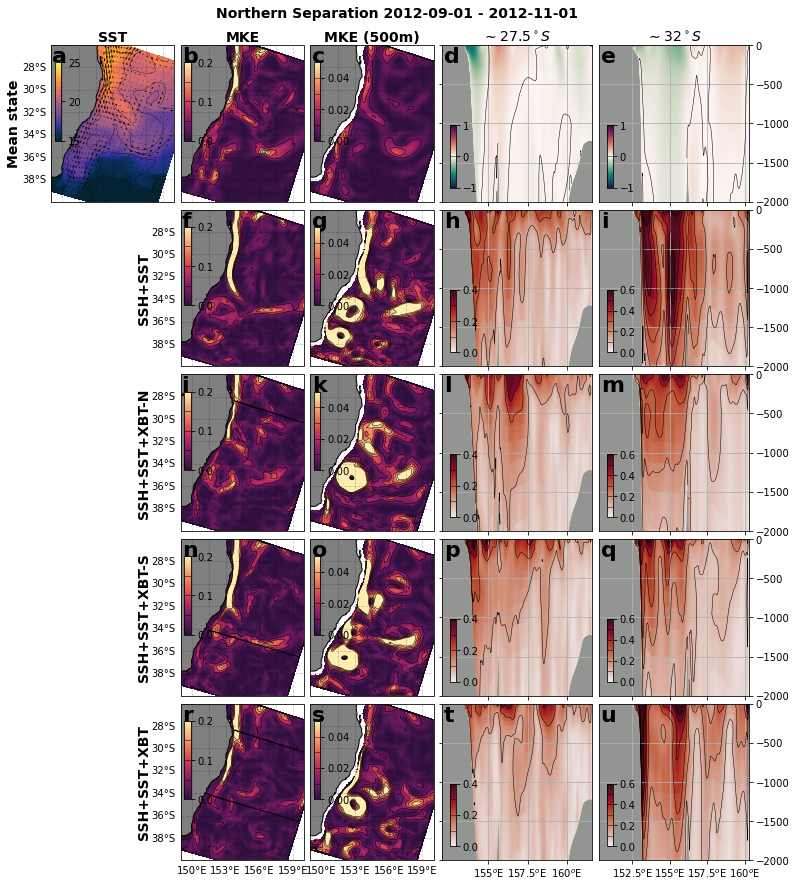

In [29]:
def addSubplot_VerticalTransect(X,Y,input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol])
    ax.set_facecolor('xkcd:grey')
    im = ax.pcolormesh(X,Y,input,shading='gouraud', **pcol_kwargs)
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.05,.09, .8, .8),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    ax.set_ylim([-2000,0])
    cbar = fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.grid()
    return ax, cbar

def addSubplot_spatialMap_pcolor(input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(input.lon_rho,input.lat_rho,input,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
#     cax = inset_axes(ax,
#                  width="5%",  # width = 10% of parent_bbox width
#                  height="50%",  # height : 50%
#                  loc='lower left',
#                  bbox_to_anchor=(.07,.39, 1, 1),
#                  bbox_transform=ax.transAxes,
#                  borderpad=0,
#                  )
#     fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.set_title('')
    return ax

def addSubplot_spatialMap_pcolor_colorbar(input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([149, 160, -40, -26])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(input.lon_rho,input.lat_rho,input,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.03,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    cbar = fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.set_title('')
    return ax,cbar

def addSubplot_spatialMap_pcolor_colorbar_label(input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([149, 160, -40, -26])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(input.lon_rho,input.lat_rho,input,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.03,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    cbar = fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.set_title('')
    return ax,cbar,gl

plt.cla()
plt.clf()
fig = plt.figure(figsize=[12.5,15])
gs0 = fig.add_gridspec(nrows=1,ncols=2,wspace=0.025, hspace=0.05,width_ratios=[1,0.8])
gs00 = gs0[0].subgridspec(5,3, wspace=0.05, hspace=0.05)
gs01 = gs0[1].subgridspec(5,2, wspace=0.05, hspace=0.05)
ax = None



skipRes = 10
skip = dict(eta_rho=slice(None,None,skipRes),xi_rho=slice(None,None,skipRes))


# TRUTH

ax,cbar,gl = addSubplot_spatialMap_pcolor_colorbar_label(truth_N.temp.isel(s_rho=-1).mean(dim='ocean_time')   ,gs00,0,0,'a',pcol_kwargs={'cmap':'cmo.thermal','vmin':15,'vmax':25})
qu = ax.quiver(truth_N.lon_rho.isel(skip),truth_N.lat_rho.isel(skip),truth_N.u_eastward.isel(skip).isel(s_rho=-1).mean(dim='ocean_time'),truth_N.v_northward.isel(skip).isel(s_rho=-1).mean(dim='ocean_time'),width=0.005,scale=15)
ax.contour(truth_N.lon_rho,truth_N.lat_rho,truth_N.zeta.mean(dim='ocean_time'),colors='black',linewidths=0.3)
# ax.text(-.2, .5, 'Southern separation',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
# ax.text(-.1, .5, range_N,fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
ax.text(0.5, 1.05, 'SST',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(-.3, .5, 'Mean state',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
gl.left_labels=True


ax,cbar = addSubplot_spatialMap_pcolor_colorbar(truth_energetics_N.mke.isel(s_rho=-1)  ,gs00,0,1,'b',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.2})
co = truth_energetics_N.mke.isel(s_rho=-1).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.3,0.05),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.text(0.5, 1.05, 'MKE',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.set_title('')

ax,cbar = addSubplot_spatialMap_pcolor_colorbar(truth_energetics_N.mke500  ,gs00,0,2,'c',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.05})
co = truth_energetics_N.mke500.plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.06,0.01),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.text(0.5, 1.05, 'MKE (500m)',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.7, 1.2, ('Northern Separation '+range_N),fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax,cbar = addSubplot_VerticalTransect(xx_270,zz_270, truth_N.v_northward.isel(eta_rho=270).mean(dim='ocean_time') ,gs01,0,0,'d',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.curl'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_270,zz_270,truth_N.v_northward.isel(eta_rho=270).mean(dim='ocean_time'),levels=np.arange(-1,.5,1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.text(0.5, 1.05, '$\sim27.5^\circ S$',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([155,157.5,160])

ax,cbar = addSubplot_VerticalTransect(xx_170,zz_170, truth_N.v_northward.isel(eta_rho=170).mean(dim='ocean_time') ,gs01,0,1,'e',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.curl'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_170,zz_170,truth_N.v_northward.isel(eta_rho=170).mean(dim='ocean_time'),levels=np.arange(-1,.5,1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.text(0.5, 1.05, '$\sim32^\circ S$',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.set_xticklabels([])
ax.yaxis.set_ticks_position('right')

# SSH+SST - SOUTHERN SEPARATION

ax,cbar,gl = addSubplot_spatialMap_pcolor_colorbar_label(SSHSST_energetics_N.mke.isel(s_rho=-1)  ,gs00,1,1,'f',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.2})
co = SSHSST_energetics_N.mke.isel(s_rho=-1).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.25,0.05),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
# ax.text(0.5, 1.05, 'MKE',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.set_title('')
ax.text(-.3, .5, 'SSH+SST',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
gl.left_labels=True

ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_energetics_N.mke500  ,gs00,1,2,'g',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.05})
co = SSHSST_energetics_N.mke500.plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.06,0.01),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)

ax,cbar = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_N.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs01,1,0,'h',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_270,zz_270,(((( SSHSST_N.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
# ax.text(0.5, 1.05, 'N-vel 270 RMSE',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([155,157.5,160])

ax,cbar = addSubplot_VerticalTransect(xx_170,zz_170,((( SSHSST_N.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2),gs01,1,1,'i',pcol_kwargs={'vmin':0,'vmax':0.6,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_170,zz_170,((((SSHSST_N.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.7,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
# ax.text(0.5, 1.05, 'N-vel 170 RMSE',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.set_xticklabels([])
ax.yaxis.set_ticks_position('right')


# XBT-N - SOUTHERN SEPARATION

ax,cbar,gl = addSubplot_spatialMap_pcolor_colorbar_label(SSHSST_XBT_N_energetics_N.mke.isel(s_rho=-1)  ,gs00,2,1,'j',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.2})
co = SSHSST_XBT_N_energetics_N.mke.isel(s_rho=-1).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.25,0.05),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_title('')
ax.text(-.3, .5, 'SSH+SST+XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
transectEta=255
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
gl.left_labels=True


ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_XBT_N_energetics_N.mke500  ,gs00,2,2,'k',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.05})
co = SSHSST_XBT_N_energetics_N.mke500.plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.06,0.01),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)



ax,cbar = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_XBT_N_N.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs01,2,0,'l',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_270,zz_270,(((( SSHSST_XBT_N_N.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([155,157.5,160])

ax,cbar = addSubplot_VerticalTransect(xx_170,zz_170,((( SSHSST_XBT_N_N.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2),gs01,2,1,'m',pcol_kwargs={'vmin':0,'vmax':0.6,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_170,zz_170,((((SSHSST_XBT_N_N.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.7,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.yaxis.set_ticks_position('right')

# XBT-S - SOUTHERN SEPARATION

ax,cbar,gl = addSubplot_spatialMap_pcolor_colorbar_label(SSHSST_XBT_S_energetics_N.mke.isel(s_rho=-1)  ,gs00,3,1,'n',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.2})
co = SSHSST_XBT_S_energetics_N.mke.isel(s_rho=-1).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.25,0.05),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_title('')
ax.text(-.3, .5, 'SSH+SST+XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
transectEta=119
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
gl.left_labels=True

ax,cbar = addSubplot_spatialMap_pcolor_colorbar(SSHSST_XBT_S_energetics_N.mke500  ,gs00,3,2,'o',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.05})
co = SSHSST_XBT_S_energetics_N.mke500.plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.06,0.01),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)


ax,cbar = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_XBT_S_N.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs01,3,0,'p',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_270,zz_270,(((( SSHSST_XBT_S_N.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([155,157.5,160])

ax,cbar = addSubplot_VerticalTransect(xx_170,zz_170,((( SSHSST_XBT_S_N.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2),gs01,3,1,'q',pcol_kwargs={'vmin':0,'vmax':0.6,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_170,zz_170,((((SSHSST_XBT_S_N.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.7,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_xticklabels([])
ax.yaxis.set_ticks_position('right')


# XBT - SOUTHERN SEPARATION

ax,cbar,gl = addSubplot_spatialMap_pcolor_colorbar_label(SSHSST_XBT_energetics_N.mke.isel(s_rho=-1)  ,gs00,4,1,'r',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.2})
co = SSHSST_XBT_energetics_N.mke.isel(s_rho=-1).plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.25,0.05),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax.set_title('')
ax.text(-.3, .5, 'SSH+SST+XBT',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
transectEta=255
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
transectEta=119
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=0.5,zorder=12)
gl.left_labels=True
gl.bottom_labels=True

ax,cbar,gl = addSubplot_spatialMap_pcolor_colorbar_label(SSHSST_XBT_energetics_N.mke500  ,gs00,4,2,'s',pcol_kwargs={'cmap':'cmo.matter_r','vmin':0,'vmax':0.05})
co = SSHSST_XBT_energetics_N.mke500.plot.contour(ax=ax, x='lon_rho',y='lat_rho',levels=np.arange(0,0.06,0.01),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
gl.bottom_labels=True

ax,cbar = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_XBT_N1.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs01,4,0,'t',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_270,zz_270,(((( SSHSST_XBT_N1.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
# ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([155,157.5,160])
labels = ['155$^o$E', '157.5$^o$E', '160$^o$E']
ax.set_xticklabels(labels)

ax,cbar = addSubplot_VerticalTransect(xx_170,zz_170,((( SSHSST_XBT_N1.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2),gs01,4,1,'u',pcol_kwargs={'vmin':0,'vmax':0.6,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax.contour(xx_170,zz_170,((((SSHSST_XBT_N1.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.7,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
# ax.set_xticklabels([])
ax.yaxis.set_ticks_position('right')
ax.set_xticks([152.5,155,157.5,160])
labels = ['152.5$^o$E', '155$^o$E', '157.5$^o$E', '160$^o$E']
ax.set_xticklabels(labels)




<Figure size 432x288 with 0 Axes>

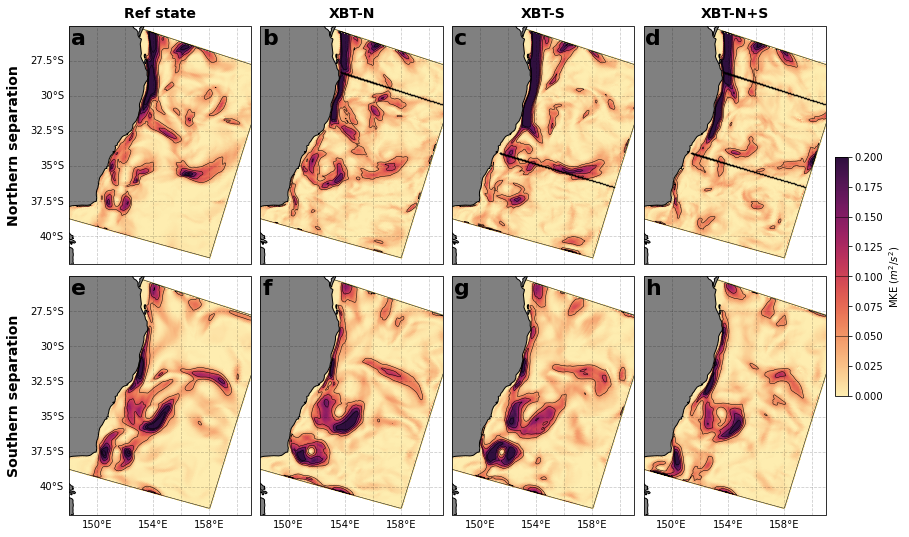

In [30]:

def addSubplot_spatialMap(input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(input.lon_rho,input.lat_rho,input,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.set_title('')
    return ax,gl,im

def addSubplot_spatialMap_colorbar(input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(input.lon_rho,input.lat_rho,input,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.05,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    cbar = fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.set_title('')
    return ax,gl,im,cbar

plt.cla()
plt.clf()
fig = plt.figure(figsize=[17,9])
gs = fig.add_gridspec(nrows=2,ncols=5,wspace=0.05, hspace=0.05)

ax = None

# TRUTH


ax = addSubplot_spatialMap(truth_energetics_N.mke.isel(s_rho=-1)  ,gs,0,0,'a',pcol_kwargs={'cmap':'cmo.matter','vmin':0,'vmax':0.2})
co = truth_energetics_N.mke.isel(s_rho=-1).plot.contour(ax=ax[0], x='lon_rho',y='lat_rho',levels=np.arange(0,0.3,0.05),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax[0].text(0.5, 1.05, 'Ref state',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax[0].transAxes)
ax[0].text(-.3, .5, 'Northern separation',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax[0].transAxes)
ax[0].set_title('')
ax[1].left_labels=True

# ax = addSubplot_spatialMap(SSHSST_energetics_N.mke.isel(s_rho=-1)  ,gs,0,1,'b',pcol_kwargs={'cmap':'cmo.matter','vmin':0,'vmax':0.2})
# co = SSHSST_energetics_N.mke.isel(s_rho=-1).plot.contour(ax=ax[0], x='lon_rho',y='lat_rho',levels=np.arange(0,0.25,0.05),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)
# ax[0].set_title('')
# ax[0].text(0.5, 1.05, 'SSH+SST',fontsize=14, fontweight='bold', va='center', ha='center', rotation='horizontal', transform=ax[0].transAxes)

ax = addSubplot_spatialMap(SSHSST_XBT_N_energetics_N.mke.isel(s_rho=-1)  ,gs,0,1,'b',pcol_kwargs={'cmap':'cmo.matter','vmin':0,'vmax':0.2})
co = SSHSST_XBT_N_energetics_N.mke.isel(s_rho=-1).plot.contour(ax=ax[0], x='lon_rho',y='lat_rho',levels=np.arange(0,0.25,0.05),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax[0].set_title('')
ax[0].text(0.5, 1.05, 'XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', rotation='horizontal', transform=ax[0].transAxes)
transectEta=255
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax[0].plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)


ax = addSubplot_spatialMap(SSHSST_XBT_S_energetics_N.mke.isel(s_rho=-1)  ,gs,0,2,'c',pcol_kwargs={'cmap':'cmo.matter','vmin':0,'vmax':0.2})
co = SSHSST_XBT_S_energetics_N.mke.isel(s_rho=-1).plot.contour(ax=ax[0], x='lon_rho',y='lat_rho',levels=np.arange(0,0.25,0.05),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax[0].set_title('')
ax[0].text(0.5, 1.05, 'XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', rotation='horizontal', transform=ax[0].transAxes)
transectEta=119
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax[0].plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)

ax = addSubplot_spatialMap(SSHSST_XBT_energetics_N.mke.isel(s_rho=-1)  ,gs,0,3,'d',pcol_kwargs={'cmap':'cmo.matter','vmin':0,'vmax':0.2})
co = SSHSST_XBT_energetics_N.mke.isel(s_rho=-1).plot.contour(ax=ax[0], x='lon_rho',y='lat_rho',levels=np.arange(0,0.25,0.05),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax[0].set_title('')
ax[0].text(0.5, 1.05, 'XBT-N+S',fontsize=14, fontweight='bold', va='center', ha='center', rotation='horizontal', transform=ax[0].transAxes)
transectEta=255
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax[0].plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
transectEta=119
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax[0].plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
##



ax = addSubplot_spatialMap(truth_energetics_S.mke.isel(s_rho=-1)  ,gs,1,0,'e',pcol_kwargs={'cmap':'cmo.matter','vmin':0,'vmax':0.2})
co = truth_energetics_S.mke.isel(s_rho=-1).plot.contour(ax=ax[0], x='lon_rho',y='lat_rho',levels=np.arange(0,0.3,0.05),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax[0].text(-.3, .5, 'Southern separation',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax[0].transAxes)
ax[0].set_title('')
ax[1].bottom_labels=True
ax[1].left_labels=True

# ax = addSubplot_spatialMap(SSHSST_energetics_S.mke.isel(s_rho=-1)  ,gs,1,1,'b',pcol_kwargs={'cmap':'cmo.matter','vmin':0,'vmax':0.2})
# co = SSHSST_energetics_S.mke.isel(s_rho=-1).plot.contour(ax=ax[0], x='lon_rho',y='lat_rho',levels=np.arange(0,0.25,0.05),colors='k',zorder=12,linewidths=0.5)
# cbar.add_lines(co)
# ax[0].set_title('')
# ax[1].bottom_labels=True

ax = addSubplot_spatialMap(SSHSST_XBT_N_energetics_S.mke.isel(s_rho=-1)  ,gs,1,1,'f',pcol_kwargs={'cmap':'cmo.matter','vmin':0,'vmax':0.2})
co = SSHSST_XBT_N_energetics_S.mke.isel(s_rho=-1).plot.contour(ax=ax[0], x='lon_rho',y='lat_rho',levels=np.arange(0,0.25,0.05),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax[0].set_title('')
ax[1].bottom_labels=True

ax = addSubplot_spatialMap(SSHSST_XBT_S_energetics_S.mke.isel(s_rho=-1)  ,gs,1,2,'g',pcol_kwargs={'cmap':'cmo.matter','vmin':0,'vmax':0.2})
co = SSHSST_XBT_S_energetics_S.mke.isel(s_rho=-1).plot.contour(ax=ax[0], x='lon_rho',y='lat_rho',levels=np.arange(0,0.25,0.05),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax[0].set_title('')
ax[1].bottom_labels=True

ax = addSubplot_spatialMap(SSHSST_XBT_energetics_S.mke.isel(s_rho=-1)  ,gs,1,3,'h',pcol_kwargs={'cmap':'cmo.matter','vmin':0,'vmax':0.2})
co = SSHSST_XBT_energetics_S.mke.isel(s_rho=-1).plot.contour(ax=ax[0], x='lon_rho',y='lat_rho',levels=np.arange(0,0.25,0.05),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax[0].set_title('')
ax[1].bottom_labels=True
cax = inset_axes(ax[0],
                 width="7%",  # width = 10% of parent_bbox width
                 height="100%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(1.05,.5, 1, 1),
                 bbox_transform=ax[0].transAxes,
                 borderpad=0,
                 )
cbar = fig.colorbar(ax[2], cax=cax)
cbar.ax.set_ylabel('MKE ($m^2/s^2$)')
cbar.add_lines(co)



In [31]:

# def addSubplot_VerticalTransect(X,Y,input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
#     ax = fig.add_subplot(gs[nrow,ncol])
#     ax.set_facecolor('xkcd:grey')
#     im = ax.pcolormesh(X,Y,input,shading='gouraud', **pcol_kwargs)
#     # cax = inset_axes(ax,
#     #              width="5%",  # width = 10% of parent_bbox width
#     #              height="50%",  # height : 50%
#     #              loc='lower left',
#     #              bbox_to_anchor=(.05,.09, .8, .8),
#     #              bbox_transform=ax.transAxes,
#     #              borderpad=0,
#     #              )
#     ax.set_ylim([-2000,0])
#     # cbar = fig.colorbar(im, cax=cax)
#     ax.text(0.01, 0.1, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
#     ax.grid()
#     return ax,im

# def addSubplot_VerticalTransect_colorbar(X,Y,input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
#     ax = fig.add_subplot(gs[nrow,ncol])
#     ax.set_facecolor('xkcd:grey')
#     im = ax.pcolormesh(X,Y,input,shading='gouraud', **pcol_kwargs)
#     cax = inset_axes(ax,
#                  width="5%",  # width = 10% of parent_bbox width
#                  height="50%",  # height : 50%
#                  loc='lower left',
#                  bbox_to_anchor=(.87,.05, .8, .8),
#                  bbox_transform=ax.transAxes,
#                  borderpad=0,
#                  )
#     fig.colorbar(im, cax=cax)
#     cax.yaxis.tick_left()
#     cax.set_ylabel('vel ($m/s$)')
#     ax.set_ylim([-2000,0])
#     ax.text(0.01, 0.1, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
#     ax.grid()
#     return ax,cbar,im


# plt.cla()
# plt.clf()
# fig = plt.figure(figsize=[15,12])
# gs0 = fig.add_gridspec(nrows=2,ncols=1,wspace=0.025, hspace=0.05)
# gs00 = gs0[0].subgridspec(2,4, wspace=0.05, hspace=0.05)
# gs01 = gs0[1].subgridspec(2,4, wspace=0.05, hspace=0.05)
# ax = None



# skipRes = 10
# skip = dict(eta_rho=slice(None,None,skipRes),xi_rho=slice(None,None,skipRes))



# ax = addSubplot_VerticalTransect_colorbar(xx_270,zz_270, truth_N.v_northward.isel(eta_rho=270).mean(dim='ocean_time') ,gs00,0,0,'a',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.curl'})
# co = ax[0].contour(xx_270,zz_270,truth_N.v_northward.isel(eta_rho=270).std(dim='ocean_time'),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
# ax[0].clabel(co, co.levels, inline=True, fontsize=10)
# ax[0].text(0.5, 1.14, 'Ref state',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax[0].transAxes)
# ax[0].text(-.3, .5, 'Northern sep.',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax[0].transAxes)
# ax[0].text(-.4, 0, '$\sim27.5^\circ S$',fontsize=14, fontweight='bold',rotation='vertical', va='center', ha='center', transform=ax[0].transAxes)
# ax[0].set_title('contours=std. dev.')
# ax[0].set_xticklabels([])
# ax[0].set_xlim([153.2,161])

# ax = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_XBT_N_N.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs00,0,1,'b',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
# ax[0].text(0.5, 1.12, 'XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax[0].transAxes)
# co = ax[0].contour(xx_270,zz_270,(((( SSHSST_XBT_N_N.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
# ax[0].set_xticklabels([])
# ax[0].set_yticklabels([])
# ax[0].set_xlim([153.2,161])

# ax = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_XBT_S_N.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs00,0,2,'c',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
# ax[0].text(0.5, 1.12, 'XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax[0].transAxes)
# co = ax[0].contour(xx_270,zz_270,(((( SSHSST_XBT_S_N.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
# ax[0].set_xticklabels([])
# ax[0].set_yticklabels([])
# ax[0].set_xlim([153.2,161])

# ax = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_XBT_N1.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs00,0,3,'d',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
# ax[0].text(0.5, 1.12, 'XBT-N+S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax[0].transAxes)
# co = ax[0].contour(xx_270,zz_270,(((( SSHSST_XBT_N1.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
# ax[0].set_yticklabels([])
# ax[0].set_xlim([153.2,161])


# ax = addSubplot_VerticalTransect(xx_270,zz_270, truth_S.v_northward.isel(eta_rho=270).mean(dim='ocean_time') ,gs00,1,0,'e',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.curl'})#, ax1[0].set_title('u (m/s)')
# co = ax[0].contour(xx_270,zz_270,truth_S.v_northward.isel(eta_rho=270).std(dim='ocean_time'),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
# ax[0].clabel(co, co.levels, inline=True, fontsize=10)
# ax[0].text(-.3, .5, 'Southern sep.',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax[0].transAxes)
# ax[0].set_xlim([153.2,161])

# ax = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_XBT_N_S.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs00,1,1,'f',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
# co = ax[0].contour(xx_270,zz_270,(((( SSHSST_XBT_N_S.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
# ax[0].set_yticklabels([])
# ax[0].set_xlim([153.2,161])

# ax = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_XBT_S_S.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs00,1,2,'g',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
# co = ax[0].contour(xx_270,zz_270,(((( SSHSST_XBT_S_S.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
# ax[0].set_yticklabels([])
# ax[0].set_xlim([153.2,161])


# ax = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_XBT_S1.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs00,1,3,'h',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
# co = ax[0].contour(xx_270,zz_270,(((( SSHSST_XBT_S1.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
# ax[0].set_yticklabels([])
# ax[0].set_xlim([153.2,161])


# ###

# ax = addSubplot_VerticalTransect(xx_170,zz_170, truth_N.v_northward.isel(eta_rho=170).mean(dim='ocean_time') ,gs01,0,0,'i',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.curl'})#, ax1[0].set_title('u (m/s)')
# co = ax[0].contour(xx_170,zz_170,truth_N.v_northward.isel(eta_rho=170).std(dim='ocean_time'),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
# ax[0].clabel(co, co.levels, inline=True, fontsize=10)
# ax[0].text(-.3, .5, 'Northern sep.',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax[0].transAxes)
# ax[0].text(-.4, 0, '$\sim32^\circ S$',fontsize=14, fontweight='bold',rotation='vertical', va='center', ha='center', transform=ax[0].transAxes)
# ax[0].set_xticklabels([])
# ax[0].set_xlim([152.5,160])

# ax = addSubplot_VerticalTransect(xx_170,zz_170, ((( SSHSST_XBT_N_N.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2) ,gs01,0,1,'j',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
# co = ax[0].contour(xx_170,zz_170,(((( SSHSST_XBT_N_N.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
# ax[0].set_xticklabels([])
# ax[0].set_yticklabels([])
# ax[0].set_xlim([152.5,160])

# ax = addSubplot_VerticalTransect(xx_170,zz_170, ((( SSHSST_XBT_S_N.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2) ,gs01,0,2,'k',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
# co = ax[0].contour(xx_170,zz_170,(((( SSHSST_XBT_S_N.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
# ax[0].set_xticklabels([])
# ax[0].set_yticklabels([])
# ax[0].set_xlim([152.5,160])

# ax = addSubplot_VerticalTransect(xx_170,zz_170, ((( SSHSST_XBT_N1.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2) ,gs01,0,3,'l',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
# co = ax[0].contour(xx_170,zz_170,(((( SSHSST_XBT_N1.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
# ax[0].set_xticklabels([])
# ax[0].set_yticklabels([])
# ax[0].set_xlim([152.5,160])
# cax = inset_axes(ax[0],
#                  width="7%",  # width = 10% of parent_bbox width
#                  height="100%",  # height : 50%
#                  loc='lower left',
#                  bbox_to_anchor=(1.05,.5, 1, 1),
#                  bbox_transform=ax[0].transAxes,
#                  borderpad=0,
#                  )
# cbar = fig.colorbar(ax[1], cax=cax)
# cbar.ax.set_ylabel('RMS vel (m/s)')
# cbar.add_lines(co)

# ax = addSubplot_VerticalTransect(xx_170,zz_170, truth_S.v_northward.isel(eta_rho=170).mean(dim='ocean_time') ,gs01,1,0,'m',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.curl'})#, ax1[0].set_title('u (m/s)')
# ax[0].text(-.3, .5, 'Southern sep.',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax[0].transAxes)
# co = ax[0].contour(xx_170,zz_170,truth_S.v_northward.isel(eta_rho=170).std(dim='ocean_time'),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
# ax[0].clabel(co, co.levels, inline=True, fontsize=10)
# ax[0].set_xlim([152.5,160])

# ax = addSubplot_VerticalTransect(xx_170,zz_170, ((( SSHSST_XBT_N_S.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2) ,gs01,1,1,'n',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
# co = ax[0].contour(xx_170,zz_170,(((( SSHSST_XBT_N_S.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
# ax[0].set_yticklabels([])
# ax[0].set_xlim([152.5,160])

# ax = addSubplot_VerticalTransect(xx_170,zz_170, ((( SSHSST_XBT_S_S.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2) ,gs01,1,2,'o',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
# co = ax[0].contour(xx_170,zz_170,(((( SSHSST_XBT_S_S.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
# ax[0].set_yticklabels([])
# ax[0].set_xlim([152.5,160])


# ax = addSubplot_VerticalTransect(xx_170,zz_170, ((( SSHSST_XBT_S1.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2) ,gs01,1,3,'p',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
# co = ax[0].contour(xx_170,zz_170,(((( SSHSST_XBT_S1.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
# ax[0].set_yticklabels([])
# ax[0].set_xlim([152.5,160])





In [32]:
weights = truth.dV0
weights.name = "weights"

zLims = -2000 # above 2000m
mask = (np.ones((truth.dims['eta_rho'],truth.dims['xi_rho'],truth.dims['s_rho']))*(truth.z_rho0*0+1)).where((truth.z_rho0>zLims))


Text(0.95, 0.05, '$\\overline{\\mathrm{RMS}}$ = 0.12m/s')

<Figure size 432x288 with 0 Axes>

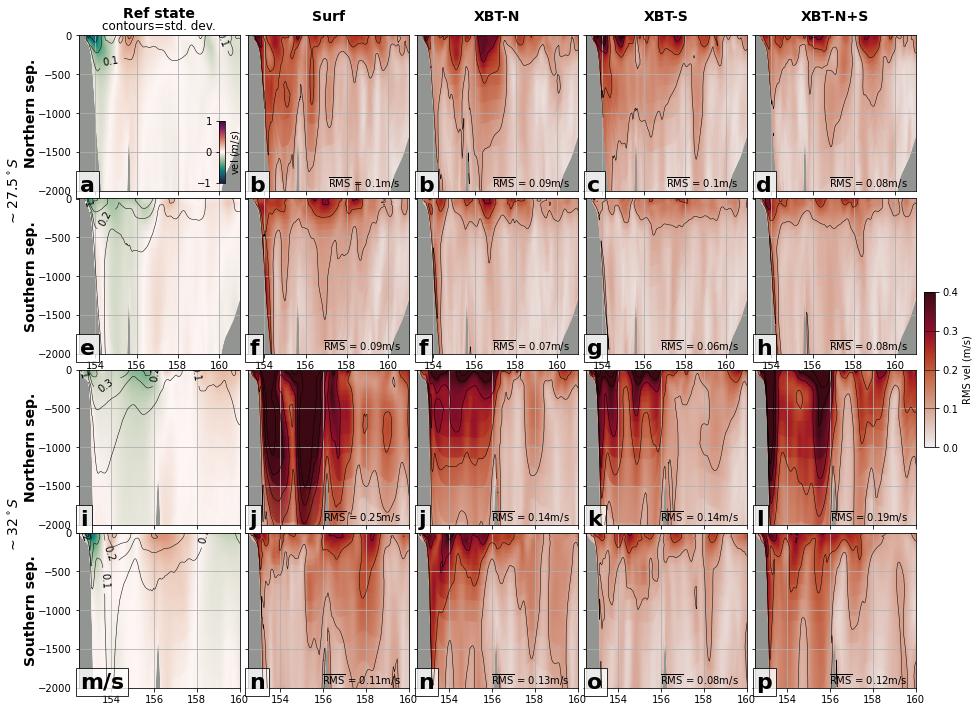

In [33]:

def addSubplot_VerticalTransect(X,Y,input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol])
    ax.set_facecolor('xkcd:grey')
    im = ax.pcolormesh(X,Y,input,shading='gouraud', **pcol_kwargs)
    # cax = inset_axes(ax,
    #              width="5%",  # width = 10% of parent_bbox width
    #              height="50%",  # height : 50%
    #              loc='lower left',
    #              bbox_to_anchor=(.05,.09, .8, .8),
    #              bbox_transform=ax.transAxes,
    #              borderpad=0,
    #              )
    ax.set_ylim([-2000,0])
    # cbar = fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.1, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
    ax.grid()
    return ax,im

def addSubplot_VerticalTransect_colorbar(X,Y,input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol])
    ax.set_facecolor('xkcd:grey')
    im = ax.pcolormesh(X,Y,input,shading='gouraud', **pcol_kwargs)
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.87,.05, .8, .8),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)
    cax.yaxis.tick_left()
    cax.set_ylabel('vel ($m/s$)')
    ax.set_ylim([-2000,0])
    ax.text(0.01, 0.1, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
    ax.grid()
    return ax,cbar,im


plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,12])
gs0 = fig.add_gridspec(nrows=2,ncols=1,wspace=0.025, hspace=0.05)
gs00 = gs0[0].subgridspec(2,5, wspace=0.05, hspace=0.05)
gs01 = gs0[1].subgridspec(2,5, wspace=0.05, hspace=0.05)
ax = None



skipRes = 10
skip = dict(eta_rho=slice(None,None,skipRes),xi_rho=slice(None,None,skipRes))



ax = addSubplot_VerticalTransect_colorbar(xx_270,zz_270, truth_N.v_northward.isel(eta_rho=270).mean(dim='ocean_time') ,gs00,0,0,'a',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.curl'})
co = ax[0].contour(xx_270,zz_270,truth_N.v_northward.isel(eta_rho=270).std(dim='ocean_time'),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
ax[0].text(0.5, 1.14, 'Ref state',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax[0].transAxes)
ax[0].text(-.3, .5, 'Northern sep.',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax[0].transAxes)
ax[0].text(-.4, 0, '$\sim27.5^\circ S$',fontsize=14, fontweight='bold',rotation='vertical', va='center', ha='center', transform=ax[0].transAxes)
ax[0].set_title('contours=std. dev.')
ax[0].set_xticklabels([])
ax[0].set_xlim([153.2,161])

ax = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_N.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs00,0,1,'b',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
ax[0].text(0.5, 1.12, 'Surf',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax[0].transAxes)
co = ax[0].contour(xx_270,zz_270,(((( SSHSST_N.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].set_xlim([153.2,161])
etaTransect=270
RMSval = (((( SSHSST_N.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)).where(mask==1).weighted(weights).mean(('xi_rho','s_rho')).isel(eta_rho=etaTransect)
ax[0].text(.95, .05, '$\overline{\mathrm{RMS}}$ = '+str(np.round(RMSval.values,2))+'m/s',fontsize=10, va='center', ha='right', transform=ax[0].transAxes)

ax = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_XBT_N_N.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs00,0,2,'b',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
ax[0].text(0.5, 1.12, 'XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax[0].transAxes)
co = ax[0].contour(xx_270,zz_270,(((( SSHSST_XBT_N_N.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].set_xlim([153.2,161])
etaTransect=270
RMSval = (((( SSHSST_XBT_N_N.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)).where(mask==1).weighted(weights).mean(('xi_rho','s_rho')).isel(eta_rho=etaTransect)
ax[0].text(.95, .05, '$\overline{\mathrm{RMS}}$ = '+str(np.round(RMSval.values,2))+'m/s',fontsize=10, va='center', ha='right', transform=ax[0].transAxes)

ax = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_XBT_S_N.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs00,0,3,'c',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
ax[0].text(0.5, 1.12, 'XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax[0].transAxes)
co = ax[0].contour(xx_270,zz_270,(((( SSHSST_XBT_S_N.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].set_xlim([153.2,161])
etaTransect=270
RMSval = (((( SSHSST_XBT_S_N.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)).where(mask==1).weighted(weights).mean(('xi_rho','s_rho')).isel(eta_rho=etaTransect)
ax[0].text(.95, .05, '$\overline{\mathrm{RMS}}$ = '+str(np.round(RMSval.values,2))+'m/s',fontsize=10, va='center', ha='right', transform=ax[0].transAxes)

ax = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_XBT_N1.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs00,0,4,'d',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
ax[0].text(0.5, 1.12, 'XBT-N+S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax[0].transAxes)
co = ax[0].contour(xx_270,zz_270,(((( SSHSST_XBT_N1.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
ax[0].set_yticklabels([])
ax[0].set_xlim([153.2,161])
etaTransect=270
RMSval = (((( SSHSST_XBT_N1.v_northward.isel(eta_rho=270)-truth_N.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)).where(mask==1).weighted(weights).mean(('xi_rho','s_rho')).isel(eta_rho=etaTransect)
ax[0].text(.95, .05, '$\overline{\mathrm{RMS}}$ = '+str(np.round(RMSval.values,2))+'m/s',fontsize=10, va='center', ha='right', transform=ax[0].transAxes)


ax = addSubplot_VerticalTransect(xx_270,zz_270, truth_S.v_northward.isel(eta_rho=270).mean(dim='ocean_time') ,gs00,1,0,'e',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.curl'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_270,zz_270,truth_S.v_northward.isel(eta_rho=270).std(dim='ocean_time'),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
ax[0].text(-.3, .5, 'Southern sep.',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax[0].transAxes)
ax[0].set_xlim([153.2,161])

ax = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_S.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs00,1,1,'f',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_270,zz_270,(((( SSHSST_S.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
ax[0].set_yticklabels([])
ax[0].set_xlim([153.2,161])
etaTransect=270
RMSval = (((( SSHSST_S.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)).where(mask==1).weighted(weights).mean(('xi_rho','s_rho')).isel(eta_rho=etaTransect)
ax[0].text(.95, .05, '$\overline{\mathrm{RMS}}$ = '+str(np.round(RMSval.values,2))+'m/s',fontsize=10, va='center', ha='right', transform=ax[0].transAxes)

ax = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_XBT_N_S.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs00,1,2,'f',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_270,zz_270,(((( SSHSST_XBT_N_S.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
ax[0].set_yticklabels([])
ax[0].set_xlim([153.2,161])
etaTransect=270
RMSval = (((( SSHSST_XBT_N_S.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)).where(mask==1).weighted(weights).mean(('xi_rho','s_rho')).isel(eta_rho=etaTransect)
ax[0].text(.95, .05, '$\overline{\mathrm{RMS}}$ = '+str(np.round(RMSval.values,2))+'m/s',fontsize=10, va='center', ha='right', transform=ax[0].transAxes)

ax = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_XBT_S_S.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs00,1,3,'g',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_270,zz_270,(((( SSHSST_XBT_S_S.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
ax[0].set_yticklabels([])
ax[0].set_xlim([153.2,161])
etaTransect=270
RMSval = (((( SSHSST_XBT_S_S.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)).where(mask==1).weighted(weights).mean(('xi_rho','s_rho')).isel(eta_rho=etaTransect)
ax[0].text(.95, .05, '$\overline{\mathrm{RMS}}$ = '+str(np.round(RMSval.values,2))+'m/s',fontsize=10, va='center', ha='right', transform=ax[0].transAxes)

ax = addSubplot_VerticalTransect(xx_270,zz_270, ((( SSHSST_XBT_S1.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2) ,gs00,1,4,'h',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_270,zz_270,(((( SSHSST_XBT_S1.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
ax[0].set_yticklabels([])
ax[0].set_xlim([153.2,161])
etaTransect=270
RMSval = (((( SSHSST_XBT_S1.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)).where(mask==1).weighted(weights).mean(('xi_rho','s_rho')).isel(eta_rho=etaTransect)
ax[0].text(.95, .05, '$\overline{\mathrm{RMS}}$ = '+str(np.round(RMSval.values,2))+'m/s',fontsize=10, va='center', ha='right', transform=ax[0].transAxes)


###

ax = addSubplot_VerticalTransect(xx_170,zz_170, truth_N.v_northward.isel(eta_rho=170).mean(dim='ocean_time') ,gs01,0,0,'i',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.curl'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_170,zz_170,truth_N.v_northward.isel(eta_rho=170).std(dim='ocean_time'),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
ax[0].text(-.3, .5, 'Northern sep.',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax[0].transAxes)
ax[0].text(-.4, 0, '$\sim32^\circ S$',fontsize=14, fontweight='bold',rotation='vertical', va='center', ha='center', transform=ax[0].transAxes)
ax[0].set_xticklabels([])
ax[0].set_xlim([152.5,160])

ax = addSubplot_VerticalTransect(xx_170,zz_170, ((( SSHSST_N.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2) ,gs01,0,1,'j',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_170,zz_170,(((( SSHSST_N.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].set_xlim([152.5,160])
etaTransect=170
RMSval = (((( SSHSST_N.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)).where(mask==1).weighted(weights).mean(('xi_rho','s_rho')).isel(eta_rho=etaTransect)
ax[0].text(.95, .05, '$\overline{\mathrm{RMS}}$ = '+str(np.round(RMSval.values,2))+'m/s',fontsize=10, va='center', ha='right', transform=ax[0].transAxes)

ax = addSubplot_VerticalTransect(xx_170,zz_170, ((( SSHSST_XBT_N_N.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2) ,gs01,0,2,'j',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_170,zz_170,(((( SSHSST_XBT_N_N.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].set_xlim([152.5,160])
etaTransect=170
RMSval = (((( SSHSST_XBT_N_N.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)).where(mask==1).weighted(weights).mean(('xi_rho','s_rho')).isel(eta_rho=etaTransect)
ax[0].text(.95, .05, '$\overline{\mathrm{RMS}}$ = '+str(np.round(RMSval.values,2))+'m/s',fontsize=10, va='center', ha='right', transform=ax[0].transAxes)

ax = addSubplot_VerticalTransect(xx_170,zz_170, ((( SSHSST_XBT_S_N.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2) ,gs01,0,3,'k',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_170,zz_170,(((( SSHSST_XBT_S_N.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].set_xlim([152.5,160])
etaTransect=170
RMSval = (((( SSHSST_XBT_S_N.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)).where(mask==1).weighted(weights).mean(('xi_rho','s_rho')).isel(eta_rho=etaTransect)
ax[0].text(.95, .05, '$\overline{\mathrm{RMS}}$ = '+str(np.round(RMSval.values,2))+'m/s',fontsize=10, va='center', ha='right', transform=ax[0].transAxes)

ax = addSubplot_VerticalTransect(xx_170,zz_170, ((( SSHSST_XBT_N1.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2) ,gs01,0,4,'l',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_170,zz_170,(((( SSHSST_XBT_N1.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].set_xlim([152.5,160])
cax = inset_axes(ax[0],
                 width="7%",  # width = 10% of parent_bbox width
                 height="100%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(1.05,.5, 1, 1),
                 bbox_transform=ax[0].transAxes,
                 borderpad=0,
                 )
cbar = fig.colorbar(ax[1], cax=cax)
cbar.ax.set_ylabel('RMS vel (m/s)')
cbar.add_lines(co)
etaTransect=170
RMSval = (((( SSHSST_XBT_N1.v_northward.isel(eta_rho=170)-truth_N.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)).where(mask==1).weighted(weights).mean(('xi_rho','s_rho')).isel(eta_rho=etaTransect)
ax[0].text(.95, .05, '$\overline{\mathrm{RMS}}$ = '+str(np.round(RMSval.values,2))+'m/s',fontsize=10, va='center', ha='right', transform=ax[0].transAxes)

ax = addSubplot_VerticalTransect(xx_170,zz_170, truth_S.v_northward.isel(eta_rho=170).mean(dim='ocean_time') ,gs01,1,0,'m/s',pcol_kwargs={'vmin':-1,'vmax':1,'cmap':'cmo.curl'})#, ax1[0].set_title('u (m/s)')
ax[0].text(-.3, .5, 'Southern sep.',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax[0].transAxes)
co = ax[0].contour(xx_170,zz_170,truth_S.v_northward.isel(eta_rho=170).std(dim='ocean_time'),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
ax[0].clabel(co, co.levels, inline=True, fontsize=10)
ax[0].set_xlim([152.5,160])

ax = addSubplot_VerticalTransect(xx_170,zz_170, ((( SSHSST_S.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2) ,gs01,1,1,'n',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_170,zz_170,(((( SSHSST_S.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
ax[0].set_yticklabels([])
ax[0].set_xlim([152.5,160])
etaTransect=170
RMSval = (((( SSHSST_S.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)).where(mask==1).weighted(weights).mean(('xi_rho','s_rho')).isel(eta_rho=etaTransect)
ax[0].text(.95, .05, '$\overline{\mathrm{RMS}}$ = '+str(np.round(RMSval.values,2))+'m/s',fontsize=10, va='center', ha='right', transform=ax[0].transAxes)

ax = addSubplot_VerticalTransect(xx_170,zz_170, ((( SSHSST_XBT_N_S.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2) ,gs01,1,2,'n',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_170,zz_170,(((( SSHSST_XBT_N_S.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
ax[0].set_yticklabels([])
ax[0].set_xlim([152.5,160])
etaTransect=170
RMSval = (((( SSHSST_XBT_N_S.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)).where(mask==1).weighted(weights).mean(('xi_rho','s_rho')).isel(eta_rho=etaTransect)
ax[0].text(.95, .05, '$\overline{\mathrm{RMS}}$ = '+str(np.round(RMSval.values,2))+'m/s',fontsize=10, va='center', ha='right', transform=ax[0].transAxes)

ax = addSubplot_VerticalTransect(xx_170,zz_170, ((( SSHSST_XBT_S_S.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2) ,gs01,1,3,'o',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_170,zz_170,(((( SSHSST_XBT_S_S.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
ax[0].set_yticklabels([])
ax[0].set_xlim([152.5,160])
etaTransect=170
RMSval = (((( SSHSST_XBT_S_S.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)).where(mask==1).weighted(weights).mean(('xi_rho','s_rho')).isel(eta_rho=etaTransect)
ax[0].text(.95, .05, '$\overline{\mathrm{RMS}}$ = '+str(np.round(RMSval.values,2))+'m/s',fontsize=10, va='center', ha='right', transform=ax[0].transAxes)


ax = addSubplot_VerticalTransect(xx_170,zz_170, ((( SSHSST_XBT_S1.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2) ,gs01,1,4,'p',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax[0].contour(xx_170,zz_170,(((( SSHSST_XBT_S1.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)),levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
ax[0].set_yticklabels([])
ax[0].set_xlim([152.5,160])
etaTransect=170
RMSval = (((( SSHSST_XBT_S1.v_northward.isel(eta_rho=170)-truth_S.v_northward.isel(eta_rho=170) )**2).mean(dim='ocean_time'))**(1/2)).where(mask==1).weighted(weights).mean(('xi_rho','s_rho')).isel(eta_rho=etaTransect)
ax[0].text(.95, .05, '$\overline{\mathrm{RMS}}$ = '+str(np.round(RMSval.values,2))+'m/s',fontsize=10, va='center', ha='right', transform=ax[0].transAxes)





(-2000.0, 0.0)

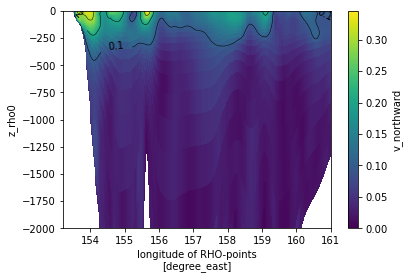

In [34]:
fig,ax=plt.subplots(1)
truth_N.v_northward.isel(eta_rho=270).std(dim='ocean_time').plot(ax=ax,x='lon_rho',y='z_rho0')
co = ax.contour(xx_270,zz_270,truth_N.v_northward.isel(eta_rho=270).std(dim='ocean_time'),levels=np.arange(0,.5,.1),colors='k',zorder=12,linewidths=0.5)
ax.clabel(co, co.levels, inline=True, fontsize=10)
ax.set_xlim([153.2,161])
ax.set_ylim([-2000,0])


In [35]:
STOP

NameError: name 'STOP' is not defined

In [ ]:
plt.pcolormesh(xx_270,zz_270,(((( SSHSST_XBT_S1.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)),shading='gouraud')
plt.colorbar()

In [ ]:
truth_energetics_N.mke500.plot(x='lon_rho',y='lat_rho')
plt.ylim([-40,-26])#([148, 161, -42, -25])
plt.xlim([149,160])

In [ ]:
truth_energetics_S.mke500.plot(x='lon_rho',y='lat_rho')
plt.ylim([-40,-26])#([148, 161, -42, -25])
plt.xlim([149,160])

In [ ]:
plt.pcolormesh(xx_270,zz_270,(((( SSHSST_XBT_S1.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)).where(zz_270>-2000),shading='nearest')
plt.colorbar()
print( (((( SSHSST_XBT_S1.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)).where(zz_270>-2000).mean(dim='xi_rho').mean(dim='s_rho') )
print( calc_depthAverageROMS2((((SSHSST_XBT_S1.v_northward.where(zz_270>-2000)-truth_S.v_northward.where(zz_270>-2000)**2).mean(dim='ocean_time'))**.5),SSHSST_XBT_S1.dx,SSHSST_XBT_S1.dz0,270) )
print( calc_depthAverageROMS2((((((SSHSST_XBT_S1.v_northward-truth_S.v_northward)**2).mean(dim='ocean_time'))**.5).where(zz_270>-2000)),SSHSST_XBT_S1.dx,SSHSST_XBT_S1.dz0,270) )
print( calc_depthAverageROMS2(((((SSHSST_XBT_S1.v_northward-truth_S.v_northward)**2).mean(dim='ocean_time'))**.5),SSHSST_XBT_S1.dx,SSHSST_XBT_S1.dz0,270) )




In [ ]:
np.nanmean((((( SSHSST_XBT_S1.v_northward.isel(eta_rho=270)-truth_S.v_northward.isel(eta_rho=270) )**2).mean(dim='ocean_time'))**(1/2)).where(zz_270>-2000).values)

In [ ]:
ax.text(.05, .05, str(np.round(calc_depthAverageROMS((((SSHSST_XBT_S1.v_northward.where(zz_270>-2000)-truth_S.v_northward.where(zz_270>-2000)**2).mean(dim='ocean_time'))**.5),truth_bu,270).values,2))+' $\circ C$' ,fontsize=10, va='center', ha='left', transform=ax.transAxes)


In [ ]:
truth

In [ ]:
ax.text(.05, .05, str(np.round(calc_depthAverageROMS2((((SSHSST_XBT_S1.v_northward.where(zz_270>-2000)-truth_S.v_northward.where(zz_270>-2000)**2).mean(dim='ocean_time'))**.5),SSHSST_XBT_S1.dx,SSHSST_XBT_S1.dz0,270).values,3))+' $m/s$' ,fontsize=10, va='center', ha='left', transform=ax.transAxes)

In [ ]:
str(np.round(calc_depthAverageROMS2((((SSHSST_XBT_S1.v_northward.where(zz_270>-2000)-truth_S.v_northward.where(zz_270>-2000)**2).mean(dim='ocean_time'))**.5),SSHSST_XBT_S1.dx,SSHSST_XBT_S1.dz0,270).values,3))

In [ ]:
def calc_depthAverageROMS2(input,dx,dz0,etaTransect):
    input = input.isel(eta_rho=etaTransect)
    dz = dz0.isel(eta_rho=etaTransect)
    dx = dx.isel(eta_rho=etaTransect)
    output = ((input*dz*dx).sum(dim=['xi_rho','s_rho'],skipna=True))/(dz*dx).sum(dim=['xi_rho','s_rho'],skipna=True)
    return output

calc_depthAverageROMS2((((SSHSST_XBT_S1.v_northward.where(zz_270>-2000)-truth_S.v_northward.where(zz_270>-2000)**2).mean(dim='ocean_time'))**.5),SSHSST_XBT_S1.dx,SSHSST_XBT_S1.dz0,270)

In [ ]:
(((SSHSST_XBT_S1.v_northward.where(zz_270>-2000)-truth_S.v_northward.where(zz_270>-2000)**2).mean(dim='ocean_time'))**.5)

In [ ]:
str(np.round(calc_areaAverageROMS((((((SSHSST_XBT_energetics_S.eke_0-truth_energetics_S.eke_0)**2).mean(dim='ocean_time'))**.5)),truth_bu).values,4))+' $m^2/s^2$'


In [ ]:
((((SSHSST_energetics_S.eke_0-truth_energetics_S.eke_0)**2).mean(dim='ocean_time'))**(1/2)).plot()
((((SSHSST_energetics_S.eke_0-truth_energetics_S.eke_0)**2).mean(dim='ocean_time'))**(1/2)).plot()

In [ ]:
truth_N

In [ ]:
import cv2

# Read image files
img_array = []
for i in range(leng):
    filename=('/g/data/fu5/deg581/OSSE_analysis/data/out/EAC_OSSE_0_500m_'+str(i+1)+'.png')
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

## Output the animation   
# cv2.VideoWriter(filename, fourcc, fps, framesize, isColor)
out = cv2.VideoWriter('/g/data/fu5/deg581/OSSE_analysis/data/out/EAC_OSSE_0_500m.avi',cv2.VideoWriter_fourcc(*'DIVX'), 5, size) 
for i in range(np.size(img_array,0)):
    out.write(img_array[i])
out.release()
# os.system('rm '+directory+'/PUG/Scenario_dye_HSM_*.png')

In [ ]:
truth

In [ ]:
# skip=(slice(None,None,skipRes),slice(None,None,skipRes))
skip = dict(eta_rho=slice(None,None,skipRes),xi_rho=slice(None,None,skipRes))

truth_u500.isel(skip)

In [ ]:
truth_temp500

In [ ]:
## test vertical transect

def addSubplot_VerticalTransect(X,Y,input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol])
    ax.set_facecolor('xkcd:grey')
    im = ax.pcolormesh(X,Y,input,shading='gouraud', **pcol_kwargs)
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.05,.09, .8, .8),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    ax.set_ylim([-2000,0])
    cbar = fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.grid()
    return ax,cbar

def addSubplot_VerticalTransect_contourf(X,Y,input,levels,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol])
    ax.set_facecolor('xkcd:grey')
    im = ax.contourf(X,Y,input,levels,**pcol_kwargs)
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.82,.09, .8, .8),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)
    return ax




gs = gridspec.GridSpec(nrows=5,ncols=3,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,15])
ax = None

# reqd for contourf plot
levels=np.arange(-100,110,25)



# add plots
## top row

ax1,cbar = addSubplot_VerticalTransect(xx_270,zz_270,truth_v_270.mean(dim='ocean_time'),gs,0,0,'a',pcol_kwargs={'cmap':'cmo.curl','vmin':-.6,'vmax':.6})#, ax1[0].set_title('u (m/s)')
ax1.text(0.5, 1.1, '$\sim27.5^\circ S$',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax1.transAxes)
ax1.text(-.2, .5, 'Truth mean state',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax1.transAxes)
ax1.set_xticklabels([])
ax1.plot(boxLon,boxDep,color='0.8',linewidth=1)

ax2,cbar = addSubplot_VerticalTransect(xx_170,zz_170,truth_v_170.mean(dim='ocean_time'),gs,0,1,'b',pcol_kwargs={'cmap':'cmo.curl','vmin':-.5,'vmax':.5})#, ax1[0].set_title('u (m/s)')
ax2.text(0.5, 1.1, '$\sim32^\circ S$',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax2.transAxes)
ax2.set_xticklabels([])
ax2.set_yticklabels([])

ax3,cbar = addSubplot_VerticalTransect(xx_80,zz_80,truth_v_80.mean(dim='ocean_time'),gs,0,2,'c',pcol_kwargs={'cmap':'cmo.curl','vmin':-.2,'vmax':.2})#, ax1[0].set_title('u (m/s)')
ax3.text(0.5, 1.1, '$\sim35.5^\circ S$',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax3.transAxes)
ax3.set_xticklabels([])
ax3.set_yticklabels([])

#row2

ax4,cbar = addSubplot_VerticalTransect(xx_270,zz_270,RMSD_SSHSST_270,gs,1,0,'d',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax4.contour(xx_270,zz_270,RMSD_SSHSST_270,levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax4.text(-.2, .5, 'SSH+SST',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax4.transAxes)
ax4.set_xticklabels([])

ax5,cbar = addSubplot_VerticalTransect(xx_170,zz_170,RMSD_SSHSST_170,gs,1,1,'e',pcol_kwargs={'vmin':0,'vmax':0.6,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax5.contour(xx_170,zz_170,RMSD_SSHSST_170,levels=np.arange(0,.7,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax5.set_xticklabels([])
ax5.set_yticklabels([])

ax6,cbar = addSubplot_VerticalTransect(xx_80,zz_80,RMSD_SSHSST_80,gs,1,2,'f',pcol_kwargs={'vmin':0,'vmax':0.5,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax6.contour(xx_80,zz_80,RMSD_SSHSST_80,levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax6.set_xticklabels([])
ax6.set_yticklabels([])

#row 3

ax7,cbar = addSubplot_VerticalTransect(xx_270,zz_270,RMSD_SSHSST_XBT_N_270,gs,2,0,'g',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax7.contour(xx_270,zz_270,RMSD_SSHSST_XBT_N_270,levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
# ax7.text(.9, .05, str(np.round(calc_depthAverageROMS(I_XBT_N_270,truth,270).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax7.transAxes)
ax7.text(-.2, .5, 'SSH+SST+XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax7.transAxes)
ax7.set_xticklabels([])

ax8,cbar = addSubplot_VerticalTransect(xx_170,zz_170,RMSD_SSHSST_XBT_N_170,gs,2,1,'h',pcol_kwargs={'vmin':0,'vmax':0.6,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax8.contour(xx_170,zz_170,RMSD_SSHSST_XBT_N_170,levels=np.arange(0,.7,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
# ax8.text(.9, .05, str(np.round(calc_depthAverageROMS(I_XBT_N_170,truth,170).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax8.transAxes)
ax8.set_xticklabels([])
ax8.set_yticklabels([])

ax9,cbar = addSubplot_VerticalTransect(xx_80,zz_80,RMSD_SSHSST_XBT_N_80,gs,2,2,'i',pcol_kwargs={'vmin':0,'vmax':0.5,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
# ax9.text(.9, .05, str(np.round(calc_depthAverageROMS(I_XBT_N_80,truth,80).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax9.transAxes)
co = ax9.contour(xx_80,zz_80,RMSD_SSHSST_XBT_N_80,levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
ax9.set_xticklabels([])
ax9.set_yticklabels([])
#row 4

ax10,cbar = addSubplot_VerticalTransect(xx_270,zz_270,RMSD_SSHSST_XBT_S_270,gs,3,0,'j',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax10.contour(xx_270,zz_270,RMSD_SSHSST_XBT_S_270,levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
# ax10.text(.9, .05, str(np.round(calc_depthAverageROMS(I_XBT_S_270,truth,270).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax10.transAxes)
ax10.text(-.2, .5, 'SSH+SST+XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax10.transAxes)
ax10.set_xticklabels([])

ax11,cbar = addSubplot_VerticalTransect(xx_170,zz_170,RMSD_SSHSST_XBT_S_170,gs,3,1,'k',pcol_kwargs={'vmin':0,'vmax':0.6,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax11.contour(xx_170,zz_170,RMSD_SSHSST_XBT_S_170,levels=np.arange(0,.7,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
# ax11.text(.9, .05, str(np.round(calc_depthAverageROMS(I_XBT_S_170,truth,170).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax11.transAxes)
ax11.set_xticklabels([])
ax11.set_yticklabels([])

ax12,cbar = addSubplot_VerticalTransect(xx_80,zz_80,RMSD_SSHSST_XBT_S_80,gs,3,2,'l',pcol_kwargs={'vmin':0,'vmax':0.5,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax12.contour(xx_80,zz_80,RMSD_SSHSST_XBT_S_80,levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
# ax12.text(.9, .05, str(np.round(calc_depthAverageROMS(I_XBT_S_80,truth,80).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax12.transAxes)
ax12.set_xticklabels([])
ax12.set_yticklabels([])
#row 5

ax13,cbar = addSubplot_VerticalTransect(xx_270,zz_270,RMSD_SSHSST_XBT_270,gs,4,0,'m',pcol_kwargs={'vmin':0,'vmax':0.4,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax13.contour(xx_270,zz_270,RMSD_SSHSST_XBT_270,levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
# ax13.text(.9, .05, str(np.round(calc_depthAverageROMS(I_XBT_270,truth,270).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax13.transAxes)
ax13.text(-.2, .5, 'SSH+SST+XBT-N+S',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax13.transAxes)

ax14,cbar = addSubplot_VerticalTransect(xx_170,zz_170,RMSD_SSHSST_XBT_170,gs,4,1,'n',pcol_kwargs={'vmin':0,'vmax':0.6,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax14.contour(xx_170,zz_170,RMSD_SSHSST_XBT_170,levels=np.arange(0,.7,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)
# ax14.text(.9, .05, str(np.round(calc_depthAverageROMS(I_XBT_170,truth,170).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax14.transAxes)
ax14.set_yticklabels([])

ax15,cbar = addSubplot_VerticalTransect(xx_80,zz_80,RMSD_SSHSST_XBT_80,gs,4,2,'o',pcol_kwargs={'vmin':0,'vmax':0.5,'cmap':'cmo.amp'})#, ax1[0].set_title('u (m/s)')
co = ax15.contour(xx_80,zz_80,RMSD_SSHSST_XBT_80,levels=np.arange(0,.6,.1),colors='k',zorder=12,linewidths=0.5)
cbar.add_lines(co)

# ax15.text(.9, .05, str(np.round(calc_depthAverageROMS(I_XBT_80,truth,80).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax15.transAxes)
ax15.set_yticklabels([])

In [ ]:
STOP

In [ ]:



gs = gridspec.GridSpec(nrows=1,ncols=1)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,15])
ax = None

ax1 = spatialMap_addGSSubplot(OSSE_SSHSST_bu.h,gs,0,0,'a')
transectEta=270
xx=truth.lon_rho.isel(eta_rho=transectEta)
yy=truth.lat_rho.isel(eta_rho=transectEta)
ax1.plot(xx,yy,linestyle='none',color="C0",marker='.',markersize=1,zorder=12)
transectEta=170
xx=truth.lon_rho.isel(eta_rho=transectEta)
yy=truth.lat_rho.isel(eta_rho=transectEta)
ax1.plot(xx,yy,linestyle='none',color="C1",marker='.',markersize=1,zorder=12)
transectEta=80
xx=truth.lon_rho.isel(eta_rho=transectEta)
yy=truth.lat_rho.isel(eta_rho=transectEta)
ax1.plot(xx,yy,linestyle='none',color="C2",marker='.',markersize=1,zorder=12)


In [ ]:
## test vertical transect

def addSubplot_VerticalTransect(X,Y,input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol])
    ax.set_facecolor('xkcd:grey')
    im = ax.pcolormesh(X,Y,input,shading='gouraud', **pcol_kwargs)
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.05,.09, .8, .8),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    ax.set_ylim([-2000,0])
    fig.colorbar(im, cax=cax)
    ax.grid()
    return ax

def addSubplot_VerticalTransect_contourf(X,Y,input,levels,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol])
    ax.set_facecolor('xkcd:grey')
    im = ax.contourf(X,Y,input,levels,**pcol_kwargs)
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.82,.09, .8, .8),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)
    return ax




gs = gridspec.GridSpec(nrows=5,ncols=3,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,22.5])
ax = None

# reqd for contourf plot
levels=np.arange(-100,110,25)



# add plots
## top row

ax1 = addSubplot_VerticalTransect(xx_270,zz_270,truth_v_270.mean(dim='ocean_time'),gs,0,0,'a',pcol_kwargs={'cmap':'cmo.curl','vmin':-.6,'vmax':.6})#, ax1[0].set_title('u (m/s)')
ax1.text(0.5, 1.1, '$\sim27.5^\circ S$',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax1.transAxes)
ax1.text(-.2, .5, 'Truth mean state',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax1.transAxes)
ax1.set_xticklabels([])
ax1.plot(boxLon,boxDep,color='0.8',linewidth=1)

ax2 = addSubplot_VerticalTransect(xx_170,zz_170,truth_v_170.mean(dim='ocean_time'),gs,0,1,'b',pcol_kwargs={'cmap':'cmo.curl','vmin':-.5,'vmax':.5})#, ax1[0].set_title('u (m/s)')
ax2.text(0.5, 1.1, '$\sim32^\circ S$',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax2.transAxes)
ax2.set_xticklabels([])
ax2.set_yticklabels([])

ax3 = addSubplot_VerticalTransect(xx_80,zz_80,truth_v_80.mean(dim='ocean_time'),gs,0,2,'c',pcol_kwargs={'cmap':'cmo.curl','vmin':-.2,'vmax':.2})#, ax1[0].set_title('u (m/s)')
ax3.text(0.5, 1.1, '$\sim34^\circ S$',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax3.transAxes)
ax3.set_xticklabels([])
ax3.set_yticklabels([])

#row2

ax4 = addSubplot_VerticalTransect(xx_270,zz_270,RMSD_SSHSST_270,gs,1,0,'d',pcol_kwargs={})#, ax1[0].set_title('u (m/s)')
ax4.text(-.2, .5, 'SSH+SST rms',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax4.transAxes)
ax4.set_xticklabels([])

ax5 = addSubplot_VerticalTransect(xx_170,zz_170,RMSD_SSHSST_170,gs,1,1,'e',pcol_kwargs={})#, ax1[0].set_title('u (m/s)')
ax5.set_xticklabels([])
ax5.set_yticklabels([])

ax6 = addSubplot_VerticalTransect(xx_80,zz_80,RMSD_SSHSST_80,gs,1,2,'f',pcol_kwargs={})#, ax1[0].set_title('u (m/s)')
ax6.set_xticklabels([])
ax6.set_yticklabels([])

#row 3

ax7 = addSubplot_VerticalTransect(xx_270,zz_270,I_XBT_N_270,gs,2,0,'g',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})#, ax1[0].set_title('u (m/s)')
ax7.contour(xx_270,zz_270,I_XBT_N_270,levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
# ax7.text(.9, .05, str(np.round(calc_depthAverageROMS(I_XBT_N_270,truth,270).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax7.transAxes)
ax7.text(-.2, .5, 'XBT-N %I',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax7.transAxes)
ax7.set_xticklabels([])

ax8 = addSubplot_VerticalTransect(xx_170,zz_170,I_XBT_N_170,gs,2,1,'h',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})#, ax1[0].set_title('u (m/s)')
ax8.contour(xx_170,zz_170,I_XBT_N_170,levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
# ax8.text(.9, .05, str(np.round(calc_depthAverageROMS(I_XBT_N_170,truth,170).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax8.transAxes)
ax8.set_xticklabels([])
ax8.set_yticklabels([])

ax9 = addSubplot_VerticalTransect(xx_80,zz_80,I_XBT_N_80,gs,2,2,'i',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})#, ax1[0].set_title('u (m/s)')
# ax9.text(.9, .05, str(np.round(calc_depthAverageROMS(I_XBT_N_80,truth,80).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax9.transAxes)
ax9.contour(xx_80,zz_80,I_XBT_N_80,levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
ax9.set_xticklabels([])
ax9.set_yticklabels([])
#row 4

ax10 = addSubplot_VerticalTransect(xx_270,zz_270,I_XBT_S_270,gs,3,0,'j',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})#, ax1[0].set_title('u (m/s)')
ax10.contour(xx_270,zz_270,I_XBT_S_270,levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
# ax10.text(.9, .05, str(np.round(calc_depthAverageROMS(I_XBT_S_270,truth,270).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax10.transAxes)
ax10.text(-.2, .5, 'XBT-S %I',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax10.transAxes)
ax10.set_xticklabels([])

ax11 = addSubplot_VerticalTransect(xx_170,zz_170,I_XBT_S_170,gs,3,1,'k',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})#, ax1[0].set_title('u (m/s)')
ax11.contour(xx_170,zz_170,I_XBT_S_170,levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
# ax11.text(.9, .05, str(np.round(calc_depthAverageROMS(I_XBT_S_170,truth,170).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax11.transAxes)
ax11.set_xticklabels([])
ax11.set_yticklabels([])

ax12 = addSubplot_VerticalTransect(xx_80,zz_80,I_XBT_S_80,gs,3,2,'l',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})#, ax1[0].set_title('u (m/s)')
ax12.contour(xx_80,zz_80,I_XBT_S_80,levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
# ax12.text(.9, .05, str(np.round(calc_depthAverageROMS(I_XBT_S_80,truth,80).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax12.transAxes)
ax12.set_xticklabels([])
ax12.set_yticklabels([])
#row 5

ax13 = addSubplot_VerticalTransect(xx_270,zz_270,I_XBT_270,gs,4,0,'m',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})#, ax1[0].set_title('u (m/s)')
ax13.contour(xx_270,zz_270,I_XBT_270,levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
# ax13.text(.9, .05, str(np.round(calc_depthAverageROMS(I_XBT_270,truth,270).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax13.transAxes)
ax13.text(-.2, .5, 'XBT %I',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax13.transAxes)

ax14 = addSubplot_VerticalTransect(xx_170,zz_170,I_XBT_170,gs,4,1,'n',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})#, ax1[0].set_title('u (m/s)')
ax14.contour(xx_170,zz_170,I_XBT_170,levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
# ax14.text(.9, .05, str(np.round(calc_depthAverageROMS(I_XBT_170,truth,170).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax14.transAxes)
ax14.set_yticklabels([])

ax15 = addSubplot_VerticalTransect(xx_80,zz_80,I_XBT_80,gs,4,2,'o',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})#, ax1[0].set_title('u (m/s)')
ax15.contour(xx_80,zz_80,I_XBT_80,levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
# ax15.text(.9, .05, str(np.round(calc_depthAverageROMS(I_XBT_80,truth,80).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax15.transAxes)
ax15.set_yticklabels([])